In [1]:
import numpy as np
import pandas as pd
import os, gc
import lightgbm as lgb
import xgboost as xgb
import catboost as ctb
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import date, datetime, timedelta
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.linear_model import Ridge
from scipy.optimize import nnls
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)
np.set_printoptions(precision=6, suppress=True)

In [2]:
# note: data update 2020-04-15, wmc, full
mname = 'gbt5f'
path = '/kaggle/input/gbt5fx/'
pathk = '/kaggle/input/covid19-global-forecasting-week-4/'
nhorizon = 30
skip = 0
kv = [6,11]
val_scheme = 'forward'
pw = 'week3'
prev_test = False
blend = True
train_full = True
save_data = False

booster = ['lgb','xgb','ctb','rdg']
# booster = ['cas']

blender = ['nq0j_updated','kaz0z']

# for nq final day adjustment
# when validating make this the first validation day
# for final fitting with nhorizon = 30, make it today
# TODAY = '2020-04-08'
TODAY = '2020-04-15'

teams = []

# if using updated daily data, also update time-varying external data
# in COVID-19, covid-19-data, covid-tracking-data, git pull origin master 
# ecdc wget https://opendata.ecdc.europa.eu/covid19/casedistribution/csv
# weather: https://www.kaggle.com/davidbnn92/weather-data/output?scriptVersionId=31103959
# google trends: pytrends0d.ipynb
# data scraped from https://www.worldometers.info/coronavirus/, including past daily snapshots
# download html for final day (country and us states) at 22:00 UTC and run wm0d.ipynb first

In [3]:
train = pd.read_csv(pathk+'train.csv')

# helper lists
ynames = ['ConfirmedCases', 'Fatalities']
ny = len(ynames)
cp = ['Country_Region','Province_State']
cpd = cp + ['Date']

# from kaz
train["key"] = train[["Province_State","Country_Region"]].apply(lambda row: \
                                                str(row[0]) + "_" + str(row[1]),axis=1)

# fill missing provinces with blanks, must also do this with external data before merging
# need to fillna so groupby works
train[cp] = train[cp].fillna('')
train = train.sort_values(cpd).reset_index(drop=True)

train

Id Province_State Country_Region        Date  ConfirmedCases  \
0          1                   Afghanistan  2020-01-22             0.0   
1          2                   Afghanistan  2020-01-23             0.0   
2          3                   Afghanistan  2020-01-24             0.0   
3          4                   Afghanistan  2020-01-25             0.0   
4          5                   Afghanistan  2020-01-26             0.0   
...      ...            ...            ...         ...             ...   
27226  35651                      Zimbabwe  2020-04-13            17.0   
27227  35652                      Zimbabwe  2020-04-14            17.0   
27228  35653                      Zimbabwe  2020-04-15            23.0   
27229  35654                      Zimbabwe  2020-04-16            23.0   
27230  35655                      Zimbabwe  2020-04-17            24.0   

       Fatalities              key  
0             0.0  nan_Afghanistan  
1             0.0  nan_Afghanistan  
2             0.0  nan_Afghanistan  
3             0.0  nan_Afghanistan  
4             0.0  nan_Afghanistan  
...           ...              ...  
27226         3.0     nan_Zimbabwe  
27227         3.0     nan_Zimbabwe  
27228         3.0     nan_Zimbabwe  
27229         3.0     nan_Zimbabwe  
27230         3.0     nan_Zimbabwe  

[27231 rows x 7 columns]

In [4]:
# use previous week test set in order to compare with previous week leaderboard
if prev_test:
    test = pd.read_csv('../'+pw+'/test.csv')
    ss = pd.read_csv('../'+pw+'/submission.csv')
else:
    test = pd.read_csv(pathk+'test.csv')
    ss = pd.read_csv(pathk+'submission.csv')

# from kaz
test["key"] = test[["Province_State","Country_Region"]].apply(lambda row: \
                                            str(row[0]) + "_" + str(row[1]),axis=1)

test[cp] = test[cp].fillna('')
test

ForecastId Province_State Country_Region        Date              key
0               1                   Afghanistan  2020-04-02  nan_Afghanistan
1               2                   Afghanistan  2020-04-03  nan_Afghanistan
2               3                   Afghanistan  2020-04-04  nan_Afghanistan
3               4                   Afghanistan  2020-04-05  nan_Afghanistan
4               5                   Afghanistan  2020-04-06  nan_Afghanistan
...           ...            ...            ...         ...              ...
13454       13455                      Zimbabwe  2020-05-10     nan_Zimbabwe
13455       13456                      Zimbabwe  2020-05-11     nan_Zimbabwe
13456       13457                      Zimbabwe  2020-05-12     nan_Zimbabwe
13457       13458                      Zimbabwe  2020-05-13     nan_Zimbabwe
13458       13459                      Zimbabwe  2020-05-14     nan_Zimbabwe

[13459 rows x 5 columns]

In [5]:
# tmax and dmax are the last day of training
tmax = train.Date.max()
dmax = datetime.strptime(tmax,'%Y-%m-%d').date()
print(tmax, dmax)

2020-04-17 2020-04-17


In [6]:
fmax = test.Date.max()
fdate = datetime.strptime(fmax,'%Y-%m-%d').date()
fdate

datetime.date(2020, 5, 14)

In [7]:
tmin = train.Date.min()
fmin = test.Date.min()
tmin, fmin

('2020-01-22', '2020-04-02')

In [8]:
dmin = datetime.strptime(tmin,'%Y-%m-%d').date()
print(dmin)

2020-01-22


In [9]:
# prepare for concat
train = train.merge(test[cpd+['ForecastId']], how='left', on=cpd)
train['ForecastId'] = train['ForecastId'].fillna(0).astype(int)
train['y0_pred'] = np.nan
train['y1_pred'] = np.nan

test['Id'] = test.ForecastId + train.Id.max()
test['ConfirmedCases'] = np.nan
test['Fatalities'] = np.nan
# use zeros here instead of nans so monotonic adjustment fills final dates if necessary
test['y0_pred'] = 0.0
test['y1_pred'] = 0.0

In [10]:
# concat non-overlapping part of test to train for feature engineering
d = pd.concat([train,test[test.Date > train.Date.max()]],sort=True).reset_index(drop=True)
d

ConfirmedCases Country_Region        Date  Fatalities  ForecastId  \
0                 0.0    Afghanistan  2020-01-22         0.0           0   
1                 0.0    Afghanistan  2020-01-23         0.0           0   
2                 0.0    Afghanistan  2020-01-24         0.0           0   
3                 0.0    Afghanistan  2020-01-25         0.0           0   
4                 0.0    Afghanistan  2020-01-26         0.0           0   
...               ...            ...         ...         ...         ...   
35677             NaN       Zimbabwe  2020-05-10         NaN       13455   
35678             NaN       Zimbabwe  2020-05-11         NaN       13456   
35679             NaN       Zimbabwe  2020-05-12         NaN       13457   
35680             NaN       Zimbabwe  2020-05-13         NaN       13458   
35681             NaN       Zimbabwe  2020-05-14         NaN       13459   

          Id Province_State              key  y0_pred  y1_pred  
0          1                 nan_Afghanistan      NaN      NaN  
1          2                 nan_Afghanistan      NaN      NaN  
2          3                 nan_Afghanistan      NaN      NaN  
3          4                 nan_Afghanistan      NaN      NaN  
4          5                 nan_Afghanistan      NaN      NaN  
...      ...            ...              ...      ...      ...  
35677  49110                    nan_Zimbabwe      0.0      0.0  
35678  49111                    nan_Zimbabwe      0.0      0.0  
35679  49112                    nan_Zimbabwe      0.0      0.0  
35680  49113                    nan_Zimbabwe      0.0      0.0  
35681  49114                    nan_Zimbabwe      0.0      0.0  

[35682 rows x 10 columns]

In [11]:
(dmin + timedelta(30)).isoformat()

'2020-02-21'

In [12]:
d['Date'].value_counts().std()

0.0

In [13]:
# fill missing province with blank, must also do this with external data before merging
d[cp] = d[cp].fillna('')

# create single location variable
d['Loc'] = d['Country_Region'] + ' ' + d['Province_State']
d['Loc'] = d['Loc'].str.strip()
d['Loc'].value_counts()

China Fujian                        114
US Idaho                            114
Argentina                           114
Canada Quebec                       114
Saint Vincent and the Grenadines    114
                                   ... 
Egypt                               114
El Salvador                         114
Bulgaria                            114
Diamond Princess                    114
Central African Republic            114
Name: Loc, Length: 313, dtype: int64

In [14]:
# drop new regions in order to compare with previous week leaderboard
if prev_test:
    test2 = pd.read_csv('../'+pw+'/test.csv')
    test2[cp] = test2[cp].fillna('')
    test2 = test2.drop(['ForecastId','Date'], axis=1).drop_duplicates()
    test2
    d = d.merge(test2, how='inner', on=cp)
    d.shape

In [15]:
# log1p transform both targets
yv = []
for i in range(ny):
    v = 'y'+str(i)
    d[v] = np.log1p(d[ynames[i]])
    yv.append(v)
    
# enforce monotonicity, roughly cleans some data errors
d[yv] = d.groupby(cp)[yv].cummax()

print(d[yv].describe())

                 y0            y1
count  27231.000000  27231.000000
mean       2.525360      0.765020
std        2.975960      1.560482
min        0.000000      0.000000
25%        0.000000      0.000000
50%        1.098612      0.000000
75%        4.934474      0.693147
max       12.348431     10.032145


In [16]:
# without monotonicity, small changes can make a big difference
#                 y0            y1
# count  24174.000000  24174.000000
# mean       2.210124      0.582766
# std        2.789791      1.329384
# min        0.000000      0.000000
# 25%        0.000000      0.000000
# 50%        0.693147      0.000000
# 75%        4.442651      0.693147
# max       11.993993      9.813563

In [17]:
# merge predictions from other teams
# right now these are based only on public lb training set < 2020-03-26
# need to also use predictions from full set
# teams = ['dott0b','psi0b','cpmp0b']
tfeats = [[],[]]
for ti in teams:
    td = pd.read_csv('sub/'+ti+'.csv')
    t = ti[:-2]
    print(td.head(), td.shape, ti, t)
    td[t+'0'] = np.log1p(td.ConfirmedCases)
    td[t+'1'] = np.log1p(td.Fatalities)
    td.drop(ynames, axis=1, inplace=True)
    if 'ForecastId' in list(td.columns):
        d = d.merge(td, how='left', on='ForecastId')
    else:
        d = d.merge(td, how='left', on='Id')
    print(d.shape)
    tfeats[0].append(t+'0')
    tfeats[1].append(t+'1')
tf2 = len(tfeats[0])
print(tfeats, tf2)
gc.collect()

[[], []] 0


4

In [18]:
# sort by location then date
d = d.sort_values(['Loc','Date']).reset_index(drop=True)

In [19]:
d['Country_Region'].value_counts(dropna=False)

US                          6156
China                       3762
Canada                      1368
United Kingdom              1254
France                      1254
                            ... 
Latvia                       114
Indonesia                    114
Italy                        114
Hungary                      114
Central African Republic     114
Name: Country_Region, Length: 184, dtype: int64

In [20]:
d['Province_State'].value_counts(dropna=False)

                            20520
Saint Barthelemy              114
Isle of Man                   114
Ohio                          114
Colorado                      114
                            ...  
Hainan                        114
Turks and Caicos Islands      114
Yunnan                        114
South Australia               114
Alaska                        114
Name: Province_State, Length: 134, dtype: int64

In [21]:
d.shape

(35682, 13)

In [22]:
# data scraped from https://www.worldometers.info/coronavirus/, including past daily snapshots
# download html for final day (country and us states) at 22:00 UTC and run wm0d.ipynb first
wmf = []
wm = pd.read_csv(path+'wmc.csv')
wm[cp] = wm[cp].fillna('')
# 12 new features, all log1p transformed, must be lagged
wmf = [c for c in wm.columns if c not in cpd]

# since wm leads by a day, shift the date to make it contemporaneous
wmax = wm.Date.max()
wmax = datetime.strptime(wmax,'%Y-%m-%d').date()
woff = (dmax - wmax).days
print(dmax, wmax, woff)
wm1 = wm.copy()
wm1['Date'] = (pd.to_datetime(wm1.Date) + timedelta(woff)).dt.strftime('%Y-%m-%d')

wm1.Date.value_counts()[:10]

2020-04-17 2020-04-15 2


2020-04-14    318
2020-04-16    318
2020-04-13    318
2020-04-15    318
2020-04-12    317
2020-04-11    316
2020-04-09    315
2020-04-08    315
2020-04-10    315
2020-04-07    314
Name: Date, dtype: int64

In [23]:
wm1['Date'].max()

'2020-04-17'

In [24]:
d = d.merge(wm1, how='left', on=cpd)
print(d.shape)
d[wmf].describe()

(35682, 25)


ActiveCases     Deaths1M     NewCases    NewDeaths  SeriousCritical  \
count  11571.000000  4202.000000  8656.000000  4475.000000      6180.000000   
mean       3.847963     1.378609     2.563920     1.314274         1.657398   
std        2.845548     1.541506     2.251743     1.528271         1.915313   
min        0.000000     0.000000     0.000000     0.000000         0.000000   
25%        1.386294     0.058269     0.649089     0.000717         0.125085   
50%        3.583519     0.693147     2.197225     0.693147         0.962716   
75%        6.008813     2.397895     4.174387     1.945910         2.564949   
max       12.091262     6.967909     9.311090     7.271704         8.905444   

       ...  TotDeaths1M    TotalCases  TotalDeaths  TotalRecovered  \
count  ...   603.000000  12587.000000  8092.000000     8295.000000   
mean   ...     0.613711      3.942764     1.924447        2.465779   
std    ...     1.043347      2.754017     2.043775        2.146228   
min    ...     0.000000      0.000000     0.000000        0.000000   
25%    ...     0.000062      1.609438     0.097358        0.693147   
50%    ...     0.182322      3.433987     1.386294        1.945910   
75%    ...     0.693147      6.016157     3.091042        3.610918   
max    ...     6.429719     12.272703     9.982576       11.192734   

        TotalTests  
count  2566.000000  
mean      9.000015  
std       2.370088  
min       1.098612  
25%       7.315712  
50%       9.337101  
75%      10.719779  
max      14.362682  

[8 rows x 12 columns]

In [25]:
# google trends
gt = pd.read_csv(path+'google_trends.csv')
gt[cp] = gt[cp].fillna('')
gt

Date  covid-19  covid19  coronavirus Country_Region  \
0      2020-01-15       0.0      0.0          0.0    Afghanistan   
1      2020-01-16       0.0      0.0          0.0    Afghanistan   
2      2020-01-17       0.0      0.0          0.0    Afghanistan   
3      2020-01-18       0.0      0.0          0.0    Afghanistan   
4      2020-01-19       0.0      0.0          0.0    Afghanistan   
...           ...       ...      ...          ...            ...   
26695  2020-04-08       1.0      5.0         48.0       Zimbabwe   
26696  2020-04-09       4.0      4.0         37.0       Zimbabwe   
26697  2020-04-10       4.0      6.0         49.0       Zimbabwe   
26698  2020-04-11       5.0      1.0         55.0       Zimbabwe   
26699  2020-04-12       4.0      4.0         39.0       Zimbabwe   

      Province_State country_code  
0                              AF  
1                              AF  
2                              AF  
3                              AF  
4                              AF  
...              ...          ...  
26695                          ZW  
26696                          ZW  
26697                          ZW  
26698                          ZW  
26699                          ZW  

[26700 rows x 7 columns]

In [26]:
# since trends data lags behind a day or two, shift the date to make it contemporaneous
gmax = gt.Date.max()
gmax = datetime.strptime(gmax,'%Y-%m-%d').date()
goff = (dmax - gmax).days
print(dmax, gmax, goff)
gt['Date'] = (pd.to_datetime(gt.Date) + timedelta(goff)).dt.strftime('%Y-%m-%d')
gt['google_covid'] = gt['coronavirus'] + gt['covid-19'] + gt['covid19']
gt.drop(['coronavirus','covid-19','covid19'], axis=1, inplace=True)
google = ['google_covid']
gt

2020-04-17 2020-04-12 5


Date Country_Region Province_State country_code  google_covid
0      2020-01-20    Afghanistan                          AF           0.0
1      2020-01-21    Afghanistan                          AF           0.0
2      2020-01-22    Afghanistan                          AF           0.0
3      2020-01-23    Afghanistan                          AF           0.0
4      2020-01-24    Afghanistan                          AF           0.0
...           ...            ...            ...          ...           ...
26695  2020-04-13       Zimbabwe                          ZW          54.0
26696  2020-04-14       Zimbabwe                          ZW          45.0
26697  2020-04-15       Zimbabwe                          ZW          59.0
26698  2020-04-16       Zimbabwe                          ZW          61.0
26699  2020-04-17       Zimbabwe                          ZW          47.0

[26700 rows x 5 columns]

In [27]:
d = d.merge(gt, how='left', on=['Country_Region','Province_State','Date'])
d

ConfirmedCases Country_Region        Date  Fatalities  ForecastId  ...  \
0                 0.0    Afghanistan  2020-01-22         0.0           0  ...   
1                 0.0    Afghanistan  2020-01-23         0.0           0  ...   
2                 0.0    Afghanistan  2020-01-24         0.0           0  ...   
3                 0.0    Afghanistan  2020-01-25         0.0           0  ...   
4                 0.0    Afghanistan  2020-01-26         0.0           0  ...   
...               ...            ...         ...         ...         ...  ...   
35677             NaN       Zimbabwe  2020-05-10         NaN       13455  ...   
35678             NaN       Zimbabwe  2020-05-11         NaN       13456  ...   
35679             NaN       Zimbabwe  2020-05-12         NaN       13457  ...   
35680             NaN       Zimbabwe  2020-05-13         NaN       13458  ...   
35681             NaN       Zimbabwe  2020-05-14         NaN       13459  ...   

       TotalDeaths TotalRecovered TotalTests  country_code  google_covid  
0              NaN            NaN        NaN            AF           0.0  
1              NaN            NaN        NaN            AF           0.0  
2              NaN            NaN        NaN            AF           0.0  
3              NaN            NaN        NaN            AF           0.0  
4              NaN            NaN        NaN            AF           3.0  
...            ...            ...        ...           ...           ...  
35677          NaN            NaN        NaN           NaN           NaN  
35678          NaN            NaN        NaN           NaN           NaN  
35679          NaN            NaN        NaN           NaN           NaN  
35680          NaN            NaN        NaN           NaN           NaN  
35681          NaN            NaN        NaN           NaN           NaN  

[35682 rows x 27 columns]

In [28]:
d['google_covid'].describe()

count    26100.000000
mean        29.316360
std         29.626449
min          0.000000
25%          5.000000
50%         17.000000
75%         51.000000
max        154.000000
Name: google_covid, dtype: float64

In [29]:
# merge country info
country = pd.read_csv(path+'covid19countryinfo2.csv')
# country["pop"] = country["pop"].str.replace(",","").astype(float)
country

Match Flag            country  region         pop    tests  ...  \
0         Both        Afghanistan     NaN  38928346.0      NaN  ...   
1         Main            Alabama     NaN   4887871.0   2321.0  ...   
2         Main             Alaska     NaN    737438.0   1022.0  ...   
3         Both            Albania     NaN   2877797.0      NaN  ...   
4         Main            Alberta     NaN   4345737.0  17013.0  ...   
..         ...                ...     ...         ...      ...  ...   
256       Main  Western Australia     NaN   2621680.0   8603.0  ...   
257       Main          Wisconsin     NaN   5813568.0   8694.0  ...   
258       Main            Wyoming     NaN    577737.0    739.0  ...   
259       Both             Zambia     NaN  18383955.0      NaN  ...   
260       With           Zimbabwe     NaN  14862924.0      NaN  ...   

     critical1  critical2  critical3 casediv1m deathdiv1m  
0          NaN        NaN        NaN       7.0       0.20  
1          NaN        NaN        NaN       NaN        NaN  
2          NaN        NaN        NaN       NaN        NaN  
3          7.0        7.0        7.0     106.0       6.00  
4          NaN        NaN        NaN       NaN        NaN  
..         ...        ...        ...       ...        ...  
256        NaN        NaN        NaN       NaN        NaN  
257        NaN        NaN        NaN       NaN        NaN  
258        NaN        NaN        NaN       NaN        NaN  
259        NaN        NaN        NaN       2.0       0.05  
260        NaN        NaN        NaN       0.6       0.07  

[261 rows x 63 columns]

In [30]:
country.columns

Index(['Match Flag', 'country', 'region', 'pop', 'tests', 'pop/tests',
       'testpop', 'medianage', 'alpha3code', 'alpha2code', 'density',
       'urbanpop', 'quarantine', 'schools', 'restrictions', 'hospibed',
       'smokers', 'sex0', 'sex14', 'sex25', 'sex54', 'sex64', 'sex65plus',
       'sexratio', 'lung', 'femalelung', 'malelung', 'publicplace',
       'gatheringlimit', 'gathering', 'nonessential', 'gdp2019', 'healthexp',
       'healthperpop', 'fertility', 'avgtemp', 'avghumidity', 'firstcase',
       'totalcases', 'active30', 'active31', 'active1', 'active2', 'active3',
       'newcases30', 'newcases31', 'newcases1', 'newcases2', 'newcases3',
       'deaths', 'newdeaths30', 'newdeaths31', 'newdeaths1', 'newdeaths2',
       'newdeaths3', 'recovered', 'critical30', 'critical31', 'critical1',
       'critical2', 'critical3', 'casediv1m', 'deathdiv1m'],
      dtype='object')

In [31]:
d.shape

(35682, 27)

In [32]:
# first merge by country
d = d.merge(country.loc[country.medianage.notnull(),['country','pop','testpop','medianage']],
            how='left', left_on='Country_Region', right_on='country')
d

ConfirmedCases Country_Region        Date  Fatalities  ForecastId  ...  \
0                 0.0    Afghanistan  2020-01-22         0.0           0  ...   
1                 0.0    Afghanistan  2020-01-23         0.0           0  ...   
2                 0.0    Afghanistan  2020-01-24         0.0           0  ...   
3                 0.0    Afghanistan  2020-01-25         0.0           0  ...   
4                 0.0    Afghanistan  2020-01-26         0.0           0  ...   
...               ...            ...         ...         ...         ...  ...   
35677             NaN       Zimbabwe  2020-05-10         NaN       13455  ...   
35678             NaN       Zimbabwe  2020-05-11         NaN       13456  ...   
35679             NaN       Zimbabwe  2020-05-12         NaN       13457  ...   
35680             NaN       Zimbabwe  2020-05-13         NaN       13458  ...   
35681             NaN       Zimbabwe  2020-05-14         NaN       13459  ...   

       google_covid      country         pop  testpop  medianage  
0               0.0  Afghanistan  38928346.0      NaN       18.0  
1               0.0  Afghanistan  38928346.0      NaN       18.0  
2               0.0  Afghanistan  38928346.0      NaN       18.0  
3               0.0  Afghanistan  38928346.0      NaN       18.0  
4               3.0  Afghanistan  38928346.0      NaN       18.0  
...             ...          ...         ...      ...        ...  
35677           NaN     Zimbabwe  14862924.0      NaN       18.7  
35678           NaN     Zimbabwe  14862924.0      NaN       18.7  
35679           NaN     Zimbabwe  14862924.0      NaN       18.7  
35680           NaN     Zimbabwe  14862924.0      NaN       18.7  
35681           NaN     Zimbabwe  14862924.0      NaN       18.7  

[35682 rows x 31 columns]

In [33]:
# then merge by province
c1 = country.loc[country.medianage.isnull(),['country','pop','testpop']]
print(c1.shape)
c1.columns = ['Province_State','pop1','testpop1']
# d.update(c1)
d = d.merge(c1,how='left',on='Province_State')
d.loc[d.pop1.notnull(),'pop'] = d.loc[d.pop1.notnull(),'pop1']
d.loc[d.testpop1.notnull(),'testpop'] = d.loc[d.testpop1.notnull(),'testpop1']
d.drop(['pop1','testpop1'], axis=1, inplace=True)
print(d.shape)
print(d.loc[(d.Date=='2020-03-25') & (d['Province_State']=='New York')])

(73, 3)
(35682, 31)
       ConfirmedCases Country_Region        Date  Fatalities  ForecastId  ...  \
30843         30841.0             US  2020-03-25       285.0           0  ...   

       google_covid country         pop     testpop  medianage  
30843          80.0     NaN  19542209.0  214.114265        NaN  

[1 rows x 31 columns]


In [34]:
# testing data time series, us states only, would love to have this for all countries
ct = pd.read_csv(path+'states_daily_4pm_et.csv')
si = pd.read_csv(path+'states_info.csv')
si = si.rename(columns={'name':'Province_State'})
ct = ct.merge(si[['state','Province_State']], how='left', on='state')
ct['Date'] = ct['date'].apply(str).transform(lambda x: '-'.join([x[:4], x[4:6], x[6:]]))
ct.loc[ct.Province_State=='US Virgin Islands','Province_State'] = 'Virgin Islands'
ct.loc[ct.Province_State=='District Of Columbia','Province_State'] = 'District of Columbia'
pd.set_option('display.max_rows', 20)
ct
# ct = ct['Date','state','total']

date state  positive  negative  pending  ...  negativeIncrease  \
0     20200414    AK     285.0    8063.0      NaN  ...             510.0   
1     20200414    AL    3876.0   29241.0      NaN  ...            3793.0   
2     20200414    AR    1480.0   19651.0      NaN  ...             257.0   
3     20200414    AS       0.0       3.0     17.0  ...               0.0   
4     20200414    AZ    3806.0   40290.0      NaN  ...             645.0   
...        ...   ...       ...       ...      ...  ...               ...   
2223  20200301    MI       9.0       NaN      NaN  ...               NaN   
2224  20200301    RI       1.0       NaN      NaN  ...               NaN   
2225  20200301    WA      30.0       NaN      NaN  ...               0.0   
2226  20200229    WA      18.0       NaN      NaN  ...               0.0   
2227  20200228    WA       9.0       NaN      NaN  ...               NaN   

      positiveIncrease  totalTestResultsIncrease  Province_State        Date  
0                  8.0                     518.0          Alaska  2020-04-14  
1                142.0                    3935.0         Alabama  2020-04-14  
2                 70.0                     327.0        Arkansas  2020-04-14  
3                  0.0                       0.0  American Samoa  2020-04-14  
4                104.0                     749.0         Arizona  2020-04-14  
...                ...                       ...             ...         ...  
2223               NaN                       NaN        Michigan  2020-03-01  
2224               NaN                       NaN    Rhode Island  2020-03-01  
2225              12.0                      12.0      Washington  2020-03-01  
2226               9.0                       9.0      Washington  2020-02-29  
2227               NaN                       NaN      Washington  2020-02-28  

[2228 rows x 27 columns]

In [35]:
ckeep = ['positive','negative','totalTestResults']
for c in ckeep: ct[c] = np.log1p(ct[c])

In [36]:
d = d.merge(ct[['Province_State','Date']+ckeep], how='left',
            on=['Province_State','Date'])
d

ConfirmedCases Country_Region        Date  Fatalities  ForecastId  ...  \
0                 0.0    Afghanistan  2020-01-22         0.0           0  ...   
1                 0.0    Afghanistan  2020-01-23         0.0           0  ...   
2                 0.0    Afghanistan  2020-01-24         0.0           0  ...   
3                 0.0    Afghanistan  2020-01-25         0.0           0  ...   
4                 0.0    Afghanistan  2020-01-26         0.0           0  ...   
...               ...            ...         ...         ...         ...  ...   
35677             NaN       Zimbabwe  2020-05-10         NaN       13455  ...   
35678             NaN       Zimbabwe  2020-05-11         NaN       13456  ...   
35679             NaN       Zimbabwe  2020-05-12         NaN       13457  ...   
35680             NaN       Zimbabwe  2020-05-13         NaN       13458  ...   
35681             NaN       Zimbabwe  2020-05-14         NaN       13459  ...   

       testpop medianage positive  negative  totalTestResults  
0          NaN      18.0      NaN       NaN               NaN  
1          NaN      18.0      NaN       NaN               NaN  
2          NaN      18.0      NaN       NaN               NaN  
3          NaN      18.0      NaN       NaN               NaN  
4          NaN      18.0      NaN       NaN               NaN  
...        ...       ...      ...       ...               ...  
35677      NaN      18.7      NaN       NaN               NaN  
35678      NaN      18.7      NaN       NaN               NaN  
35679      NaN      18.7      NaN       NaN               NaN  
35680      NaN      18.7      NaN       NaN               NaN  
35681      NaN      18.7      NaN       NaN               NaN  

[35682 rows x 34 columns]

In [37]:
# weather data from from davide bonine
w = pd.read_csv(path+'training_data_with_weather_info_week_4.csv')
w.drop(['Id','ConfirmedCases','Fatalities','country+province','day_from_jan_first'], axis=1, inplace=True)
w[cp] = w[cp].fillna('')
wf = list(w.columns[5:])
w

Province_State Country_Region        Date        Lat       Long  ...  \
0                       Afghanistan  2020-01-22  33.000000  65.000000  ...   
1                       Afghanistan  2020-01-23  33.000000  65.000000  ...   
2                       Afghanistan  2020-01-24  33.000000  65.000000  ...   
3                       Afghanistan  2020-01-25  33.000000  65.000000  ...   
4                       Afghanistan  2020-01-26  33.000000  65.000000  ...   
...              ...            ...         ...        ...        ...  ...   
26287                      Zimbabwe  2020-04-10 -17.829167  31.052222  ...   
26288                      Zimbabwe  2020-04-11 -17.829167  31.052222  ...   
26289                      Zimbabwe  2020-04-12 -17.829167  31.052222  ...   
26290                      Zimbabwe  2020-04-13 -17.829167  31.052222  ...   
26291                      Zimbabwe  2020-04-14 -17.829167  31.052222  ...   

             rh        ah  wdsp   prcp  fog  
0      0.545709  0.186448   9.4   0.00    0  
1      0.461259  0.163225  14.9  99.99    1  
2      0.801794  0.325375  10.4   0.17    1  
3      0.728175  0.214562   6.1   0.57    1  
4      0.685513  0.231656  10.8   0.00    1  
...         ...       ...   ...    ...  ...  
26287  0.565487  0.146107   8.7   0.00    0  
26288  0.594977  0.151454   5.6   0.00    0  
26289  0.594977  0.151454   5.6   0.00    0  
26290  0.594977  0.151454   5.6   0.00    0  
26291  0.594977  0.151454   5.6   0.00    0  

[26292 rows x 16 columns]

In [38]:
w.describe()

Lat          Long         temp           min           max  \
count  26292.000000  26292.000000  26292.00000  26158.000000  26247.000000   
mean      24.359897      4.101068     58.07112     48.807497     67.568987   
std       23.619609     78.593831     21.88947     22.565663     21.736529   
min      -51.694444   -157.498300    -33.60000    -45.400000    -20.200000   
25%       12.134722    -70.035800     41.40000     32.000000     50.500000   
50%       30.617100      9.550000     59.70000     49.600000     70.300000   
75%       41.902900     55.247100     78.60000     69.800000     86.000000   
max       64.963100    178.450000    101.20000     89.600000    113.200000   

       ...            rh            ah          wdsp          prcp  \
count  ...  25625.000000  2.562500e+04  26292.000000  26292.000000   
mean   ...      0.652536           inf     24.812662      7.599557   
std    ...      0.193341           NaN    133.320409     26.383191   
min    ...      0.035440 -2.374315e+01      0.000000      0.000000   
25%    ...      0.547350  1.234923e-01      3.800000      0.000000   
50%    ...      0.692259  1.901832e-01      5.800000      0.000000   
75%    ...      0.788461  2.276143e-01      8.700000      0.020000   
max    ...      1.000000           inf    999.900000     99.990000   

                fog  
count  26292.000000  
mean       0.320326  
std        0.466611  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        1.000000  
max        1.000000  

[8 rows x 13 columns]

In [39]:
# replace values
w['ah'] = w['ah'].replace(to_replace={np.inf:np.nan})
w['wdsp'] = w['wdsp'].replace(to_replace={999.9:np.nan})
w['prcp'] = w['prcp'].replace(to_replace={99.99:np.nan})
w.describe()

Lat          Long         temp           min           max  \
count  26292.000000  26292.000000  26292.00000  26158.000000  26247.000000   
mean      24.359897      4.101068     58.07112     48.807497     67.568987   
std       23.619609     78.593831     21.88947     22.565663     21.736529   
min      -51.694444   -157.498300    -33.60000    -45.400000    -20.200000   
25%       12.134722    -70.035800     41.40000     32.000000     50.500000   
50%       30.617100      9.550000     59.70000     49.600000     70.300000   
75%       41.902900     55.247100     78.60000     69.800000     86.000000   
max       64.963100    178.450000    101.20000     89.600000    113.200000   

       ...            rh            ah          wdsp          prcp  \
count  ...  25625.000000  25595.000000  25810.000000  24310.000000   
mean   ...      0.652536      0.165667      6.602972      0.066943   
std    ...      0.193341      1.078808      4.236379      0.336566   
min    ...      0.035440    -23.743149      0.000000      0.000000   
25%    ...      0.547350      0.123158      3.700000      0.000000   
50%    ...      0.692259      0.190129      5.700000      0.000000   
75%    ...      0.788461      0.227468      8.500000      0.000000   
max    ...      1.000000     23.268171     53.400000     19.090000   

                fog  
count  26292.000000  
mean       0.320326  
std        0.466611  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        1.000000  
max        1.000000  

[8 rows x 13 columns]

In [40]:
w[['Country_Region','Province_State']].nunique()

Country_Region    184
Province_State    134
dtype: int64

In [41]:
w[['Country_Region','Province_State']].drop_duplicates().shape

(313, 2)

In [42]:
# since weather data may lag behind a day or two, adjust the date to make it contemporaneous
wmax = w.Date.max()
wmax = datetime.strptime(wmax,'%Y-%m-%d').date()
woff = (dmax - wmax).days
print(dmax, wmax, woff)
w['Date'] = (pd.to_datetime(w.Date) + timedelta(woff)).dt.strftime('%Y-%m-%d')
w

2020-04-17 2020-04-14 3


Province_State Country_Region        Date        Lat       Long  ...  \
0                       Afghanistan  2020-01-25  33.000000  65.000000  ...   
1                       Afghanistan  2020-01-26  33.000000  65.000000  ...   
2                       Afghanistan  2020-01-27  33.000000  65.000000  ...   
3                       Afghanistan  2020-01-28  33.000000  65.000000  ...   
4                       Afghanistan  2020-01-29  33.000000  65.000000  ...   
...              ...            ...         ...        ...        ...  ...   
26287                      Zimbabwe  2020-04-13 -17.829167  31.052222  ...   
26288                      Zimbabwe  2020-04-14 -17.829167  31.052222  ...   
26289                      Zimbabwe  2020-04-15 -17.829167  31.052222  ...   
26290                      Zimbabwe  2020-04-16 -17.829167  31.052222  ...   
26291                      Zimbabwe  2020-04-17 -17.829167  31.052222  ...   

             rh        ah  wdsp  prcp  fog  
0      0.545709  0.186448   9.4  0.00    0  
1      0.461259  0.163225  14.9   NaN    1  
2      0.801794  0.325375  10.4  0.17    1  
3      0.728175  0.214562   6.1  0.57    1  
4      0.685513  0.231656  10.8  0.00    1  
...         ...       ...   ...   ...  ...  
26287  0.565487  0.146107   8.7  0.00    0  
26288  0.594977  0.151454   5.6  0.00    0  
26289  0.594977  0.151454   5.6  0.00    0  
26290  0.594977  0.151454   5.6  0.00    0  
26291  0.594977  0.151454   5.6  0.00    0  

[26292 rows x 16 columns]

In [43]:
# merge Lat and Long for all times and the time-varying weather data based on date
d = d.merge(w[cp+['Lat','Long']].drop_duplicates(), how='left', on=cp)
w.drop(['Lat','Long'],axis=1,inplace=True)
d = d.merge(w, how='left', on=cpd)
d

ConfirmedCases Country_Region        Date  Fatalities  ForecastId  ...  \
0                 0.0    Afghanistan  2020-01-22         0.0           0  ...   
1                 0.0    Afghanistan  2020-01-23         0.0           0  ...   
2                 0.0    Afghanistan  2020-01-24         0.0           0  ...   
3                 0.0    Afghanistan  2020-01-25         0.0           0  ...   
4                 0.0    Afghanistan  2020-01-26         0.0           0  ...   
...               ...            ...         ...         ...         ...  ...   
35677             NaN       Zimbabwe  2020-05-10         NaN       13455  ...   
35678             NaN       Zimbabwe  2020-05-11         NaN       13456  ...   
35679             NaN       Zimbabwe  2020-05-12         NaN       13457  ...   
35680             NaN       Zimbabwe  2020-05-13         NaN       13458  ...   
35681             NaN       Zimbabwe  2020-05-14         NaN       13459  ...   

             rh        ah  wdsp  prcp  fog  
0           NaN       NaN   NaN   NaN  NaN  
1           NaN       NaN   NaN   NaN  NaN  
2           NaN       NaN   NaN   NaN  NaN  
3      0.545709  0.186448   9.4   0.0  0.0  
4      0.461259  0.163225  14.9   NaN  1.0  
...         ...       ...   ...   ...  ...  
35677       NaN       NaN   NaN   NaN  NaN  
35678       NaN       NaN   NaN   NaN  NaN  
35679       NaN       NaN   NaN   NaN  NaN  
35680       NaN       NaN   NaN   NaN  NaN  
35681       NaN       NaN   NaN   NaN  NaN  

[35682 rows x 47 columns]

In [44]:
# combine ecdc and nytimes data as extra y0 and y1
ecdc = pd.read_csv(path+'ecdc.csv', encoding = 'latin')
ecdc

dateRep  day  month  year  cases  deaths countriesAndTerritories  \
0      15/04/2020   15      4  2020     49       2             Afghanistan   
1      14/04/2020   14      4  2020     58       3             Afghanistan   
2      13/04/2020   13      4  2020     52       0             Afghanistan   
3      12/04/2020   12      4  2020     34       3             Afghanistan   
4      11/04/2020   11      4  2020     37       0             Afghanistan   
...           ...  ...    ...   ...    ...     ...                     ...   
10942  25/03/2020   25      3  2020      0       0                Zimbabwe   
10943  24/03/2020   24      3  2020      0       1                Zimbabwe   
10944  23/03/2020   23      3  2020      0       0                Zimbabwe   
10945  22/03/2020   22      3  2020      1       0                Zimbabwe   
10946  21/03/2020   21      3  2020      1       0                Zimbabwe   

      geoId countryterritoryCode  popData2018  
0        AF                  AFG   37172386.0  
1        AF                  AFG   37172386.0  
2        AF                  AFG   37172386.0  
3        AF                  AFG   37172386.0  
4        AF                  AFG   37172386.0  
...     ...                  ...          ...  
10942    ZW                  ZWE   14439018.0  
10943    ZW                  ZWE   14439018.0  
10944    ZW                  ZWE   14439018.0  
10945    ZW                  ZWE   14439018.0  
10946    ZW                  ZWE   14439018.0  

[10947 rows x 10 columns]

In [45]:
# https://opendata.ecdc.europa.eu/covid19/casedistribution/csv
ecdc['Date'] = pd.to_datetime(ecdc[['year','month','day']]).dt.strftime('%Y-%m-%d')
ecdc = ecdc.rename(mapper={'countriesAndTerritories':'Country_Region'}, axis=1)
ecdc['Country_Region'] = ecdc['Country_Region'].replace('_',' ',regex=True)
ecdc['Province_State'] = ''
ecdc['cc'] = ecdc.groupby(cp)['cases'].cummax()
ecdc['extra_y0'] = np.log1p(ecdc.cc)
ecdc['cd'] = ecdc.groupby(cp)['deaths'].cummax()
ecdc['extra_y1'] = np.log1p(ecdc.cd)
ecdc = ecdc[cpd + ['extra_y0','extra_y1']]
ecdc[::63]

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Country_Region Province_State        Date   extra_y0  \
0                   Afghanistan                 2020-04-15   3.912023   
63                  Afghanistan                 2020-02-02   4.127134   
126                     Albania                 2020-03-17   3.401197   
189                     Algeria                 2020-02-16   5.752573   
252                     Andorra                 2020-03-31   3.663562   
...                         ...            ...         ...        ...   
10647  United States of America                 2020-01-19  10.478076   
10710                   Uruguay                 2020-03-25   4.204693   
10773                 Venezuela                 2020-03-25   2.833213   
10836                   Vietnam                 2020-02-19   4.007333   
10899                    Zambia                 2020-04-09   1.386294   

       extra_y1  
0      1.098612  
63     1.609438  
126    1.386294  
189    3.871201  
252    1.609438  
...         ...  
10647  7.786967  
10710  1.098612  
10773  1.098612  
10836  0.000000  
10899  0.693147  

[174 rows x 5 columns]

In [46]:
dmax

datetime.date(2020, 4, 17)

In [47]:
ecdc = ecdc[(ecdc.Date >= '2020-01-22')]
ecdc

Country_Region Province_State        Date  extra_y0  extra_y1
0        Afghanistan                 2020-04-15  3.912023  1.098612
1        Afghanistan                 2020-04-14  4.077537  1.386294
2        Afghanistan                 2020-04-13  4.077537  1.386294
3        Afghanistan                 2020-04-12  4.077537  1.386294
4        Afghanistan                 2020-04-11  4.077537  1.386294
...              ...            ...         ...       ...       ...
10942       Zimbabwe                 2020-03-25  1.386294  0.693147
10943       Zimbabwe                 2020-03-24  1.386294  0.693147
10944       Zimbabwe                 2020-03-23  1.386294  0.693147
10945       Zimbabwe                 2020-03-22  1.386294  0.693147
10946       Zimbabwe                 2020-03-21  1.386294  0.693147

[9473 rows x 5 columns]

In [48]:
# https://github.com/nytimes/covid-19-data
nyt = pd.read_csv(path+'us-states.csv')
nyt['extra_y0'] = np.log1p(nyt.cases)
nyt['extra_y1'] = np.log1p(nyt.deaths)
nyt['Country_Region'] = 'US'
nyt = nyt.rename(mapper={'date':'Date','state':'Province_State'},axis=1)
nyt.drop(['fips','cases','deaths'],axis=1,inplace=True)
nyt

Date Province_State  extra_y0  extra_y1 Country_Region
0     2020-01-21     Washington  0.693147  0.000000             US
1     2020-01-22     Washington  0.693147  0.000000             US
2     2020-01-23     Washington  0.693147  0.000000             US
3     2020-01-24       Illinois  0.693147  0.000000             US
4     2020-01-24     Washington  0.693147  0.000000             US
...          ...            ...       ...       ...            ...
2324  2020-04-13       Virginia  8.656607  5.010635             US
2325  2020-04-13     Washington  9.262838  6.265301             US
2326  2020-04-13  West Virginia  6.459904  2.302585             US
2327  2020-04-13      Wisconsin  8.140024  5.049856             US
2328  2020-04-13        Wyoming  5.620401  0.693147             US

[2329 rows x 5 columns]

In [49]:
extra = pd.concat([ecdc,nyt], sort=True)
extra

Country_Region        Date Province_State  extra_y0  extra_y1
0       Afghanistan  2020-04-15                 3.912023  1.098612
1       Afghanistan  2020-04-14                 4.077537  1.386294
2       Afghanistan  2020-04-13                 4.077537  1.386294
3       Afghanistan  2020-04-12                 4.077537  1.386294
4       Afghanistan  2020-04-11                 4.077537  1.386294
...             ...         ...            ...       ...       ...
2324             US  2020-04-13       Virginia  8.656607  5.010635
2325             US  2020-04-13     Washington  9.262838  6.265301
2326             US  2020-04-13  West Virginia  6.459904  2.302585
2327             US  2020-04-13      Wisconsin  8.140024  5.049856
2328             US  2020-04-13        Wyoming  5.620401  0.693147

[11802 rows x 5 columns]

In [50]:
d = d.merge(extra, how='left', on=cpd)
d

ConfirmedCases Country_Region        Date  Fatalities  ForecastId  ...  \
0                 0.0    Afghanistan  2020-01-22         0.0           0  ...   
1                 0.0    Afghanistan  2020-01-23         0.0           0  ...   
2                 0.0    Afghanistan  2020-01-24         0.0           0  ...   
3                 0.0    Afghanistan  2020-01-25         0.0           0  ...   
4                 0.0    Afghanistan  2020-01-26         0.0           0  ...   
...               ...            ...         ...         ...         ...  ...   
35677             NaN       Zimbabwe  2020-05-10         NaN       13455  ...   
35678             NaN       Zimbabwe  2020-05-11         NaN       13456  ...   
35679             NaN       Zimbabwe  2020-05-12         NaN       13457  ...   
35680             NaN       Zimbabwe  2020-05-13         NaN       13458  ...   
35681             NaN       Zimbabwe  2020-05-14         NaN       13459  ...   

       wdsp prcp  fog  extra_y0  extra_y1  
0       NaN  NaN  NaN  4.127134  1.609438  
1       NaN  NaN  NaN  4.127134  1.609438  
2       NaN  NaN  NaN  4.127134  1.609438  
3       9.4  0.0  0.0  4.127134  1.609438  
4      14.9  NaN  1.0  4.127134  1.609438  
...     ...  ...  ...       ...       ...  
35677   NaN  NaN  NaN       NaN       NaN  
35678   NaN  NaN  NaN       NaN       NaN  
35679   NaN  NaN  NaN       NaN       NaN  
35680   NaN  NaN  NaN       NaN       NaN  
35681   NaN  NaN  NaN       NaN       NaN  

[35682 rows x 49 columns]

In [51]:
# # enforce monotonicity
# d = d.sort_values(['Loc','Date']).reset_index(drop=True)
# for y in yv:
#     ey = 'extra_'+y
#     d[ey] = d[ey].fillna(0.)
#     d[ey] = d.groupby('Loc')[ey].cummax()

In [52]:
d[['y0','y1','extra_y0','extra_y1']].describe()

y0            y1      extra_y0      extra_y1
count  27231.000000  27231.000000  10391.000000  10391.000000
mean       2.525360      0.765020      4.823640      2.051083
std        2.975960      1.560482      2.308993      1.873603
min        0.000000      0.000000      0.000000      0.000000
25%        0.000000      0.000000      3.218876      0.693147
50%        1.098612      0.000000      4.983607      1.609438
75%        4.934474      0.693147      6.266251      3.135494
max       12.348431     10.032145     12.180919      9.216024

In [53]:
# impute us state data prior to march 10
for i in range(ny):
    ei = 'extra_'+yv[i]
    qm = (d.Country_Region == 'US') & (d.Date < '2020-03-10') & (d[ei].notnull())
    print(i,sum(qm))
    d.loc[qm,yv[i]] = d.loc[qm,ei]

0 454
1 454


In [54]:
d[['y0','y1']].describe()

y0            y1
count  27231.000000  27231.000000
mean       2.549209      0.766190
std        2.963890      1.560685
min        0.000000      0.000000
25%        0.000000      0.000000
50%        1.098612      0.000000
75%        4.934474      0.693147
max       12.348431     10.032145

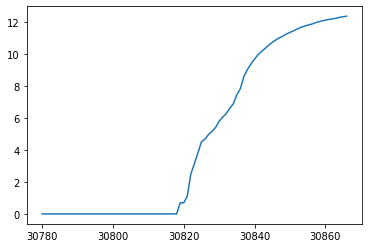

In [55]:
plt.plot(d.loc[d.Province_State=='New York','y0'])

In [56]:
# log rates
d['rate0'] = d.y0 - np.log(d['pop'])
d['rate1'] = d.y1 - np.log(d['pop'])

In [57]:
# recovered data from hopkins, https://github.com/CSSEGISandData/COVID-19
recovered = pd.read_csv(path+'time_series_covid19_recovered_global.csv')
recovered = recovered.rename(mapper={'Country/Region':'Country_Region','Province/State':'Province_State'}, axis=1)
recovered[cp] = recovered[cp].fillna('')
recovered = recovered.drop(['Lat','Long'], axis=1)
recovered

Province_State         Country_Region  1/22/20  1/23/20  \
0                                         Afghanistan        0        0   
1                                             Albania        0        0   
2                                             Algeria        0        0   
3                                             Andorra        0        0   
4                                              Angola        0        0   
..                         ...                    ...      ...      ...   
245  Saint Pierre and Miquelon                 France        0        0   
246                                       South Sudan        0        0   
247                                    Western Sahara        0        0   
248                             Sao Tome and Principe        0        0   
249                                             Yemen        0        0   

     1/24/20  ...  4/10/20  4/11/20  4/12/20  4/13/20  4/14/20  
0          0  ...       32       32       32       32       40  
1          0  ...      182      197      217      232      248  
2          0  ...      405      460      591      601      691  
3          0  ...       71       71      128      128      128  
4          0  ...        2        4        4        4        5  
..       ...  ...      ...      ...      ...      ...      ...  
245        0  ...        0        0        0        0        0  
246        0  ...        0        0        0        0        0  
247        0  ...        0        0        0        0        0  
248        0  ...        0        0        0        0        0  
249        0  ...        0        0        0        0        0  

[250 rows x 86 columns]

In [58]:
# replace US row with identical rows for every US state
usp = d.loc[d.Country_Region=='US','Province_State'].unique()
print(usp, len(usp))
rus = recovered[recovered.Country_Region=='US']
rus

['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Guam' 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Puerto Rico' 'Rhode Island'
 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont'
 'Virgin Islands' 'Virginia' 'Washington' 'West Virginia' 'Wisconsin'
 'Wyoming'] 54


Province_State Country_Region  1/22/20  1/23/20  1/24/20  ...  4/10/20  \
225                            US        0        0        0  ...    28790   

     4/11/20  4/12/20  4/13/20  4/14/20  
225    31270    32988    43482    47763  

[1 rows x 86 columns]

In [59]:
rus = rus.reindex(np.repeat(rus.index.values,len(usp)))
rus.loc[:,'Province_State'] = usp
rus

Province_State Country_Region  1/22/20  1/23/20  1/24/20  ...  4/10/20  \
225        Alabama             US        0        0        0  ...    28790   
225         Alaska             US        0        0        0  ...    28790   
225        Arizona             US        0        0        0  ...    28790   
225       Arkansas             US        0        0        0  ...    28790   
225     California             US        0        0        0  ...    28790   
..             ...            ...      ...      ...      ...  ...      ...   
225       Virginia             US        0        0        0  ...    28790   
225     Washington             US        0        0        0  ...    28790   
225  West Virginia             US        0        0        0  ...    28790   
225      Wisconsin             US        0        0        0  ...    28790   
225        Wyoming             US        0        0        0  ...    28790   

     4/11/20  4/12/20  4/13/20  4/14/20  
225    31270    32988    43482    47763  
225    31270    32988    43482    47763  
225    31270    32988    43482    47763  
225    31270    32988    43482    47763  
225    31270    32988    43482    47763  
..       ...      ...      ...      ...  
225    31270    32988    43482    47763  
225    31270    32988    43482    47763  
225    31270    32988    43482    47763  
225    31270    32988    43482    47763  
225    31270    32988    43482    47763  

[54 rows x 86 columns]

In [60]:
recovered =  recovered[recovered.Country_Region!='US']
recovered = pd.concat([recovered,rus]).reset_index(drop=True)
recovered

Province_State Country_Region  1/22/20  1/23/20  1/24/20  ...  4/10/20  \
0                     Afghanistan        0        0        0  ...       32   
1                         Albania        0        0        0  ...      182   
2                         Algeria        0        0        0  ...      405   
3                         Andorra        0        0        0  ...       71   
4                          Angola        0        0        0  ...        2   
..             ...            ...      ...      ...      ...  ...      ...   
298       Virginia             US        0        0        0  ...    28790   
299     Washington             US        0        0        0  ...    28790   
300  West Virginia             US        0        0        0  ...    28790   
301      Wisconsin             US        0        0        0  ...    28790   
302        Wyoming             US        0        0        0  ...    28790   

     4/11/20  4/12/20  4/13/20  4/14/20  
0         32       32       32       40  
1        197      217      232      248  
2        460      591      601      691  
3         71      128      128      128  
4          4        4        4        5  
..       ...      ...      ...      ...  
298    31270    32988    43482    47763  
299    31270    32988    43482    47763  
300    31270    32988    43482    47763  
301    31270    32988    43482    47763  
302    31270    32988    43482    47763  

[303 rows x 86 columns]

In [61]:
# melt and merge
rm = pd.melt(recovered, id_vars=cp, var_name='d', value_name='recov')
rm

Country_Region Province_State        d  recov
0        Afghanistan                 1/22/20      0
1            Albania                 1/22/20      0
2            Algeria                 1/22/20      0
3            Andorra                 1/22/20      0
4             Angola                 1/22/20      0
...              ...            ...      ...    ...
25447             US       Virginia  4/14/20  47763
25448             US     Washington  4/14/20  47763
25449             US  West Virginia  4/14/20  47763
25450             US      Wisconsin  4/14/20  47763
25451             US        Wyoming  4/14/20  47763

[25452 rows x 4 columns]

In [62]:
rm['Date'] = pd.to_datetime(rm.d)
rm.drop('d',axis=1,inplace=True)
rm['Date'] = rm['Date'].dt.strftime('%Y-%m-%d')
rm

Country_Region Province_State  recov        Date
0        Afghanistan                     0  2020-01-22
1            Albania                     0  2020-01-22
2            Algeria                     0  2020-01-22
3            Andorra                     0  2020-01-22
4             Angola                     0  2020-01-22
...              ...            ...    ...         ...
25447             US       Virginia  47763  2020-04-14
25448             US     Washington  47763  2020-04-14
25449             US  West Virginia  47763  2020-04-14
25450             US      Wisconsin  47763  2020-04-14
25451             US        Wyoming  47763  2020-04-14

[25452 rows x 4 columns]

In [63]:
d = d.merge(rm, how='left', on=['Country_Region','Province_State','Date'])
d

ConfirmedCases Country_Region        Date  Fatalities  ForecastId  ...  \
0                 0.0    Afghanistan  2020-01-22         0.0           0  ...   
1                 0.0    Afghanistan  2020-01-23         0.0           0  ...   
2                 0.0    Afghanistan  2020-01-24         0.0           0  ...   
3                 0.0    Afghanistan  2020-01-25         0.0           0  ...   
4                 0.0    Afghanistan  2020-01-26         0.0           0  ...   
...               ...            ...         ...         ...         ...  ...   
35677             NaN       Zimbabwe  2020-05-10         NaN       13455  ...   
35678             NaN       Zimbabwe  2020-05-11         NaN       13456  ...   
35679             NaN       Zimbabwe  2020-05-12         NaN       13457  ...   
35680             NaN       Zimbabwe  2020-05-13         NaN       13458  ...   
35681             NaN       Zimbabwe  2020-05-14         NaN       13459  ...   

       extra_y0  extra_y1      rate0      rate1  recov  
0      4.127134  1.609438 -17.477233 -17.477233    0.0  
1      4.127134  1.609438 -17.477233 -17.477233    0.0  
2      4.127134  1.609438 -17.477233 -17.477233    0.0  
3      4.127134  1.609438 -17.477233 -17.477233    0.0  
4      4.127134  1.609438 -17.477233 -17.477233    0.0  
...         ...       ...        ...        ...    ...  
35677       NaN       NaN        NaN        NaN    NaN  
35678       NaN       NaN        NaN        NaN    NaN  
35679       NaN       NaN        NaN        NaN    NaN  
35680       NaN       NaN        NaN        NaN    NaN  
35681       NaN       NaN        NaN        NaN    NaN  

[35682 rows x 52 columns]

In [64]:
d['recov'].describe()

count    25284.00000
mean      1039.58717
std       5488.78166
min          0.00000
25%          0.00000
50%          0.00000
75%         15.00000
max      68200.00000
Name: recov, dtype: float64

In [65]:
# approximate US state recovery via proportion of confirmed cases
d['ccsum'] = d.groupby(['Country_Region','Date'])['ConfirmedCases'].transform(lambda x: x.sum())
d.loc[d.Country_Region=='US','recov'] = d.loc[d.Country_Region=='US','recov'] * \
                                        d.loc[d.Country_Region=='US','ConfirmedCases'] / \
                                        (d.loc[d.Country_Region=='US','ccsum'] + 1)

In [66]:
d.loc[:,'recov'] = np.log1p(d.recov)
# d.loc[:,'recov'] = d['recov'].fillna(0)

In [67]:
# # enforce monotonicity
# d = d.sort_values(['Loc','Date']).reset_index(drop=True)
# d['recov'] = d['recov'].fillna(0.)
# d['recov'] = d.groupby('Loc')['recov'].cummax()

In [68]:
d.loc[d.Province_State=='North Carolina','recov'][45:55]

30939    0.000000
30940    0.000000
30941    0.000000
30942    0.060822
30943    0.045060
30944    0.106800
30945    0.092165
30946    0.102838
30947    0.109199
30948    0.132326
Name: recov, dtype: float64

In [69]:
d = d.sort_values(['Loc','Date']).reset_index(drop=True)
d.shape

(35682, 53)

In [70]:
# compute nearest neighbors
regions = d[['Loc','Lat','Long']].drop_duplicates('Loc').reset_index(drop=True)
regions

Loc        Lat        Long
0           Afghanistan  33.000000   65.000000
1               Albania  41.153300   20.168300
2               Algeria  28.033900    1.659600
3               Andorra  42.506300    1.521800
4                Angola  -8.830833   13.245000
..                  ...        ...         ...
308             Vietnam  16.000000  108.000000
309  West Bank and Gaza  31.703056   35.195556
310      Western Sahara  27.153611  -13.203333
311              Zambia -15.416700   28.283300
312            Zimbabwe -17.829167   31.052222

[313 rows x 3 columns]

In [71]:
# regions.to_csv('regions.csv', index=False)

In [72]:
# knn max features
k = kv[0]
nn = NearestNeighbors(k)
nn.fit(regions[['Lat','Long']])

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                 radius=1.0)

In [73]:
# first matrix is distances, second indices to nearest neighbors including self
# note two cruise ships are replicated and have identical lat, long values
knn = nn.kneighbors(regions[['Lat','Long']])
knn

(array([[ 0.      ,  5.076312,  8.387758, 12.041595, 12.754955, 14.21267 ],
        [ 0.      ,  1.602356,  1.64141 ,  1.813013,  2.658005,  2.983201],
        [ 0.      ,  9.459166,  9.524813, 10.719459, 11.640677, 12.51147 ],
        ...,
        [ 0.      ,  7.671566, 11.932639, 12.717698, 13.219696, 13.871331],
        [ 0.      ,  3.672455,  5.68374 ,  9.540685, 11.202388, 11.392633],
        [ 0.      ,  3.672455,  4.716928,  8.28029 ,  8.547124,  8.70317 ]]),
 array([[  0, 194, 306, 142, 155, 293],
        [  1, 177, 191, 153, 129, 213],
        [  2, 235, 178, 301, 171, 160],
        ...,
        [310, 178, 301, 212, 201, 125],
        [311, 312, 166,  29, 230, 179],
        [312, 311, 166, 179,  29, 109]]))

In [74]:
ns = d['Loc'].nunique()

In [75]:
# time series matrix
ky = d['y0'].values.reshape(ns,-1)
print(ky.shape)

print(ky[0])

# use knn indices to create neighbors
knny = ky[knn[1]]
print(knny.shape)

knny = knny.transpose((0,2,1)).reshape(-1,k)
print(knny.shape)

(313, 114)
[0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.693147 0.693147 0.693147 0.693147 0.693147 0.693147 0.693147
 0.693147 0.693147 0.693147 0.693147 0.693147 0.693147 1.609438 1.609438
 1.791759 2.079442 2.079442 2.079442 2.484907 2.833213 3.091042 3.135494
 3.135494 3.135494 3.218876 3.218876 3.713572 3.713572 4.317488 4.442651
 4.553877 4.70953  4.70953  4.795791 5.141664 5.164786 5.472271 5.613128
 5.641907 5.703782 5.857933 5.908083 6.049733 6.098074 6.184149 6.257668
 6.320768 6.410175 6.50129  6.572283 6.665684 6.734592 6.810142      nan
      nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan      nan      nan      nan 

In [76]:
# knn max features
nk = len(kv)
kp = []
kd = []
ns = regions.shape[0]
for k in kv:
    nn = NearestNeighbors(k)
    nn.fit(regions[['Lat','Long']])
    knn = nn.kneighbors(regions[['Lat','Long']])
    kp.append('knn'+str(k)+'_')
    kd.append('kd'+str(k)+'_')
    for i in range(ny):
        yi = 'y'+str(i)
        kc = kp[-1]+yi
        # time series matrix
        ky = d[yi].values.reshape(ns,-1)
        # use knn indices to create neighbor matrix
        km = ky[knn[1]].transpose((0,2,1)).reshape(-1,k)
        
        # take maximum value over all neighbors to approximate spreading
        d[kc] = np.amax(km, axis=1)
        print(d[kc].describe())
        print()
        
        # distance to max
        kc = kd[-1]+yi
        ki = np.argmax(km, axis=1).reshape(ns,-1)
        kw = np.zeros_like(ki).astype(float)
        # inefficient indexing, surely some way to do it faster
        for j in range(ns): 
            kw[j] = knn[0][j,ki[j]]
        d[kc] = kw.flatten()
        print(d[kc].describe())
        print()

count    27231.000000
mean         4.115836
std          3.643217
min          0.000000
25%          0.000000
50%          3.891820
75%          7.095064
max         12.348431
Name: knn6_y0, dtype: float64

count    35682.000000
mean         3.568803
std          5.649591
min          0.000000
25%          0.000000
50%          0.000000
75%          5.554110
max         40.691034
Name: kd6_y0, dtype: float64

count    27231.000000
mean         1.777090
std          2.467866
min          0.000000
25%          0.000000
50%          0.693147
75%          2.772589
max         10.032145
Name: knn6_y1, dtype: float64

count    35682.000000
mean         2.333048
std          4.695712
min          0.000000
25%          0.000000
50%          0.000000
75%          3.370625
max         40.691034
Name: kd6_y1, dtype: float64

count    27231.000000
mean         4.677326
std          3.890057
min          0.000000
25%          0.693147
50%          4.605170
75%          7.822445
max         12.34843

In [77]:
ki[j]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [78]:
# range of dates for training
# dates = d[~d.y0.isnull()]['Date'].drop_duplicates()
dates = d[d.y0.notnull()]['Date'].drop_duplicates()
dates

0     2020-01-22
1     2020-01-23
2     2020-01-24
3     2020-01-25
4     2020-01-26
         ...    
82    2020-04-13
83    2020-04-14
84    2020-04-15
85    2020-04-16
86    2020-04-17
Name: Date, Length: 87, dtype: object

In [79]:
# correlations for knn features
cols = []
for i in range(ny):
    yi = yv[i]
    cols.append(yi)
    for k in kp:
        cols.append(k+yi)
d.loc[:,cols].corr()

y0   knn6_y0  knn11_y0        y1   knn6_y1  knn11_y1
y0        1.000000  0.858271  0.842527  0.820408  0.790207  0.814169
knn6_y0   0.858271  1.000000  0.964427  0.640227  0.897657  0.894404
knn11_y0  0.842527  0.964427  1.000000  0.604546  0.835863  0.923095
y1        0.820408  0.640227  0.604546  1.000000  0.708061  0.660840
knn6_y1   0.790207  0.897657  0.835863  0.708061  1.000000  0.908192
knn11_y1  0.814169  0.894404  0.923095  0.660840  0.908192  1.000000

In [80]:
d['Date'] = pd.to_datetime(d['Date'])
d['Date'].describe()

count                   35682
unique                    114
top       2020-04-09 00:00:00
freq                      313
first     2020-01-22 00:00:00
last      2020-05-14 00:00:00
Name: Date, dtype: object

In [81]:
# days since beginning
# basedate = train['Date'].min()
# train['dint'] = train.apply(lambda x: (x.name.to_datetime() - basedate).days, axis=1)
d['dint'] = (d['Date'] - d['Date'].min()).dt.days
d['dint'].describe()

count    35682.00000
mean        56.50000
std         32.90816
min          0.00000
25%         28.00000
50%         56.50000
75%         85.00000
max        113.00000
Name: dint, dtype: float64

In [82]:
d.shape

(35682, 62)

In [83]:
# reference days since exp(j)th occurrence
for i in range(ny):
    
    for j in range(3):

        ij = str(i)+'_'+str(j)
        
        cut = 2**j if i==0 else j
        
        qd1 = (d[yv[i]] > cut) & (d[yv[i]].notnull())
        d1 = d.loc[qd1,['Loc','dint']]
        # d1.shape
        # d1.head()

        # get min for each location
        d1['dmin'] = d1.groupby('Loc')['dint'].transform(lambda x: x.min())
        # dintmax = d1['dint'].max()
        # print(i,j,'dintmax',dintmax)
        # d1.head()

        d1.drop('dint',axis=1,inplace=True)
        d1 = d1.drop_duplicates()
        d = d.merge(d1,how='left',on=['Loc'])
 
        # if dmin is missing then the series had no occurrences in the training set
        # go ahead and assume there will be one at the beginning of the test period
        # the average time between first occurrence and first death is 14 days
        # if j==0: d[dmi] = d[dmi].fillna(dintmax + 1 + i*14)

        # ref day is days since dmin, must clip at zero to avoid leakage
        d['ref_day'+ij] = np.clip(d.dint - d.dmin, 0, None)
        d['ref_day'+ij] = d['ref_day'+ij].fillna(0)
        d.drop('dmin',axis=1,inplace=True)

        # asymptotic curve may bin differently
        d['recip_day'+ij] = 1 / (1 + (1 + d['ref_day'+ij])**(-1.0))
    

gc.collect()

0

In [84]:
d['dint'].value_counts().std()

0.0

In [85]:
def ewma(x, com):
    return pd.Series.ewm(x, com=com).mean()

In [86]:
# diffs and rolling means
# note lags are taken dynamically at run time
e = 1
# r = 5
r = 7
w = 2
for i in range(ny):
    yi = 'y'+str(i)
    dd = '_d'+str(e)
    rr = '_r'+str(r)
    ww = '_w'+str(w)
    
    for j in range(5):
        d[yi+'_d'+str(1+j)] = d.groupby('Loc')[yi].transform(lambda x: x.diff(1+j))
        d[yi+'_l'+str(1+j)] = d.groupby('Loc')[yi].transform(lambda x: x.shift(1+j))
    
    d[yi+rr] = d.groupby('Loc')[yi].transform(lambda x: x.rolling(r).mean())
    d[yi+ww] = d.groupby('Loc')[yi].transform(lambda x: ewma(x,w))
    d['rate'+str(i)+dd] = d.groupby('Loc')['rate'+str(i)].transform(lambda x: x.diff(e))
    d['rate'+str(i)+rr] = d.groupby('Loc')['rate'+str(i)].transform(lambda x: x.rolling(r).mean())
    d['rate'+str(i)+ww] = d.groupby('Loc')['rate'+str(i)].transform(lambda x: ewma(x,w))
    d['extra_y'+str(i)+dd] = d.groupby('Loc')['extra_y'+str(i)].transform(lambda x: x.diff(e))
    d['extra_y'+str(i)+rr] = d.groupby('Loc')['extra_y'+str(i)].transform(lambda x: x.rolling(r).mean())
    d['extra_y'+str(i)+ww] = d.groupby('Loc')['extra_y'+str(i)].transform(lambda x: ewma(x,w))

    for k in kp:
        d[k+yi+dd] = d.groupby('Loc')[k+yi].transform(lambda x: x.diff(e))
        d[k+yi+rr] = d.groupby('Loc')[k+yi].transform(lambda x: x.rolling(r).mean())
        d[k+yi+ww] = d.groupby('Loc')[k+yi].transform(lambda x: ewma(x,w))

    for k in kd:
        d[k+yi+dd] = d.groupby('Loc')[k+yi].transform(lambda x: x.diff(e))
        d[k+yi+rr] = d.groupby('Loc')[k+yi].transform(lambda x: x.rolling(r).mean())
        d[k+yi+ww] = d.groupby('Loc')[k+yi].transform(lambda x: ewma(x,w))
        
vlist = ['recov'] + google + wf

for v in vlist:
    d[v+dd] = d.groupby('Loc')[v].transform(lambda x: x.diff(e))
    d[v+rr] = d.groupby('Loc')[v].transform(lambda x: x.rolling(r).mean())
    d[v+ww] = d.groupby('Loc')[v].transform(lambda x: ewma(x,w))

In [87]:
d['y0'+ww].describe()

count    35682.000000
mean         3.300435
std          3.221162
min          0.000000
25%          0.000000
50%          2.728936
75%          5.976664
max         12.266373
Name: y0_w2, dtype: float64

In [88]:
# final sort before training
d = d.sort_values(['Loc','dint']).reset_index(drop=True)
d.shape

(35682, 173)

In [89]:
# initial continuous and categorical features
# dogs = tfeats
# ref_day0_0 is no longer leaky since every location has at least one confirmed case
# dogs = ['ref_day0_0']
dogs = []
cats = ['Loc']
print(dogs, len(dogs))
print(cats, len(cats))

[] 0
['Loc'] 1


In [90]:
# one-hot encode categorical features
ohef = []
for i,c in enumerate(cats):
    print(c, d[c].nunique())
    ohe = pd.get_dummies(d[c], prefix=c)
    ohec = [f.translate({ord(c): "_" for c in " !@#$%^&*()[]{};:,./<>?\|`~-=_+"}) for f in list(ohe.columns)]
    ohe.columns = ohec
    d = pd.concat([d,ohe],axis=1)
    ohef = ohef + ohec

Loc 313


In [91]:
d['Loc_US_North_Carolina'].describe()

count    35682.000000
mean         0.003195
std          0.056434
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Loc_US_North_Carolina, dtype: float64

In [92]:
d['Loc_US_Colorado'].describe()

count    35682.000000
mean         0.003195
std          0.056434
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Loc_US_Colorado, dtype: float64

In [93]:
# must start cas server from gevmlax02 before running this cell
# ssh rdcgrd001 /opt/vb025/laxnd/TKGrid/bin/caslaunch stat -mode mpp -cfg /u/sasrdw/config.lua
if 'cas' in booster:
    from swat import *
    s = CAS('rdcgrd001.unx.sas.com', 16695)

In [94]:
# boosting hyperparameters
params = {}

# # from vopani
# SEED = 345
# LGB_PARAMS = {"objective": "regression",
#               "num_leaves": 5,
#               "learning_rate": 0.013,
#               "bagging_fraction": 0.91,
#               "feature_fraction": 0.81,
#               "reg_alpha": 0.13,
#               "reg_lambda": 0.13,
#               "metric": "rmse",
#               "seed": SEED
#              }

# from oscii
SEED = 42
LGB_PARAMS = {'num_leaves': 8,
          'min_data_in_leaf': 5,  # 42,
          'objective': 'regression',
          'max_depth': 8,
          'learning_rate': 0.02,
          'boosting': 'gbdt',
          'bagging_freq': 5,  # 5
          'bagging_fraction': 0.8,  # 0.5,
          'feature_fraction': 0.8201,
          'bagging_seed': SEED,
          'reg_alpha': 1,  # 1.728910519108444,
          'reg_lambda': 4.9847051755586085,
          'random_state': SEED,
          'metric': 'rmse',
          # 'verbosity': 100,
          'min_gain_to_split': 0.02,  # 0.01077313523861969,
          'min_child_weight': 5,  # 19.428902804238373,
          # 'num_threads': 6,
          }

params[('lgb','y0')] = LGB_PARAMS
params[('lgb','y1')] = LGB_PARAMS
# params[('lgb','y0')] = {'lambda_l2': 1.9079933811271934, 'max_depth': 5}
# params[('lgb','y1')] = {'lambda_l2': 1.690407455211948, 'max_depth': 3}
params[('xgb','y0')] = {'lambda_l2': 1.9079933811271934, 'max_depth': 5}
params[('xgb','y1')] = {'lambda_l2': 1.690407455211948, 'max_depth': 3}
params[('ctb','y0')] = {'l2_leaf_reg': 1.9079933811271934, 'max_depth': 5}
params[('ctb','y1')] = {'l2_leaf_reg': 1.690407455211948, 'max_depth': 3}

In [95]:
# booster = ['rdg','lgb','xgb','ctb']
# booster = ['lgb','xgb']



1 x_train (17841, 486)
1 x_val (313, 486)
1 x_full (27231, 486)
1 x_test (313, 486)

****************************************
horizon 1 y0 ConfirmedCases 2020-03-19
****************************************

                  gain
feature               
y0_d3         0.070857
knn6_y0_d1    0.068571
rate0_w2      0.059429
extra_y0_w2   0.054857
y0_d2         0.049143
google_covid  0.045714
knn6_y0       0.043429
y0_d1         0.042286
extra_y0_d1   0.041143
knn6_y0_w2    0.038857

lgb validation rmse 0.240878

lgb training with full data and predicting 2020-04-18

                  gain
feature               
knn6_y0_d1    0.088000
y0_d3         0.082286
y0_d5         0.078857
extra_y0_d1   0.064000
extra_y0_w2   0.064000
y0_d4         0.042286
knn6_y0       0.040000
rate0_d1      0.038857
rate0_w2      0.037714
google_covid  0.036571

                              gain
feature                           
y0_d2                     0.053441
Loc_Canada_Nova_Scotia    0.024120
ref_day0_2  

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                gain
feature             
knn6_y0_w2  0.076802
y0_r7       0.040605
kd6_y1_w2   0.037471
knn6_y0_r7  0.035218
y0_w2       0.033585
y1          0.033098
y1_r7       0.023900
y1_l2       0.023527
rate0       0.021466
positive    0.021144

rdg validation rmse 0.233568

rdg training with full data and predicting 2020-04-18

                gain
feature             
knn6_y0_w2  0.056893
y1          0.049348
knn6_y0_r7  0.046439
y0_r7       0.045714
y1_w2       0.042253
rate0       0.042088
y1_l3       0.042023
rate0_w2    0.033490
y0_w2       0.029406
y1_l2       0.028604

****************************************
horizon 1 y1 Fatalities 2020-03-19
****************************************

                 gain
feature              
NewCases     0.091429
y0_d3        0.057143
extra_y1_d1  0.048571
y0           0.047143
y0_d5        0.041429
y1_d1        0.035714
y0_l1        0.028571
y1_d4        0.028571
extra_y1_w2  0.028571
knn11_y0_d1  0.025714

lgb validation rmse 0.216

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
y1_w2        0.075446
y1_l1        0.047670
y1_r7        0.042192
y1_l3        0.033275
NewCases     0.032458
y1_l5        0.031571
knn11_y1_w2  0.028037
extra_y1_w2  0.027435
y1           0.024255
y1_l2        0.024203

rdg validation rmse 0.194364

rdg training with full data and predicting 2020-04-18

                 gain
feature              
knn11_y1_w2  0.077723
knn11_y1     0.072277
y1_w2        0.055857
rate1        0.039401
y1_r7        0.038695
y0           0.038100
y1_l5        0.032632
rate1_w2     0.024156
y1_l3        0.023220
y0_l5        0.021701

         Validation RMSLE   lgb xgb ctb rdg 
ConfirmedCases 	 0.229258   0.33 0.33 0.33 0.00
Fatalities 	 0.197088   0.25 0.25 0.25 0.25
Mean 	 	 0.213173


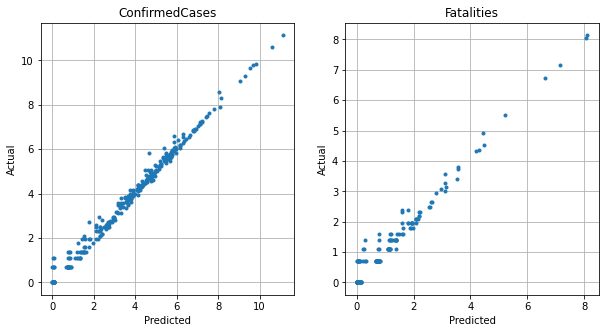



2 x_train (17841, 486)
2 x_val (313, 486)
2 x_full (27231, 486)
2 x_test (313, 486)

****************************************
horizon 2 y0 ConfirmedCases 2020-03-20
****************************************

                      gain
feature                   
knn6_y0_d1        0.074286
y0_d2             0.073143
knn6_y0           0.061714
y0_d3             0.057143
rate0_w2          0.053714
totalTestResults  0.052571
extra_y0_w2       0.052571
knn6_y0_w2        0.043429
google_covid      0.040000
extra_y1_w2       0.033143

lgb validation rmse 0.345950

lgb training with full data and predicting 2020-04-19

                      gain
feature                   
knn6_y0_d1        0.085714
extra_y0_w2       0.070857
y0_d2             0.067429
y0_d5             0.066286
y0_d3             0.061714
rate0_w2          0.051429
knn6_y0_w2        0.043429
totalTestResults  0.043429
y0_d4             0.036571
knn6_y0           0.034286

                     gain
feature                  
y0_d

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                gain
feature             
knn6_y0_w2  0.072568
y0_r7       0.042193
kd6_y1_w2   0.039096
y1          0.038543
knn6_y0_r7  0.034602
y0_w2       0.025322
positive    0.023790
y1_l2       0.023293
extra_y1    0.023076
kd6_y1_r7   0.021770

rdg validation rmse 0.344831

rdg training with full data and predicting 2020-04-19

                gain
feature             
y1          0.058726
y1_w2       0.048962
knn6_y0_w2  0.047380
y0_r7       0.044796
knn6_y0_r7  0.044510
y1_l3       0.039553
rate0       0.038064
y1_l2       0.037354
y1_l4       0.029402
rate0_w2    0.028468

****************************************
horizon 2 y1 Fatalities 2020-03-20
****************************************

                 gain
feature              
NewCases     0.077143
y0           0.075714
y0_d5        0.051429
extra_y1_w2  0.035714
y0_d2        0.034286
y0_l1        0.032857
ActiveCases  0.030000
extra_y1     0.030000
y1_d5        0.028571
knn11_y1_r7  0.028571

lgb validation rmse 0.304

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                    gain
feature                 
y1_w2           0.061867
y1_l1           0.038779
NewCases        0.038213
knn11_y1_w2     0.035205
y1              0.034172
extra_y1_w2     0.032126
knn11_y1        0.027166
rate1_w2        0.023988
TotalRecovered  0.022760
extra_y0_r7     0.021527

rdg validation rmse 0.276332

rdg training with full data and predicting 2020-04-19

                 gain
feature              
knn11_y1_w2  0.081705
knn11_y1     0.080550
y1_w2        0.055707
rate1        0.044696
y1_r7        0.032739
y0           0.030520
rate1_w2     0.029786
y1_l4        0.025024
y1           0.019819
positive     0.016548

         Validation RMSLE   lgb xgb ctb rdg 
ConfirmedCases 	 0.330602   0.33 0.33 0.33 0.00
Fatalities 	 0.277420   0.25 0.25 0.25 0.25
Mean 	 	 0.304011


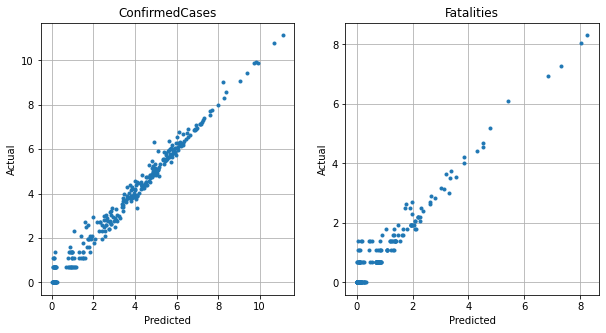



3 x_train (17841, 486)
3 x_val (313, 486)
3 x_full (27231, 486)
3 x_test (313, 486)

****************************************
horizon 3 y0 ConfirmedCases 2020-03-21
****************************************

                      gain
feature                   
y0_d2             0.072000
knn6_y0           0.064000
knn6_y0_d1        0.064000
totalTestResults  0.059429
extra_y0_w2       0.056000
rate0_w2          0.054857
google_covid      0.044571
knn6_y0_w2        0.037714
extra_y1_w2       0.036571
TotalCases        0.035429

lgb validation rmse 0.427840

lgb training with full data and predicting 2020-04-20

                      gain
feature                   
knn6_y0_d1        0.090286
extra_y0_w2       0.070857
y0_d2             0.065143
y0_d5             0.060571
rate0_w2          0.056000
TotalCases        0.050286
totalTestResults  0.049143
y0_d3             0.048000
positive          0.043429
knn6_y0_w2        0.043429

                      gain
feature                   
y0

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                gain
feature             
knn6_y0_w2  0.062193
kd6_y1_w2   0.040562
y0_r7       0.040477
y1          0.037520
knn6_y0_r7  0.035271
extra_y1    0.024646
kd6_y1_r7   0.023036
positive    0.022558
y1_l3       0.022530
y1_l2       0.022521

rdg validation rmse 0.440984

rdg training with full data and predicting 2020-04-20

                gain
feature             
y1          0.061235
y1_w2       0.047812
knn6_y0_r7  0.045872
y0_r7       0.044743
knn6_y0_w2  0.041537
y1_l3       0.040838
y1_l2       0.039333
rate0       0.031025
knn6_y0     0.029254
positive    0.026658

****************************************
horizon 3 y1 Fatalities 2020-03-21
****************************************

                 gain
feature              
NewCases     0.107143
y0           0.097143
extra_y1     0.050000
y0_d5        0.044286
extra_y1_w2  0.042857
positive     0.041429
medianage    0.031429
y0_l1        0.027143
y0_d4        0.025714
y0_d3        0.024286

lgb validation rmse 0.391

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                    gain
feature                 
y1_w2           0.058767
y1              0.045941
NewCases        0.044520
extra_y1_w2     0.044251
knn11_y1_w2     0.037524
knn11_y1        0.033569
rate1_w2        0.026158
extra_y1        0.025329
extra_y0_w2     0.023984
TotalRecovered  0.022785

rdg validation rmse 0.355742

rdg training with full data and predicting 2020-04-20

                 gain
feature              
knn11_y1     0.075254
knn11_y1_w2  0.072497
y1_w2        0.053218
rate1        0.040606
y1_r7        0.038180
y0           0.033718
rate1_w2     0.026005
y0_r7        0.020895
y1           0.019904
extra_y1_w2  0.019265

         Validation RMSLE   lgb xgb ctb rdg 
ConfirmedCases 	 0.405278   0.33 0.33 0.33 0.00
Fatalities 	 0.365026   0.25 0.25 0.25 0.25
Mean 	 	 0.385152


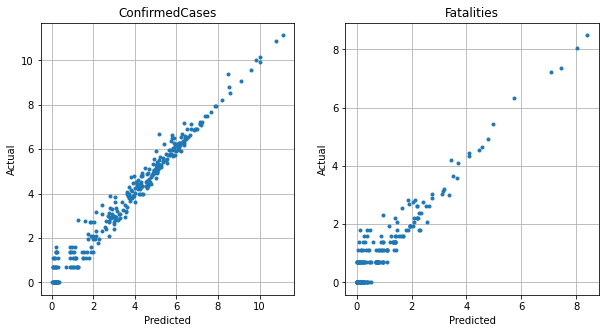



4 x_train (17841, 486)
4 x_val (313, 486)
4 x_full (27231, 486)
4 x_test (313, 486)

****************************************
horizon 4 y0 ConfirmedCases 2020-03-22
****************************************

                      gain
feature                   
knn6_y0           0.065143
y0_d2             0.062857
knn6_y0_d1        0.059429
extra_y0_w2       0.054857
google_covid      0.051429
totalTestResults  0.046857
positive          0.045714
rate0_w2          0.044571
TotalCases        0.038857
kd6_y0            0.033143

lgb validation rmse 0.505135

lgb training with full data and predicting 2020-04-21

                      gain
feature                   
knn6_y0_d1        0.081143
extra_y0_w2       0.070857
totalTestResults  0.060571
y0_d2             0.054857
y0_d5             0.049143
positive          0.048000
TotalCases        0.045714
google_covid      0.045714
y0_d3             0.045714
rate0_w2          0.036571

                      gain
feature                   
y0

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                gain
feature             
knn6_y0_w2  0.048842
kd6_y1_w2   0.046183
y0_r7       0.038046
y1          0.037080
knn6_y0_r7  0.033709
y1_l2       0.029804
kd6_y1_r7   0.025794
positive    0.024191
knn6_y0     0.022110
kd6_y1      0.021802

rdg validation rmse 0.530341

rdg training with full data and predicting 2020-04-21

                gain
feature             
y1          0.061307
y1_w2       0.047217
knn6_y0_r7  0.044962
y0_r7       0.044508
y1_l2       0.041736
knn6_y0     0.041621
y1_l3       0.037112
knn6_y0_w2  0.030460
rate0       0.029281
positive    0.028453

****************************************
horizon 4 y1 Fatalities 2020-03-22
****************************************

                     gain
feature                  
NewCases         0.100000
y0               0.095714
extra_y1         0.054286
y0_d2            0.052857
extra_y1_w2      0.052857
y0_d5            0.037143
medianage        0.031429
positive         0.027143
Loc_China_Hubei  0.024286
y0_d

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
y1_w2        0.055364
extra_y1_w2  0.044417
NewCases     0.039628
knn11_y1_w2  0.039532
knn11_y1     0.037846
y1           0.033974
rate0        0.031128
extra_y0_w2  0.029839
extra_y1     0.024451
rate1_w2     0.023274

rdg validation rmse 0.429022

rdg training with full data and predicting 2020-04-21

                 gain
feature              
knn11_y1     0.074869
knn11_y1_w2  0.067891
y1_w2        0.052904
y0           0.040110
y1_r7        0.039353
rate1        0.035814
y0_r7        0.023751
rate1_w2     0.023706
extra_y0     0.022264
extra_y1_w2  0.019074

         Validation RMSLE   lgb xgb ctb rdg 
ConfirmedCases 	 0.475580   0.33 0.33 0.33 0.00
Fatalities 	 0.438150   0.25 0.25 0.25 0.25
Mean 	 	 0.456865


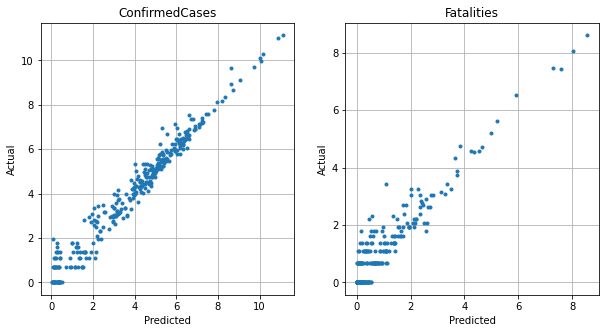



5 x_train (17841, 486)
5 x_val (313, 486)
5 x_full (27231, 486)
5 x_test (313, 486)

****************************************
horizon 5 y0 ConfirmedCases 2020-03-23
****************************************

                      gain
feature                   
knn6_y0           0.077714
y0_d2             0.066286
knn6_y0_d1        0.060571
extra_y0_w2       0.060571
positive          0.052571
google_covid      0.050286
totalTestResults  0.050286
TotalCases        0.050286
rate1_r7          0.045714
rate0_w2          0.042286

lgb validation rmse 0.567160

lgb training with full data and predicting 2020-04-22

                      gain
feature                   
knn6_y0_d1        0.085714
extra_y0_w2       0.083429
totalTestResults  0.061714
positive          0.058286
y0_d2             0.054857
TotalCases        0.051429
google_covid      0.046857
y0_d3             0.042286
knn6_y0           0.040000
y0_d5             0.037714

                     gain
feature                  
y0_d

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                gain
feature             
kd6_y1_w2   0.049108
knn6_y0_w2  0.040773
y1          0.035990
y0_r7       0.034593
knn6_y0_r7  0.031130
knn6_y0     0.030829
kd6_y1_r7   0.027516
positive    0.024112
kd6_y1      0.023275
y0_w2       0.022534

rdg validation rmse 0.610589

rdg training with full data and predicting 2020-04-22

                gain
feature             
y1          0.059923
knn6_y0     0.049247
y1_w2       0.044330
knn6_y0_r7  0.043907
y0_r7       0.043022
y1_l2       0.039684
y1_l3       0.034269
positive    0.029952
rate0       0.028472
kd6_y1_w2   0.024740

****************************************
horizon 5 y1 Fatalities 2020-03-23
****************************************

                       gain
feature                    
y0                 0.105714
NewCases           0.090000
extra_y1_w2        0.071429
y0_d5              0.048571
extra_y1           0.044286
medianage          0.042857
Loc_China_Hubei    0.040000
y0_d2              0.035714
Loc_US_Was

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
extra_y1_w2  0.049963
y1_w2        0.047727
knn11_y1_w2  0.042510
rate0        0.040452
knn11_y1     0.040334
NewCases     0.038007
extra_y0_w2  0.037238
extra_y1     0.029310
y1           0.027824
y0           0.026550

rdg validation rmse 0.488184

rdg training with full data and predicting 2020-04-22

                 gain
feature              
knn11_y1     0.075368
knn11_y1_w2  0.066398
y1_w2        0.049478
y0           0.045710
y1_r7        0.038456
rate1        0.032233
extra_y0     0.027831
extra_y1_w2  0.025866
y0_r7        0.024606
extra_y1     0.021205

         Validation RMSLE   lgb xgb ctb rdg 
ConfirmedCases 	 0.549066   0.33 0.33 0.33 0.00
Fatalities 	 0.492909   0.25 0.25 0.25 0.25
Mean 	 	 0.520988


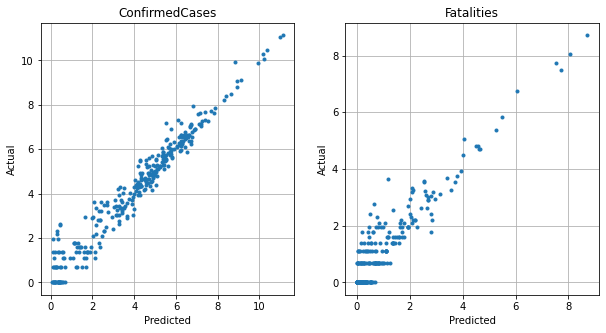



6 x_train (17841, 486)
6 x_val (313, 486)
6 x_full (27231, 486)
6 x_test (313, 486)

****************************************
horizon 6 y0 ConfirmedCases 2020-03-24
****************************************

                  gain
feature               
knn6_y0       0.075429
positive      0.064000
y0_d2         0.064000
knn6_y0_d1    0.058286
google_covid  0.056000
extra_y0_w2   0.052571
rate1_r7      0.051429
TotalCases    0.048000
extra_y1_w2   0.045714
kd6_y0        0.040000

lgb validation rmse 0.627925

lgb training with full data and predicting 2020-04-23

                      gain
feature                   
extra_y0_w2       0.082286
knn6_y0_d1        0.077714
totalTestResults  0.070857
positive          0.053714
google_covid      0.052571
TotalCases        0.048000
y0_d2             0.043429
y0_d3             0.042286
knn6_y0_w2        0.035429
rate0_w2          0.034286

                      gain
feature                   
y0_d2             0.073415
y0_d3             0.053

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                gain
feature             
kd6_y1_w2   0.049523
knn6_y0     0.041184
y0_r7       0.034113
y1          0.032345
knn6_y0_w2  0.031822
knn6_y0_r7  0.030031
kd6_y1_r7   0.028327
positive    0.023067
kd6_y1      0.022898
rate0_w2    0.022186

rdg validation rmse 0.697531

rdg training with full data and predicting 2020-04-23

                gain
feature             
knn6_y0     0.057880
y1          0.056657
knn6_y0_r7  0.042525
y0_r7       0.041927
y1_w2       0.041046
y1_l2       0.037860
y1_l3       0.031709
positive    0.031118
rate0       0.028087
kd6_y1_w2   0.024431

****************************************
horizon 6 y1 Fatalities 2020-03-24
****************************************

                       gain
feature                    
y0                 0.087143
NewCases           0.087143
y0_d5              0.068571
Loc_China_Hubei    0.057143
extra_y1           0.055714
extra_y1_w2        0.052857
medianage          0.042857
Loc_US_Washington  0.035714
y0_d2     

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
extra_y1_w2  0.051911
rate0        0.047541
y1_w2        0.041004
extra_y0_w2  0.039291
knn11_y1_w2  0.038690
NewCases     0.037937
knn11_y1     0.036990
y0_w2        0.033206
y1           0.031240
y0           0.031191

rdg validation rmse 0.548942

rdg training with full data and predicting 2020-04-23

                 gain
feature              
knn11_y1     0.071998
knn11_y1_w2  0.062723
y0           0.051134
y1_w2        0.041523
y1_r7        0.034778
extra_y1_w2  0.029368
extra_y0     0.029185
rate1        0.028070
y0_r7        0.024673
extra_y1     0.023765

         Validation RMSLE   lgb xgb ctb rdg 
ConfirmedCases 	 0.600455   0.33 0.33 0.33 0.00
Fatalities 	 0.551460   0.25 0.25 0.25 0.25
Mean 	 	 0.575958


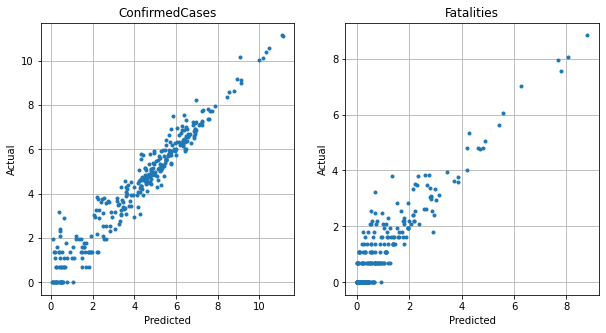



7 x_train (17841, 486)
7 x_val (313, 486)
7 x_full (27231, 486)
7 x_test (313, 486)

****************************************
horizon 7 y0 ConfirmedCases 2020-03-25
****************************************

                  gain
feature               
knn6_y0       0.072000
google_covid  0.065143
extra_y0_w2   0.065143
knn6_y0_d1    0.064000
positive      0.058286
rate1_r7      0.053714
TotalCases    0.051429
extra_y1_w2   0.048000
kd6_y0        0.046857
y0_d2         0.044571

lgb validation rmse 0.695943

lgb training with full data and predicting 2020-04-24

                      gain
feature                   
extra_y0_w2       0.085714
totalTestResults  0.076571
knn6_y0_d1        0.075429
TotalCases        0.057143
google_covid      0.057143
y0_d2             0.045714
positive          0.044571
knn6_y0           0.041143
y0_d3             0.038857
y0_d4             0.034286

                          gain
feature                       
y0_d2                 0.075988
positive   

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                gain
feature             
knn6_y0     0.049547
kd6_y1_w2   0.046018
y0_r7       0.032784
y1          0.032455
knn6_y0_r7  0.028083
kd6_y1_r7   0.026672
rate0_w2    0.024626
knn6_y0_w2  0.022102
ref_day0_0  0.021361
kd6_y1      0.020748

rdg validation rmse 0.793857

rdg training with full data and predicting 2020-04-24

                gain
feature             
knn6_y0     0.064757
y1          0.053616
y1_w2       0.041074
y0_r7       0.040864
knn6_y0_r7  0.040658
y1_l2       0.035737
positive    0.031299
y1_l3       0.030495
rate0       0.027978
kd6_y1_w2   0.023977

****************************************
horizon 7 y1 Fatalities 2020-03-25
****************************************

                       gain
feature                    
y0                 0.108571
NewCases           0.084286
y0_d5              0.071429
Loc_China_Hubei    0.064286
extra_y1_w2        0.052857
extra_y1           0.051429
medianage          0.048571
Loc_US_Washington  0.037143
extra_y1_r

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
extra_y1_w2  0.057963
rate0        0.051572
extra_y0_w2  0.041634
NewCases     0.039436
knn11_y1_w2  0.038118
y0_w2        0.037891
y0           0.037381
y1_w2        0.037047
knn11_y1     0.036242
extra_y1     0.036110

rdg validation rmse 0.612183

rdg training with full data and predicting 2020-04-24

                 gain
feature              
knn11_y1     0.069699
knn11_y1_w2  0.060502
y0           0.058012
y1_w2        0.039915
extra_y1_w2  0.034524
y1_r7        0.033553
extra_y0     0.030351
extra_y1     0.028501
y0_w2        0.028312
y0_r7        0.025071

         Validation RMSLE   lgb xgb ctb rdg 
ConfirmedCases 	 0.654221   0.33 0.33 0.33 0.00
Fatalities 	 0.618304   0.25 0.25 0.25 0.25
Mean 	 	 0.636262


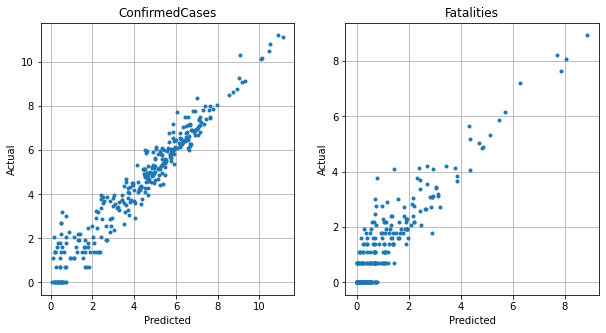



8 x_train (17841, 486)
8 x_val (313, 486)
8 x_full (27231, 486)
8 x_test (313, 486)

****************************************
horizon 8 y0 ConfirmedCases 2020-03-26
****************************************

                      gain
feature                   
TotalCases        0.073143
google_covid      0.070857
extra_y0_w2       0.067429
positive          0.067429
knn6_y0_d1        0.061714
knn6_y0           0.057143
rate1_r7          0.056000
y0_d2             0.051429
extra_y1_w2       0.041143
totalTestResults  0.041143

lgb validation rmse 0.785575

lgb training with full data and predicting 2020-04-25

                      gain
feature                   
totalTestResults  0.090286
extra_y0_w2       0.084571
knn6_y0_d1        0.076571
google_covid      0.064000
TotalCases        0.061714
knn6_y0           0.045714
positive          0.042286
y0_d2             0.038857
y0_d4             0.034286
y0_d3             0.034286

                      gain
feature                   
y0

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
knn6_y0      0.058667
kd6_y1_w2    0.044038
y1           0.032237
y0_r7        0.032094
knn6_y0_r7   0.026778
rate0_w2     0.025427
kd6_y1_r7    0.024830
ref_day0_0   0.021134
kd6_y1       0.020415
extra_y1_r7  0.020022

rdg validation rmse 0.911036

rdg training with full data and predicting 2020-04-25

                gain
feature             
knn6_y0     0.069120
y1          0.050284
y1_w2       0.039840
knn6_y0_r7  0.039522
y0_r7       0.039187
y1_l2       0.035430
positive    0.030789
y1_l3       0.030455
rate0       0.027565
kd6_y1_w2   0.025139

****************************************
horizon 8 y1 Fatalities 2020-03-26
****************************************

                     gain
feature                  
y0_d5            0.078571
NewCases         0.068571
Loc_China_Hubei  0.067143
y0               0.062857
extra_y1_w2      0.061429
medianage        0.047143
extra_y1_r7      0.041429
y0_w2            0.035714
y0_d2            0

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
extra_y1_w2  0.064194
rate0        0.055738
y0_w2        0.045161
extra_y1     0.043773
NewCases     0.043150
y0           0.042486
extra_y0_w2  0.041038
knn11_y1_w2  0.038832
rate0_w2     0.038800
knn11_y1     0.035245

rdg validation rmse 0.669472

rdg training with full data and predicting 2020-04-25

                 gain
feature              
knn11_y1     0.065740
y0           0.061021
knn11_y1_w2  0.057468
extra_y1_w2  0.040117
y0_w2        0.036304
y1_w2        0.035683
extra_y1     0.033789
y1_r7        0.033028
extra_y0     0.031613
rate0_w2     0.028241

         Validation RMSLE   lgb xgb ctb rdg 
ConfirmedCases 	 0.740420   0.33 0.33 0.33 0.00
Fatalities 	 0.682084   0.25 0.25 0.25 0.25
Mean 	 	 0.711252


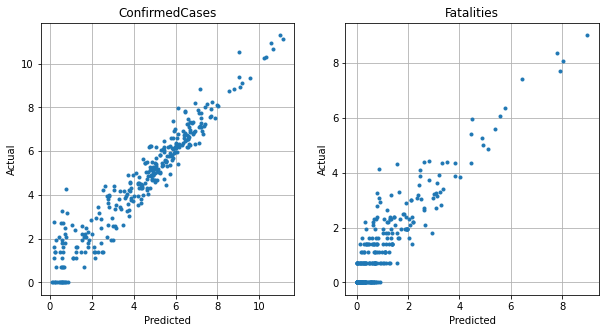



9 x_train (17841, 486)
9 x_val (313, 486)
9 x_full (27231, 486)
9 x_test (313, 486)

****************************************
horizon 9 y0 ConfirmedCases 2020-03-27
****************************************

                  gain
feature               
TotalCases    0.081143
google_covid  0.078857
extra_y0_w2   0.067429
knn6_y0       0.061714
knn6_y0_d1    0.059429
rate1_r7      0.056000
y0_d2         0.056000
positive      0.052571
kd6_y0        0.045714
extra_y1_w2   0.043429

lgb validation rmse 0.850791

lgb training with full data and predicting 2020-04-26

                      gain
feature                   
totalTestResults  0.094857
extra_y0_w2       0.089143
knn6_y0_d1        0.076571
TotalCases        0.064000
google_covid      0.062857
knn6_y0           0.044571
rate1_r7          0.038857
kd6_y0            0.037714
positive          0.034286
y0_d2             0.034286

                          gain
feature                       
y0_d2                 0.069079
Loc_China_T

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                gain
feature             
knn6_y0     0.059323
kd6_y1_w2   0.040768
y1          0.033374
y0_r7       0.031373
rate0_w2    0.026843
knn6_y0_r7  0.025426
kd6_y1_r7   0.022701
ref_day0_0  0.021312
y1_l2       0.020352
extra_y0    0.020255

rdg validation rmse 1.029202

rdg training with full data and predicting 2020-04-26

                gain
feature             
knn6_y0     0.070392
y1          0.048089
knn6_y0_r7  0.038350
y1_w2       0.038258
y0_r7       0.038186
y1_l2       0.035896
positive    0.029901
y1_l3       0.028090
rate0       0.026303
kd6_y1_w2   0.025223

****************************************
horizon 9 y1 Fatalities 2020-03-27
****************************************

                       gain
feature                    
Loc_China_Hubei    0.078571
y0_d5              0.071429
y0                 0.062857
NewCases           0.061429
extra_y1_w2        0.060000
extra_y1           0.047143
extra_y1_r7        0.045714
medianage          0.038571
knn11_y1  

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
extra_y1_w2  0.065822
rate0        0.056392
y0_w2        0.047839
extra_y1     0.047795
NewCases     0.045249
extra_y0_w2  0.042885
y0           0.042506
rate0_w2     0.041553
knn11_y1_w2  0.036694
knn11_y1     0.033495

rdg validation rmse 0.727831

rdg training with full data and predicting 2020-04-26

                 gain
feature              
y0           0.059838
knn11_y1     0.058294
knn11_y1_w2  0.050626
extra_y1_w2  0.044623
y0_w2        0.039697
extra_y1     0.038010
extra_y0     0.034684
y1_r7        0.032958
rate0_w2     0.031329
y1_w2        0.031046

         Validation RMSLE   lgb xgb ctb rdg 
ConfirmedCases 	 0.793085   0.33 0.33 0.33 0.00
Fatalities 	 0.749110   0.25 0.25 0.25 0.25
Mean 	 	 0.771098


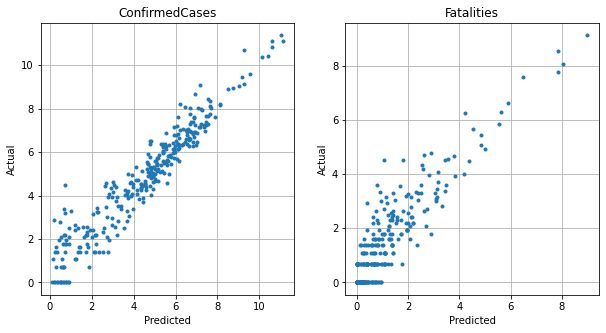



10 x_train (17841, 486)
10 x_val (313, 486)
10 x_full (27231, 486)
10 x_test (313, 486)

****************************************
horizon 10 y0 ConfirmedCases 2020-03-28
****************************************

                  gain
feature               
google_covid  0.083429
rate1_r7      0.074286
TotalCases    0.073143
knn6_y0       0.066286
extra_y0_w2   0.060571
positive      0.056000
knn6_y0_d1    0.056000
y0_d2         0.048000
extra_y1_w2   0.044571
kd6_y0        0.037714

lgb validation rmse 0.893987

lgb training with full data and predicting 2020-04-27

                      gain
feature                   
totalTestResults  0.091429
extra_y0_w2       0.089143
knn6_y0_d1        0.070857
google_covid      0.067429
TotalCases        0.064000
knn6_y0           0.046857
rate1_r7          0.040000
y0_d2             0.038857
positive          0.034286
extra_y1_w2       0.029714

                          gain
feature                       
y1_l3                 0.053428
Loc_Ch

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                gain
feature             
knn6_y0     0.058118
kd6_y1_w2   0.036907
y1          0.033964
y0_r7       0.030417
rate0_w2    0.026776
knn6_y0_r7  0.024957
ref_day0_0  0.021720
TotalCases  0.021433
extra_y0    0.020406
kd6_y1_r7   0.020186

rdg validation rmse 1.171521

rdg training with full data and predicting 2020-04-27

                gain
feature             
knn6_y0     0.071523
y1          0.045255
knn6_y0_r7  0.037955
y0_r7       0.037472
y1_w2       0.035666
y1_l2       0.033752
positive    0.029026
y1_l3       0.025088
rate0       0.024774
kd6_y1_w2   0.024641

****************************************
horizon 10 y1 Fatalities 2020-03-28
****************************************

                     gain
feature                  
Loc_China_Hubei  0.080000
y0_d5            0.061429
extra_y1_w2      0.055714
extra_y1_r7      0.054286
medianage        0.052857
y0               0.052857
knn11_y1         0.045714
y0_l1            0.038571
NewCases         0.035714
Tot

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
extra_y1_w2  0.069938
extra_y1     0.055819
rate0        0.050249
NewCases     0.043378
extra_y0_w2  0.043294
y0_w2        0.043210
rate0_w2     0.039914
y0           0.039303
extra_y0     0.036714
knn11_y1_w2  0.033872

rdg validation rmse 0.770989

rdg training with full data and predicting 2020-04-27

                 gain
feature              
y0           0.058433
knn11_y1     0.055870
knn11_y1_w2  0.048862
extra_y1_w2  0.048010
y0_w2        0.041552
extra_y1     0.040674
y1_r7        0.035275
extra_y0     0.035048
rate0        0.033825
rate0_w2     0.033370

         Validation RMSLE   lgb xgb ctb rdg 
ConfirmedCases 	 0.829626   0.33 0.33 0.33 0.00
Fatalities 	 0.816675   0.25 0.25 0.25 0.25
Mean 	 	 0.823150


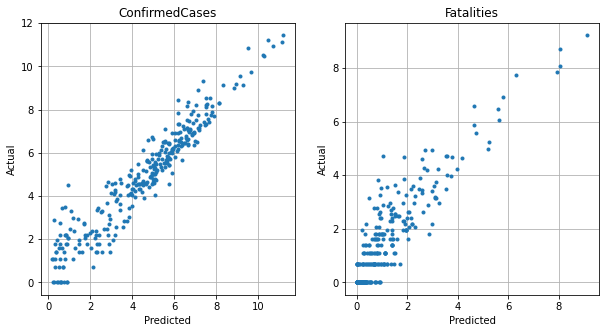



11 x_train (17841, 486)
11 x_val (313, 486)
11 x_full (27231, 486)
11 x_test (313, 486)

****************************************
horizon 11 y0 ConfirmedCases 2020-03-29
****************************************

                  gain
feature               
TotalCases    0.088000
google_covid  0.082286
rate1_r7      0.068571
extra_y0_w2   0.059429
knn6_y0       0.056000
y0_d2         0.053714
knn6_y0_d1    0.052571
positive      0.051429
extra_y1_w2   0.045714
kd6_y0        0.035429

lgb validation rmse 0.959785

lgb training with full data and predicting 2020-04-28

                      gain
feature                   
totalTestResults  0.089143
extra_y0_w2       0.088000
TotalCases        0.070857
google_covid      0.069714
knn6_y0_d1        0.065143
rate1_r7          0.052571
knn6_y0           0.046857
kd6_y0            0.040000
positive          0.035429
y0_d3             0.034286

                      gain
feature                   
extra_y0_w2       0.050230
knn6_y0_d1        

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                    gain
feature                 
knn6_y0         0.058800
y1              0.035370
y0_r7           0.032047
kd6_y1_w2       0.029150
rate0_w2        0.026585
knn6_y0_r7      0.025923
TotalCases      0.025863
ref_day0_0      0.022805
TotalRecovered  0.021539
extra_y1_r7     0.019235

rdg validation rmse 1.318741

rdg training with full data and predicting 2020-04-28

                gain
feature             
knn6_y0     0.074207
y1          0.042946
y0_r7       0.038881
knn6_y0_r7  0.038561
y1_w2       0.032723
y1_l2       0.031824
positive    0.028698
y1_l3       0.024485
rate0       0.022376
kd6_y1_w2   0.019442

****************************************
horizon 11 y1 Fatalities 2020-03-29
****************************************

                     gain
feature                  
Loc_China_Hubei  0.091429
extra_y1_r7      0.078571
y0               0.068571
y0_d5            0.057143
medianage        0.051429
ref_day0_0       0.045714
extra_y1_w2      0.038571
knn11_y

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
extra_y1_w2  0.070235
extra_y1     0.056326
NewCases     0.045826
y0           0.044124
y0_w2        0.043595
rate0        0.043542
extra_y0_w2  0.041824
rate0_w2     0.041419
knn11_y1_w2  0.035666
extra_y0     0.035571

rdg validation rmse 0.806104

rdg training with full data and predicting 2020-04-28

                 gain
feature              
y0           0.060079
knn11_y1     0.053194
extra_y1_w2  0.049874
knn11_y1_w2  0.048004
y0_w2        0.045662
extra_y1     0.041177
rate0        0.036194
rate0_w2     0.034991
extra_y0     0.034483
y1_r7        0.032722

         Validation RMSLE   lgb xgb ctb rdg 
ConfirmedCases 	 0.883000   0.33 0.33 0.33 0.00
Fatalities 	 0.869522   0.25 0.25 0.25 0.25
Mean 	 	 0.876261


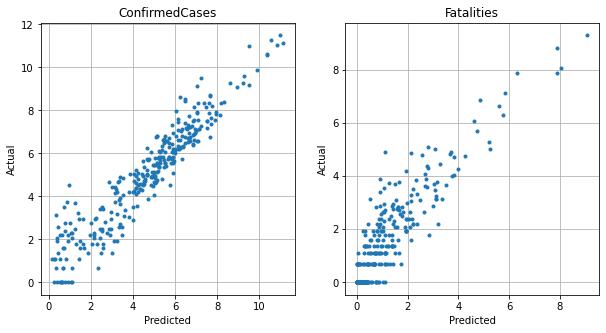



12 x_train (17841, 486)
12 x_val (313, 486)
12 x_full (27231, 486)
12 x_test (313, 486)

****************************************
horizon 12 y0 ConfirmedCases 2020-03-30
****************************************

                  gain
feature               
TotalCases    0.096000
google_covid  0.075429
rate1_r7      0.072000
knn6_y0       0.060571
knn6_y0_d1    0.050286
extra_y1_w2   0.049143
y0_d2         0.049143
extra_y0_w2   0.046857
knn6_y0_w2    0.044571
kd6_y0        0.041143

lgb validation rmse 0.999849

lgb training with full data and predicting 2020-04-29

                      gain
feature                   
totalTestResults  0.092571
extra_y0_w2       0.083429
google_covid      0.081143
TotalCases        0.069714
knn6_y0_d1        0.068571
rate1_r7          0.058286
knn6_y0           0.046857
kd6_y0            0.036571
y0_d3             0.036571
extra_y1_w2       0.035429

                 gain
feature              
y0_l5        0.085878
extra_y0_w2  0.082146
y1_l3      

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                    gain
feature                 
knn6_y0         0.052671
y1              0.035162
y0_r7           0.031622
TotalCases      0.030196
knn6_y0_r7      0.027035
TotalRecovered  0.024137
kd6_y1_w2       0.023366
ref_day0_0      0.023175
rate0_w2        0.022796
extra_y1_r7     0.018852

rdg validation rmse 1.461381

rdg training with full data and predicting 2020-04-29


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                gain
feature             
knn6_y0     0.076893
y1          0.040407
y0_r7       0.039280
knn6_y0_r7  0.038575
y1_l2       0.031370
y1_w2       0.031310
positive    0.028056
y1_l3       0.022956
rate0       0.021537
y1_r7       0.020872

****************************************
horizon 12 y1 Fatalities 2020-03-30
****************************************

                     gain
feature                  
Loc_China_Hubei  0.091429
extra_y1_r7      0.065714
y0_d5            0.064286
ref_day0_0       0.057143
medianage        0.051429
y0               0.051429
knn11_y1         0.044286
TotalCases       0.040000
y0_w2            0.035714
y0_d2            0.032857

lgb validation rmse 1.085945

lgb training with full data and predicting 2020-04-29

                      gain
feature                   
y0_d5             0.112857
y0                0.110000
extra_y1_w2       0.107143
rate1_r7          0.060000
extra_y0          0.054286
extra_y1          0.047143
positive     

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
extra_y1_w2  0.073010
extra_y1     0.062414
NewCases     0.044738
extra_y0_w2  0.043283
extra_y0     0.040226
y0           0.039970
y0_w2        0.037728
rate0_w2     0.035348
knn11_y1_w2  0.034341
rate0        0.034308

rdg validation rmse 0.853417

rdg training with full data and predicting 2020-04-29


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
y0           0.058100
extra_y1_w2  0.053690
knn11_y1     0.049260
y0_w2        0.045994
knn11_y1_w2  0.045756
extra_y1     0.043732
rate0        0.038891
rate0_w2     0.035904
extra_y0     0.035111
y1_r7        0.031365

         Validation RMSLE   lgb xgb ctb rdg 
ConfirmedCases 	 0.908948   0.33 0.33 0.33 0.00
Fatalities 	 0.930457   0.25 0.25 0.25 0.25
Mean 	 	 0.919703


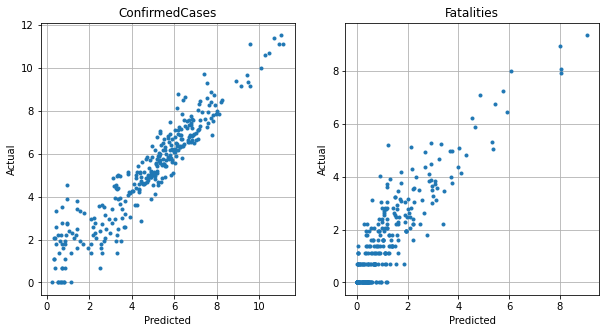



13 x_train (17841, 486)
13 x_val (313, 486)
13 x_full (27231, 486)
13 x_test (313, 486)

****************************************
horizon 13 y0 ConfirmedCases 2020-03-31
****************************************

                  gain
feature               
TotalCases    0.092571
google_covid  0.078857
rate1_r7      0.067429
knn6_y0       0.056000
extra_y0_w2   0.053714
knn6_y0_d1    0.050286
y0_d2         0.046857
knn6_y0_w2    0.041143
kd6_y0        0.038857
extra_y1_w2   0.035429

lgb validation rmse 1.061911

lgb training with full data and predicting 2020-04-30

                      gain
feature                   
extra_y0_w2       0.093714
totalTestResults  0.091429
google_covid      0.088000
knn6_y0_d1        0.064000
TotalCases        0.062857
rate1_r7          0.052571
knn6_y0           0.051429
rate0_r7          0.033143
kd6_y0            0.033143
y0_d3             0.033143

                      gain
feature                   
extra_y0_w2       0.076458
knn6_y0_d1        

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                    gain
feature                 
knn6_y0         0.043314
y1              0.035289
TotalCases      0.033614
y0_r7           0.030726
knn6_y0_r7      0.027760
TotalRecovered  0.027256
ref_day0_0      0.023415
knn6_y0_w2      0.023306
negative        0.020046
ref_day0_1      0.019265

rdg validation rmse 1.643558

rdg training with full data and predicting 2020-04-30


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                gain
feature             
knn6_y0     0.076989
y0_r7       0.039303
knn6_y0_r7  0.038477
y1          0.038268
y1_l2       0.030139
y1_w2       0.029550
positive    0.027805
y1_l3       0.021508
y1_r7       0.021348
rate0       0.020821

****************************************
horizon 13 y1 Fatalities 2020-03-31
****************************************

                     gain
feature                  
Loc_China_Hubei  0.094286
extra_y1_r7      0.092857
y0_d5            0.064286
ref_day0_0       0.057143
medianage        0.048571
y0               0.047143
rh               0.038571
TotalCases       0.032857
y0_d2            0.032857
knn11_y1         0.031429

lgb validation rmse 1.216966

lgb training with full data and predicting 2020-04-30

                      gain
feature                   
y0_d5             0.125714
y0                0.107143
extra_y1_w2       0.102857
extra_y0          0.064286
rate1_r7          0.055714
totalTestResults  0.041429
extra_y0_d1  

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
extra_y1_w2  0.072119
extra_y1     0.063717
NewCases     0.041781
extra_y0_w2  0.041134
extra_y0     0.039132
y0           0.036422
knn11_y1_w2  0.035879
y0_w2        0.034477
knn11_y1     0.033597
extra_y1_r7  0.032091

rdg validation rmse 0.908098

rdg training with full data and predicting 2020-04-30


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
extra_y1_w2  0.057855
y0           0.055675
extra_y1     0.046071
y0_w2        0.045790
knn11_y1     0.043311
knn11_y1_w2  0.041399
rate0        0.041190
rate0_w2     0.036784
extra_y0     0.035385
extra_y0_w2  0.032441

         Validation RMSLE   lgb xgb ctb rdg 
ConfirmedCases 	 0.954812   0.33 0.33 0.33 0.00
Fatalities 	 0.995294   0.25 0.25 0.25 0.25
Mean 	 	 0.975053


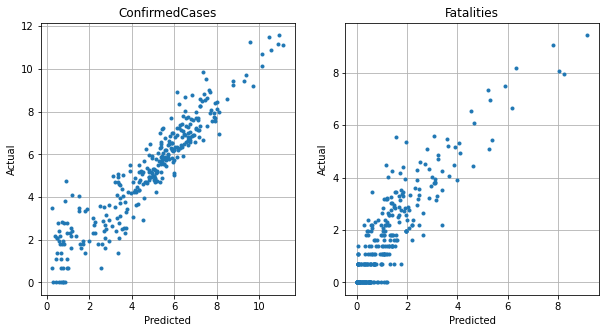



14 x_train (17841, 486)
14 x_val (313, 486)
14 x_full (27231, 486)
14 x_test (313, 486)

****************************************
horizon 14 y0 ConfirmedCases 2020-04-01
****************************************

                  gain
feature               
TotalCases    0.084571
rate1_r7      0.080000
google_covid  0.080000
knn6_y0       0.060571
knn6_y0_d1    0.054857
extra_y0_w2   0.048000
knn6_y0_w2    0.044571
y0_d2         0.037714
rate0_r7      0.034286
extra_y1_w2   0.033143

lgb validation rmse 1.172072

lgb training with full data and predicting 2020-05-01

                      gain
feature                   
extra_y0_w2       0.100571
totalTestResults  0.089143
google_covid      0.088000
rate1_r7          0.069714
TotalCases        0.062857
knn6_y0_d1        0.060571
knn6_y0           0.049143
kd6_y0            0.040000
y0_d3             0.036571
extra_y1_w2       0.029714

                     gain
feature                  
extra_y0_w2      0.089462
recov            0.04

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                    gain
feature                 
TotalCases      0.038045
knn6_y0         0.038013
y1              0.032216
TotalRecovered  0.031154
y0_r7           0.030710
knn6_y0_r7      0.029207
knn6_y0_w2      0.029191
ref_day0_0      0.023598
ref_day0_1      0.019630
extra_y1_r7     0.018169

rdg validation rmse 1.798955

rdg training with full data and predicting 2020-05-01


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                gain
feature             
knn6_y0     0.077695
y0_r7       0.039733
knn6_y0_r7  0.038384
y1          0.034770
y1_l2       0.028961
y1_w2       0.028838
positive    0.027102
y1_r7       0.023296
rate1_r7    0.021167
y1_l3       0.020041

****************************************
horizon 14 y1 Fatalities 2020-04-01
****************************************

                     gain
feature                  
extra_y1_r7      0.105714
Loc_China_Hubei  0.094286
ref_day0_0       0.064286
rh               0.047143
y0               0.045714
medianage        0.045714
y0_d5            0.041429
TotalCases       0.038571
y0_d2            0.031429
knn11_y1         0.030000

lgb validation rmse 1.339636

lgb training with full data and predicting 2020-05-01

                      gain
feature                   
extra_y1_w2       0.122857
y0_d5             0.121429
y0                0.095714
totalTestResults  0.062857
rate1_r7          0.060000
extra_y0          0.057143
positive     

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
extra_y1_w2  0.072626
extra_y1     0.066971
NewCases     0.041951
extra_y1_r7  0.039213
knn11_y1_w2  0.039076
knn11_y1     0.037521
y0           0.033683
y0_w2        0.033034
extra_y0     0.032552
extra_y0_w2  0.032191

rdg validation rmse 1.091284

rdg training with full data and predicting 2020-05-01


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
extra_y1_w2  0.061265
y0           0.055054
extra_y1     0.048308
y0_w2        0.045709
rate0        0.042731
knn11_y1     0.038269
rate0_w2     0.037798
knn11_y1_w2  0.037323
extra_y0     0.035304
extra_y0_w2  0.033439

         Validation RMSLE   lgb xgb ctb rdg 
ConfirmedCases 	 0.956361   0.33 0.33 0.33 0.00
Fatalities 	 1.145837   0.25 0.25 0.25 0.25
Mean 	 	 1.051099


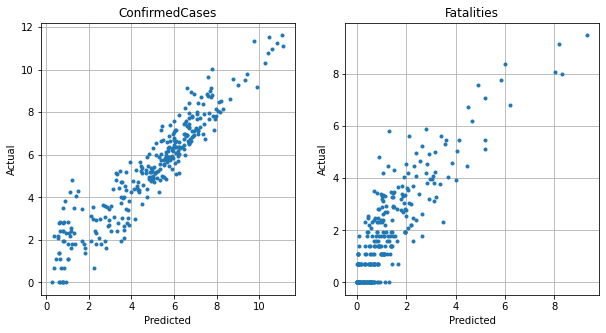



15 x_train (17841, 486)
15 x_val (313, 486)
15 x_full (27231, 486)
15 x_test (313, 486)

****************************************
horizon 15 y0 ConfirmedCases 2020-04-02
****************************************

                  gain
feature               
rate1_r7      0.080000
TotalCases    0.080000
knn6_y0_d1    0.060571
y0_d2         0.060571
testpop       0.058286
google_covid  0.056000
knn6_y0_w2    0.052571
knn6_y0       0.051429
knn6_y0_r7    0.036571
extra_y1_w2   0.036571

lgb validation rmse 1.322956

lgb training with full data and predicting 2020-05-02

                      gain
feature                   
google_covid      0.092571
extra_y0_w2       0.091429
totalTestResults  0.088000
TotalCases        0.072000
rate1_r7          0.065143
knn6_y0_d1        0.061714
knn6_y0           0.050286
extra_y1_w2       0.037714
rate0_r7          0.033143
kd6_y0            0.030857

                      gain
feature                   
extra_y1_r7       0.049724
extra_y0_w2       

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                    gain
feature                 
TotalCases      0.043531
knn6_y0         0.038104
TotalRecovered  0.036433
knn6_y0_r7      0.031177
knn6_y0_w2      0.030970
y0_r7           0.030133
y1              0.028255
ref_day0_0      0.024629
ref_day0_1      0.020882
extra_y0        0.020699

rdg validation rmse 1.799851

rdg training with full data and predicting 2020-05-02


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                gain
feature             
knn6_y0     0.078390
y0_r7       0.039536
knn6_y0_r7  0.038437
y1          0.032445
y1_l2       0.027632
y1_w2       0.026938
positive    0.026471
y1_r7       0.024499
rate1_r7    0.021748
y1_l3       0.018976

****************************************
horizon 15 y1 Fatalities 2020-04-02
****************************************

                     gain
feature                  
extra_y1_r7      0.110000
Loc_China_Hubei  0.097143
ref_day0_0       0.068571
rh               0.055714
y0_d2            0.048571
medianage        0.041429
y0               0.037143
knn11_y0         0.035714
extra_y0_r7      0.034286
y0_w2            0.032857

lgb validation rmse 1.457169

lgb training with full data and predicting 2020-05-02

                      gain
feature                   
extra_y1_w2       0.125714
y0_d5             0.117143
y0                0.095714
rate1_r7          0.062857
totalTestResults  0.058571
extra_y0          0.054286
positive     

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
extra_y1_w2  0.067757
extra_y1     0.065085
extra_y1_r7  0.045787
NewCases     0.041734
knn11_y1_w2  0.031909
y0           0.031537
y0_w2        0.030216
knn11_y1     0.029990
extra_y0     0.029572
y0_r7        0.027549

rdg validation rmse 1.164065

rdg training with full data and predicting 2020-05-02


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
extra_y1_w2  0.063259
y0           0.053182
extra_y1     0.049014
y0_w2        0.044457
rate0        0.042418
rate0_w2     0.037008
extra_y0     0.034963
extra_y0_w2  0.034210
knn11_y1     0.034144
knn11_y1_w2  0.034060

         Validation RMSLE   lgb xgb ctb rdg 
ConfirmedCases 	 1.060252   0.33 0.33 0.33 0.00
Fatalities 	 1.286795   0.25 0.25 0.25 0.25
Mean 	 	 1.173524


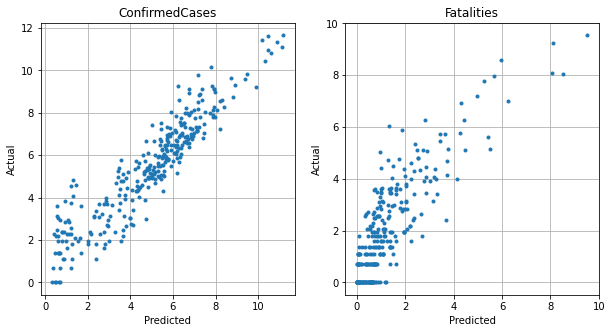



16 x_train (17841, 486)
16 x_val (313, 486)
16 x_full (27231, 486)
16 x_test (313, 486)

****************************************
horizon 16 y0 ConfirmedCases 2020-04-03
****************************************

                  gain
feature               
TotalCases    0.078857
rate1_r7      0.068571
google_covid  0.060571
knn6_y0_d1    0.058286
y0_d2         0.056000
testpop       0.054857
knn6_y0_w2    0.053714
extra_y0_r7   0.050286
extra_y1_r7   0.046857
knn6_y0_r7    0.043429

lgb validation rmse 1.446218

lgb training with full data and predicting 2020-05-03

                      gain
feature                   
google_covid      0.091429
totalTestResults  0.088000
TotalCases        0.077714
extra_y0_w2       0.077714
rate1_r7          0.068571
knn6_y0_d1        0.065143
knn6_y0           0.057143
extra_y1_w2       0.040000
rate0_r7          0.038857
kd6_y0            0.037714

                      gain
feature                   
extra_y0_r7       0.153814
y0_l5             

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                    gain
feature                 
TotalCases      0.047255
knn6_y0_w2      0.040304
TotalRecovered  0.039706
knn6_y0_r7      0.031064
y0_r7           0.028560
knn6_y0         0.027137
ref_day0_0      0.023909
y1              0.021970
rate1_r7        0.021247
ref_day0_1      0.020552

rdg validation rmse 2.063779

rdg training with full data and predicting 2020-05-03


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                gain
feature             
knn6_y0     0.078590
knn6_y0_r7  0.038691
y0_r7       0.038533
y1          0.029870
y1_l2       0.026658
positive    0.025670
y1_w2       0.025662
y1_r7       0.024121
rate1_r7    0.022437
rate0_r7    0.019415

****************************************
horizon 16 y1 Fatalities 2020-04-03
****************************************

                     gain
feature                  
extra_y1_r7      0.102857
Loc_China_Hubei  0.098571
rh               0.057143
medianage        0.055714
ref_day0_0       0.044286
y0               0.042857
extra_y0_r7      0.041429
TotalCases       0.038571
knn11_y0         0.034286
y0_d5            0.034286

lgb validation rmse 1.555243

lgb training with full data and predicting 2020-05-03

                      gain
feature                   
extra_y1_w2       0.132857
y0_d5             0.111429
y0                0.087143
totalTestResults  0.064286
rate1_r7          0.060000
extra_y0          0.055714
y0_d2        

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
extra_y1_r7  0.058222
NewCases     0.043426
extra_y0     0.032936
knn11_y1_w2  0.032931
knn11_y1     0.032810
extra_y0_r7  0.032528
y0           0.030902
y0_r7        0.030633
extra_y0_w2  0.029021
knn11_y0     0.028820

rdg validation rmse 1.194577

rdg training with full data and predicting 2020-05-03


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
extra_y1_w2  0.066858
y0           0.052242
extra_y1     0.051829
y0_w2        0.042478
rate0        0.040666
extra_y0     0.035866
extra_y0_w2  0.035578
rate0_w2     0.034851
knn11_y1_w2  0.031827
knn11_y1     0.031206

         Validation RMSLE   lgb xgb ctb rdg 
ConfirmedCases 	 1.149368   0.33 0.33 0.33 0.00
Fatalities 	 1.358352   0.25 0.25 0.25 0.25
Mean 	 	 1.253860


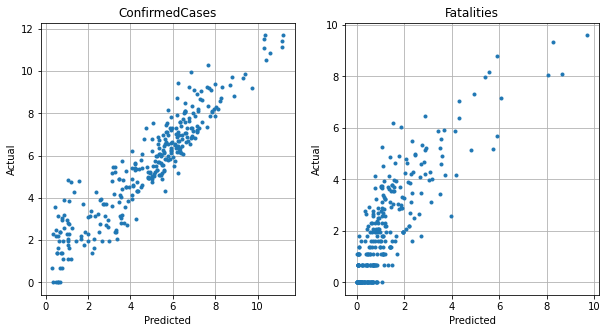



17 x_train (17841, 486)
17 x_val (313, 486)
17 x_full (27231, 486)
17 x_test (313, 486)

****************************************
horizon 17 y0 ConfirmedCases 2020-04-04
****************************************

                  gain
feature               
google_covid  0.094857
rate1_r7      0.074286
knn6_y0_d1    0.068571
TotalCases    0.067429
knn6_y0_w2    0.061714
testpop       0.059429
knn6_y0_r7    0.049143
extra_y0_r7   0.044571
y0_d2         0.040000
extra_y1_r7   0.038857

lgb validation rmse 1.554558

lgb training with full data and predicting 2020-05-04

                      gain
feature                   
google_covid      0.098286
totalTestResults  0.084571
extra_y0_w2       0.076571
TotalCases        0.074286
rate1_r7          0.064000
knn6_y0           0.062857
knn6_y0_d1        0.062857
rate0_r7          0.051429
extra_y1_w2       0.042286
kd6_y0            0.035429

                      gain
feature                   
extra_y0_r7       0.205894
rate1_w2          

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                    gain
feature                 
knn6_y0_w2      0.054443
TotalCases      0.049330
TotalRecovered  0.041563
knn6_y0_r7      0.028371
knn6_y1_w2      0.027886
y0_r7           0.026052
rate1_r7        0.022844
ref_day0_0      0.022273
ref_day0_1      0.019728
knn6_y1         0.019413

rdg validation rmse 2.293491

rdg training with full data and predicting 2020-05-04


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                gain
feature             
knn6_y0     0.078581
y0_r7       0.038066
knn6_y0_r7  0.037885
y1          0.027012
y1_r7       0.026174
y1_l2       0.025607
positive    0.024469
y1_w2       0.024366
rate1_r7    0.023556
rate0_r7    0.020922

****************************************
horizon 17 y1 Fatalities 2020-04-04
****************************************

                     gain
feature                  
Loc_China_Hubei  0.110000
extra_y1_r7      0.105714
medianage        0.062857
rh               0.061429
ref_day0_0       0.060000
extra_y0_r7      0.045714
y0_d2            0.037143
y0_w2            0.035714
knn11_y0         0.035714
y0_d5            0.031429

lgb validation rmse 1.638592

lgb training with full data and predicting 2020-05-04

                      gain
feature                   
extra_y1_w2       0.142857
y0_d5             0.100000
y0                0.087143
rate1_r7          0.067143
totalTestResults  0.065714
extra_y0          0.055714
positive     

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                    gain
feature                 
extra_y1_r7     0.062199
NewCases        0.040093
knn11_y1        0.039381
extra_y0_r7     0.036165
knn11_y1_w2     0.036036
extra_y0        0.034649
y1_w2           0.030688
y0              0.029101
y0_r7           0.028707
TotalRecovered  0.027390

rdg validation rmse 1.338139

rdg training with full data and predicting 2020-05-04


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
extra_y1_w2  0.068472
extra_y1     0.053105
y0           0.050613
y0_w2        0.041205
rate0        0.039423
extra_y0     0.036230
extra_y0_w2  0.036164
knn11_y0     0.034991
rate0_w2     0.033444
knn11_y1_w2  0.031067

         Validation RMSLE   lgb xgb ctb rdg 
ConfirmedCases 	 1.306122   0.33 0.33 0.33 0.00
Fatalities 	 1.464686   0.25 0.25 0.25 0.25
Mean 	 	 1.385404


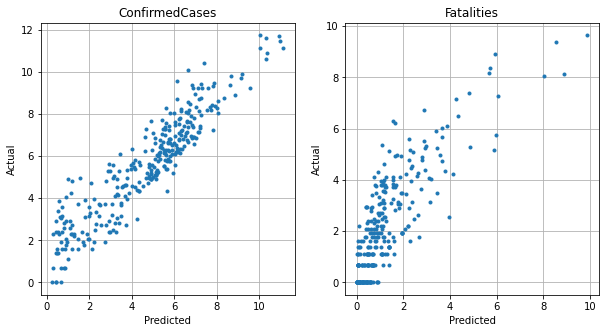



18 x_train (17841, 486)
18 x_val (313, 486)
18 x_full (27231, 486)
18 x_test (313, 486)

****************************************
horizon 18 y0 ConfirmedCases 2020-04-05
****************************************

                  gain
feature               
google_covid  0.117714
testpop       0.070857
knn6_y0_w2    0.068571
TotalCases    0.062857
rate1_r7      0.061714
knn6_y0_d1    0.060571
extra_y0_r7   0.052571
knn6_y0_r7    0.048000
extra_y1_r7   0.038857
y0_d2         0.028571

lgb validation rmse 1.665089

lgb training with full data and predicting 2020-05-05

                      gain
feature                   
google_covid      0.099429
totalTestResults  0.088000
extra_y0_w2       0.081143
TotalCases        0.076571
rate1_r7          0.072000
knn6_y0_d1        0.062857
knn6_y0           0.062857
rate0_r7          0.044571
kd6_y0            0.042286
extra_y1_w2       0.040000

                          gain
feature                       
extra_y0_r7           0.182799
y1_d3 

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                      gain
feature                   
knn6_y0_w2        0.058907
TotalCases        0.047027
TotalRecovered    0.041197
knn6_y1_w2        0.038584
knn6_y1           0.031214
knn6_y0_r7        0.026327
y0_r7             0.023508
rate1_r7          0.023301
positive          0.020669
totalTestResults  0.020669

rdg validation rmse 2.458857

rdg training with full data and predicting 2020-05-05


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                gain
feature             
knn6_y0     0.077955
knn6_y0_r7  0.037554
y0_r7       0.037440
y1_r7       0.027896
y1_l2       0.024715
rate1_r7    0.024474
y1          0.024450
positive    0.023140
y1_w2       0.022900
rate0_r7    0.022230

****************************************
horizon 18 y1 Fatalities 2020-04-05
****************************************

                     gain
feature                  
extra_y1_r7      0.114286
Loc_China_Hubei  0.107143
rh               0.065714
medianage        0.055714
ref_day0_0       0.047143
y0_w2            0.042857
knn11_y0         0.040000
extra_y0_r7      0.037143
y0_d2            0.035714
TotalCases       0.032857

lgb validation rmse 1.738808

lgb training with full data and predicting 2020-05-05

                      gain
feature                   
extra_y1_w2       0.140000
y0_d5             0.092857
y0                0.074286
rate1_r7          0.058571
positive          0.057143
totalTestResults  0.057143
TotalCases   

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                      gain
feature                   
extra_y1_r7       0.057267
positive          0.052202
totalTestResults  0.052202
knn11_y1          0.043714
knn11_y1_w2       0.039519
extra_y0_r7       0.034059
TotalRecovered    0.031132
extra_y0          0.030796
NewCases          0.029234
y1_w2             0.029000

rdg validation rmse 1.861012

rdg training with full data and predicting 2020-05-05


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
extra_y1_w2  0.069804
extra_y1     0.054297
y0           0.050317
y0_w2        0.041049
rate0        0.039019
knn11_y0     0.037953
extra_y0     0.036621
extra_y0_w2  0.036359
rate0_w2     0.033029
knn11_y1_w2  0.028704

         Validation RMSLE   lgb xgb ctb rdg 
ConfirmedCases 	 1.423439   0.33 0.33 0.33 0.00
Fatalities 	 1.595747   0.25 0.25 0.25 0.25
Mean 	 	 1.509593


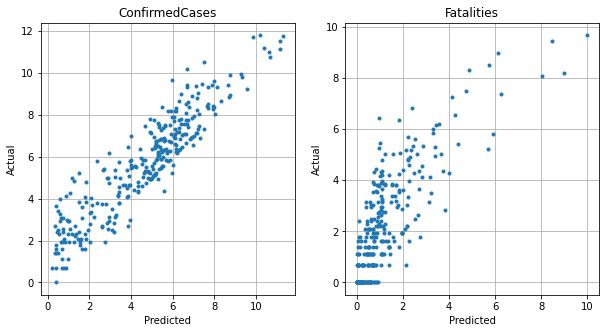



19 x_train (17841, 486)
19 x_val (313, 486)
19 x_full (27231, 486)
19 x_test (313, 486)

****************************************
horizon 19 y0 ConfirmedCases 2020-04-06
****************************************

                  gain
feature               
google_covid  0.145143
testpop       0.078857
knn6_y0_w2    0.075429
rate1_r7      0.067429
extra_y0_r7   0.058286
knn6_y0_r7    0.057143
TotalCases    0.050286
knn6_y0_d1    0.041143
extra_y1_r7   0.038857
rate0_r7      0.029714

lgb validation rmse 1.805152

lgb training with full data and predicting 2020-05-06

                      gain
feature                   
google_covid      0.097143
TotalCases        0.081143
totalTestResults  0.076571
rate1_r7          0.069714
knn6_y0           0.068571
extra_y0_w2       0.062857
rate0_r7          0.057143
knn6_y0_d1        0.056000
extra_y1_w2       0.046857
kd6_y0            0.042286

                          gain
feature                       
extra_y0_r7           0.155055
Loc_It

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                    gain
feature                 
knn6_y0_w2      0.067289
knn6_y1_w2      0.048783
TotalCases      0.046581
TotalRecovered  0.042318
knn6_y1         0.041540
knn6_y0_r7      0.025660
rate1_r7        0.024782
y1_w2           0.021720
y0_r7           0.021060
ref_day0_0      0.019910

rdg validation rmse 2.564858

rdg training with full data and predicting 2020-05-06


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                gain
feature             
knn6_y0     0.076565
knn6_y0_r7  0.037518
y0_r7       0.036339
y1_r7       0.027646
rate1_r7    0.026096
rate0_r7    0.024319
y1_l2       0.023321
y1          0.023240
ref_day0_0  0.022488
positive    0.022076

****************************************
horizon 19 y1 Fatalities 2020-04-06
****************************************

                     gain
feature                  
Loc_China_Hubei  0.111429
extra_y1_r7      0.101429
y0_w2            0.062857
medianage        0.061429
rh               0.058571
ref_day0_0       0.054286
extra_y0_r7      0.044286
knn11_y0_r7      0.035714
knn11_y0_w2      0.030000
y0_d2            0.028571

lgb validation rmse 1.800164

lgb training with full data and predicting 2020-05-06

                      gain
feature                   
extra_y1_w2       0.152857
y0_d5             0.085714
y0                0.067143
positive          0.065714
totalTestResults  0.058571
TotalCases        0.052857
extra_y0     

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                    gain
feature                 
extra_y1_r7     0.063753
knn11_y1        0.057645
knn11_y1_w2     0.052086
TotalRecovered  0.038072
extra_y0_r7     0.037713
y1_w2           0.034156
extra_y0        0.034072
y0_r7           0.029372
TotalCases      0.028418
y0              0.026356

rdg validation rmse 1.716560

rdg training with full data and predicting 2020-05-06


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
extra_y1_w2  0.071618
extra_y1     0.056085
y0           0.050176
knn11_y0     0.042188
y0_w2        0.041866
rate0        0.039290
extra_y0     0.037202
extra_y0_w2  0.036711
rate0_w2     0.032979
knn11_y1_w2  0.028052

         Validation RMSLE   lgb xgb ctb rdg 
ConfirmedCases 	 1.564864   0.33 0.33 0.33 0.00
Fatalities 	 1.649549   0.25 0.25 0.25 0.25
Mean 	 	 1.607206


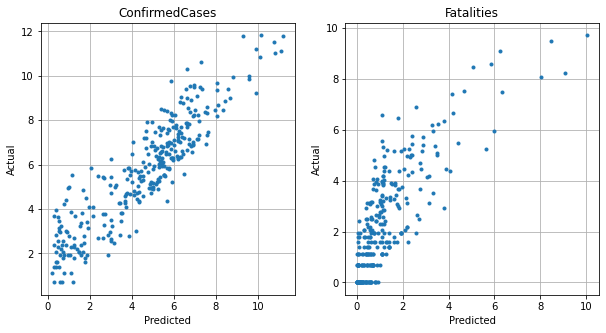



20 x_train (17841, 486)
20 x_val (313, 486)
20 x_full (27231, 486)
20 x_test (313, 486)

****************************************
horizon 20 y0 ConfirmedCases 2020-04-07
****************************************

                  gain
feature               
google_covid  0.173714
testpop       0.083429
knn6_y0_w2    0.077714
rate1_r7      0.062857
extra_y0_r7   0.059429
knn6_y0_r7    0.056000
TotalCases    0.037714
knn6_y0_d1    0.035429
extra_y1_r7   0.033143
rh            0.028571

lgb validation rmse 1.962315

lgb training with full data and predicting 2020-05-07

                      gain
feature                   
google_covid      0.094857
TotalCases        0.076571
totalTestResults  0.073143
rate1_r7          0.070857
knn6_y0           0.065143
extra_y0_w2       0.064000
rate0_r7          0.060571
knn6_y0_d1        0.054857
kd6_y0            0.048000
extra_y1_w2       0.044571

                          gain
feature                       
extra_y0_r7           0.228931
Loc_Ko

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                    gain
feature                 
knn6_y0_w2      0.074793
knn6_y1_w2      0.053822
knn6_y1         0.047014
TotalCases      0.043508
TotalRecovered  0.041308
knn6_y0         0.026590
rate1_r7        0.025159
knn6_y0_r7      0.023385
y1_w2           0.020467
temp            0.020144

rdg validation rmse 2.673848

rdg training with full data and predicting 2020-05-07


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                gain
feature             
knn6_y0     0.075906
knn6_y0_r7  0.037079
y0_r7       0.034955
y1_r7       0.028210
rate1_r7    0.027460
rate0_r7    0.026072
y1_l2       0.023784
ref_day0_0  0.023548
positive    0.020845
y1          0.020817

****************************************
horizon 20 y1 Fatalities 2020-04-07
****************************************

                     gain
feature                  
Loc_China_Hubei  0.112857
extra_y1_r7      0.088571
medianage        0.065714
rh               0.055714
extra_y0_r7      0.054286
ref_day0_0       0.051429
y0_w2            0.048571
knn11_y0         0.038571
knn11_y0_w2      0.034286
y0               0.032857

lgb validation rmse 1.876845

lgb training with full data and predicting 2020-05-07

                      gain
feature                   
extra_y1_w2       0.160000
y0_d5             0.080000
positive          0.070000
TotalCases        0.061429
totalTestResults  0.060000
y0                0.057143
rate1_r7     

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                    gain
feature                 
extra_y1_r7     0.065013
knn11_y1        0.060593
knn11_y1_w2     0.055999
TotalRecovered  0.044537
extra_y0_r7     0.037829
y1_w2           0.036060
TotalCases      0.031652
extra_y0        0.030350
y0_r7           0.026571
ref_day0_0      0.025443

rdg validation rmse 1.841444

rdg training with full data and predicting 2020-05-07


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
extra_y1_w2  0.071073
extra_y1     0.055773
y0           0.050417
knn11_y0     0.045605
y0_w2        0.041978
rate0        0.039731
extra_y0     0.036324
extra_y0_w2  0.035684
rate0_w2     0.032990
knn11_y1_w2  0.028217

         Validation RMSLE   lgb xgb ctb rdg 
ConfirmedCases 	 1.751447   0.33 0.33 0.33 0.00
Fatalities 	 1.834718   0.25 0.25 0.25 0.25
Mean 	 	 1.793083


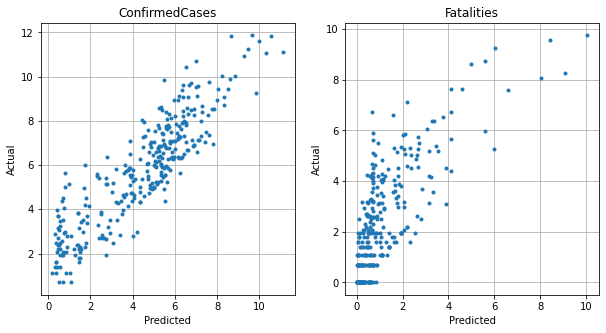



21 x_train (17841, 486)
21 x_val (313, 486)
21 x_full (27231, 486)
21 x_test (313, 486)

****************************************
horizon 21 y0 ConfirmedCases 2020-04-08
****************************************

                      gain
feature                   
google_covid      0.168000
testpop           0.080000
knn6_y0_w2        0.077714
rate1_r7          0.064000
knn6_y0_r7        0.060571
extra_y0_r7       0.058286
TotalCases        0.046857
extra_y1_r7       0.035429
Loc_Korea__South  0.030857
Loc_China_Hubei   0.028571

lgb validation rmse 2.044207

lgb training with full data and predicting 2020-05-08

                      gain
feature                   
google_covid      0.097143
rate1_r7          0.080000
TotalCases        0.074286
totalTestResults  0.068571
knn6_y0           0.068571
extra_y0_w2       0.062857
knn6_y0_d1        0.058286
rate0_r7          0.058286
kd6_y0            0.045714
extra_y1_w2       0.044571

                      gain
feature                 

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                    gain
feature                 
knn6_y0_w2      0.082103
knn6_y1_w2      0.054260
knn6_y1         0.047805
TotalCases      0.046804
TotalRecovered  0.042783
knn6_y0         0.039459
rate1_r7        0.024734
temp            0.022965
knn6_y0_r7      0.020857
rate0_r7        0.019403

rdg validation rmse 2.756650

rdg training with full data and predicting 2020-05-08


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                gain
feature             
knn6_y0     0.072231
knn6_y0_r7  0.035536
y0_r7       0.033250
rate1_r7    0.028545
y1_r7       0.028238
rate0_r7    0.027538
ref_day0_0  0.023971
y1_l2       0.021432
y0_w2       0.020395
TotalCases  0.020065

****************************************
horizon 21 y1 Fatalities 2020-04-08
****************************************

                     gain
feature                  
Loc_China_Hubei  0.112857
extra_y1_r7      0.094286
medianage        0.067143
y0_w2            0.058571
rh               0.057143
extra_y0_r7      0.052857
TotalCases       0.050000
ref_day0_0       0.045714
testpop          0.034286
knn11_y0_w2      0.030000

lgb validation rmse 1.987416

lgb training with full data and predicting 2020-05-08

                      gain
feature                   
extra_y1_w2       0.157143
y0_d5             0.081429
totalTestResults  0.070000
TotalCases        0.061429
rate1_r7          0.058571
positive          0.058571
y0           

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                    gain
feature                 
extra_y1_r7     0.065667
TotalRecovered  0.055733
knn11_y1        0.054958
knn11_y1_w2     0.051100
TotalCases      0.040337
extra_y0_r7     0.036658
y1_w2           0.030607
ref_day0_0      0.026059
NewCases        0.025943
y0_r7           0.024328

rdg validation rmse 1.957285

rdg training with full data and predicting 2020-05-08


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
extra_y1_w2  0.070726
extra_y1     0.055346
y0           0.050991
knn11_y0     0.048245
y0_w2        0.042292
rate0        0.040910
extra_y0     0.035550
extra_y0_w2  0.034884
rate0_w2     0.033866
knn11_y1_w2  0.026906

         Validation RMSLE   lgb xgb ctb rdg 
ConfirmedCases 	 1.912804   0.33 0.33 0.33 0.00
Fatalities 	 1.922640   0.25 0.25 0.25 0.25
Mean 	 	 1.917722


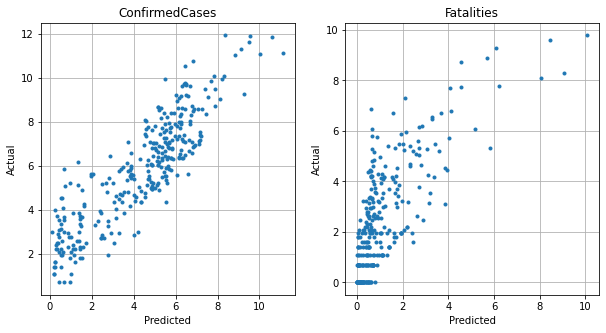



22 x_train (17841, 486)
22 x_val (313, 486)
22 x_full (27231, 486)
22 x_test (313, 486)

****************************************
horizon 22 y0 ConfirmedCases 2020-04-09
****************************************

                     gain
feature                  
google_covid     0.160000
knn6_y0_w2       0.081143
testpop          0.075429
knn6_y0_r7       0.067429
rate1_r7         0.060571
extra_y0_r7      0.059429
Loc_China_Hubei  0.036571
extra_y1_r7      0.036571
TotalCases       0.034286
rate0_r7         0.032000

lgb validation rmse 2.125601

lgb training with full data and predicting 2020-05-09

                      gain
feature                   
google_covid      0.088000
rate1_r7          0.082286
TotalCases        0.077714
extra_y0_w2       0.070857
knn6_y0           0.067429
totalTestResults  0.061714
rate0_r7          0.060571
knn6_y0_d1        0.057143
kd6_y0            0.040000
extra_y1_w2       0.035429

                      gain
feature                   
extra_y0_

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                    gain
feature                 
knn6_y0_w2      0.084378
knn6_y1_w2      0.057815
knn6_y1         0.050947
TotalCases      0.048601
TotalRecovered  0.045603
knn6_y0         0.043382
rate1_r7        0.024914
temp            0.021653
knn6_y0_r7      0.020702
rate0_r7        0.019657

rdg validation rmse 2.794289

rdg training with full data and predicting 2020-05-09


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                gain
feature             
knn6_y0     0.068594
knn6_y0_r7  0.033771
y0_r7       0.031023
rate1_r7    0.029887
rate0_r7    0.029135
y1_r7       0.027885
ref_day0_0  0.024270
y0_w2       0.022892
TotalCases  0.020402
y1_l2       0.019576

****************************************
horizon 22 y1 Fatalities 2020-04-09
****************************************

                     gain
feature                  
Loc_China_Hubei  0.115714
extra_y1_r7      0.087143
medianage        0.067143
y0_w2            0.061429
extra_y0_r7      0.054286
testpop          0.048571
ref_day0_0       0.047143
TotalCases       0.041429
rh               0.040000
knn11_y0_r7      0.038571

lgb validation rmse 2.080121

lgb training with full data and predicting 2020-05-09

                      gain
feature                   
extra_y1_w2       0.158571
y0_d5             0.078571
TotalCases        0.074286
positive          0.068571
totalTestResults  0.064286
y0                0.048571
rate1_r7     

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                     gain
feature                  
knn11_y1         0.062614
TotalRecovered   0.062329
extra_y1_r7      0.062314
knn11_y1_w2      0.055420
TotalCases       0.045710
extra_y0_r7      0.033804
NewCases         0.031754
SeriousCritical  0.029624
y1_w2            0.025221
ref_day0_0       0.024988

rdg validation rmse 2.039779

rdg training with full data and predicting 2020-05-09


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
extra_y1_w2  0.068902
extra_y1     0.053687
y0           0.050783
knn11_y0     0.050102
y0_w2        0.042281
rate0        0.041916
rate0_w2     0.034972
extra_y0     0.033764
extra_y0_w2  0.033387
knn11_y1_w2  0.025322

         Validation RMSLE   lgb xgb ctb rdg 
ConfirmedCases 	 2.019729   0.33 0.33 0.33 0.00
Fatalities 	 1.989844   0.25 0.25 0.25 0.25
Mean 	 	 2.004786


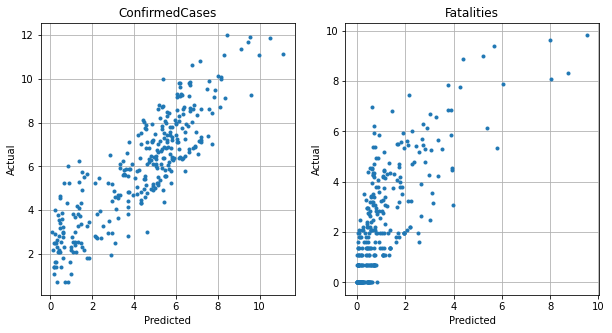



23 x_train (17841, 486)
23 x_val (313, 486)
23 x_full (27231, 486)
23 x_test (313, 486)

****************************************
horizon 23 y0 ConfirmedCases 2020-04-10
****************************************

                      gain
feature                   
google_covid      0.147429
testpop           0.089143
knn6_y0_w2        0.081143
extra_y0_r7       0.067429
rate1_r7          0.059429
knn6_y0_r7        0.054857
Loc_China_Hubei   0.036571
extra_y1_r7       0.036571
Loc_Korea__South  0.034286
extra_y1          0.028571

lgb validation rmse 2.195204

lgb training with full data and predicting 2020-05-10

                      gain
feature                   
google_covid      0.081143
rate1_r7          0.080000
knn6_y0           0.080000
TotalCases        0.074286
knn6_y0_d1        0.065143
totalTestResults  0.054857
extra_y0_w2       0.053714
rate0_r7          0.052571
kd6_y0            0.044571
extra_y1_w2       0.040000

                      gain
feature                 

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                    gain
feature                 
knn6_y0_w2      0.083891
knn6_y1_w2      0.058528
knn6_y1         0.050613
TotalCases      0.047732
TotalRecovered  0.046036
knn6_y0         0.042924
rate1_r7        0.026578
rate0_r7        0.021131
knn6_y0_r7      0.020756
temp            0.019936

rdg validation rmse 2.853101

rdg training with full data and predicting 2020-05-10


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                gain
feature             
knn6_y0     0.065653
knn6_y0_r7  0.032609
rate1_r7    0.031231
rate0_r7    0.030681
y0_r7       0.029367
y1_r7       0.027629
y0_w2       0.025183
ref_day0_0  0.024824
TotalCases  0.020974
rate0       0.019247

****************************************
horizon 23 y1 Fatalities 2020-04-10
****************************************

                     gain
feature                  
Loc_China_Hubei  0.115714
extra_y1_r7      0.092857
medianage        0.062857
y0_w2            0.062857
extra_y0_r7      0.060000
rh               0.047143
testpop          0.044286
y0_d1            0.042857
ref_day0_0       0.041429
TotalCases       0.034286

lgb validation rmse 2.157799

lgb training with full data and predicting 2020-05-10

                      gain
feature                   
extra_y1_w2       0.160000
y0_d5             0.078571
positive          0.074286
TotalCases        0.068571
rate1_r7          0.064286
totalTestResults  0.052857
y0           

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                     gain
feature                  
TotalRecovered   0.065028
knn11_y1         0.064516
extra_y1_r7      0.062588
knn11_y1_w2      0.057009
TotalCases       0.044611
extra_y0_r7      0.032786
SeriousCritical  0.029071
ref_day0_0       0.025413
y1_w2            0.025031
NewCases         0.024853

rdg validation rmse 2.131388

rdg training with full data and predicting 2020-05-10


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
extra_y1_w2  0.068192
knn11_y0     0.052731
extra_y1     0.052612
y0           0.050337
rate0        0.043250
y0_w2        0.043108
rate0_w2     0.035881
extra_y0_w2  0.032093
extra_y0     0.031949
knn11_y1_w2  0.023249

         Validation RMSLE   lgb xgb ctb rdg 
ConfirmedCases 	 2.113890   0.33 0.33 0.33 0.00
Fatalities 	 2.060604   0.25 0.25 0.25 0.25
Mean 	 	 2.087247


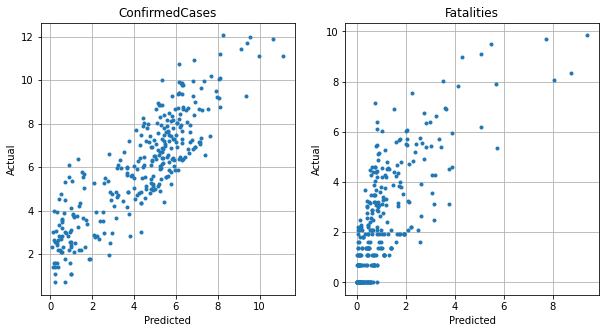



24 x_train (17841, 486)
24 x_val (313, 486)
24 x_full (27231, 486)
24 x_test (313, 486)

****************************************
horizon 24 y0 ConfirmedCases 2020-04-11
****************************************

                      gain
feature                   
google_covid      0.132571
testpop           0.093714
knn6_y0_w2        0.077714
extra_y0_r7       0.066286
rate1_r7          0.058286
knn6_y0_r7        0.057143
Loc_China_Hubei   0.041143
Loc_Korea__South  0.038857
extra_y1_r7       0.038857
extra_y1          0.029714

lgb validation rmse 2.231049

lgb training with full data and predicting 2020-05-11

                      gain
feature                   
knn6_y0           0.085714
rate1_r7          0.076571
TotalCases        0.076571
knn6_y0_d1        0.069714
google_covid      0.065143
extra_y0_w2       0.059429
totalTestResults  0.052571
rate0_r7          0.051429
kd6_y0            0.048000
extra_y1_w2       0.037714

                     gain
feature                  

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                    gain
feature                 
knn6_y0_w2      0.084568
knn6_y1_w2      0.054518
TotalCases      0.047810
TotalRecovered  0.046604
knn6_y1         0.045290
knn6_y0         0.042642
rate1_r7        0.029344
rate0_r7        0.023563
knn6_y0_r7      0.021142
y0_w2           0.019813

rdg validation rmse 2.895232

rdg training with full data and predicting 2020-05-11


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                gain
feature             
knn6_y0     0.061880
rate1_r7    0.032303
rate0_r7    0.031906
knn6_y0_r7  0.031628
y0_r7       0.027590
y0_w2       0.027215
y1_r7       0.026804
ref_day0_0  0.024985
rate0_w2    0.021517
TotalCases  0.021418

****************************************
horizon 24 y1 Fatalities 2020-04-11
****************************************

                     gain
feature                  
Loc_China_Hubei  0.117143
extra_y1_r7      0.097143
medianage        0.075714
y0_w2            0.064286
extra_y0_r7      0.057143
testpop          0.050000
y0_d1            0.038571
rh               0.037143
TotalCases       0.034286
ref_day0_0       0.034286

lgb validation rmse 2.241428

lgb training with full data and predicting 2020-05-11

                      gain
feature                   
extra_y1_w2       0.158571
y0_d5             0.080000
rate1_r7          0.070000
positive          0.065714
totalTestResults  0.064286
TotalCases        0.058571
y0_d2        

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                     gain
feature                  
TotalRecovered   0.067112
knn11_y1         0.065135
extra_y1_r7      0.062785
knn11_y1_w2      0.059262
TotalCases       0.043821
extra_y0_r7      0.032749
y0_w2            0.030038
SeriousCritical  0.028417
ref_day0_0       0.025622
ref_day0_1       0.022941

rdg validation rmse 2.341143

rdg training with full data and predicting 2020-05-11


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
extra_y1_w2  0.065966
knn11_y0     0.052938
extra_y1     0.050394
y0           0.049712
rate0        0.043691
y0_w2        0.043526
rate0_w2     0.036256
extra_y0_w2  0.030482
extra_y0     0.029725
ref_day0_0   0.023277

         Validation RMSLE   lgb xgb ctb rdg 
ConfirmedCases 	 2.142333   0.33 0.33 0.33 0.00
Fatalities 	 2.194905   0.25 0.25 0.25 0.25
Mean 	 	 2.168619


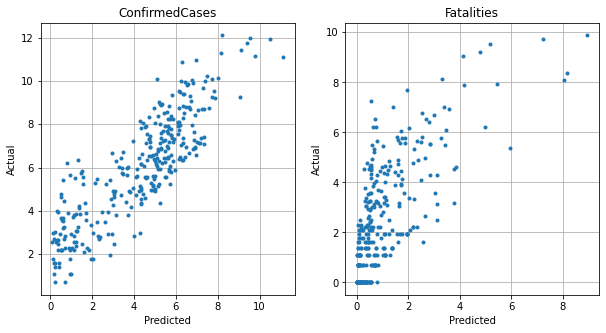



25 x_train (17841, 486)
25 x_val (313, 486)
25 x_full (27231, 486)
25 x_test (313, 486)

****************************************
horizon 25 y0 ConfirmedCases 2020-04-12
****************************************

                      gain
feature                   
google_covid      0.123429
testpop           0.085714
extra_y0_r7       0.074286
knn6_y0_w2        0.067429
rate1_r7          0.064000
knn6_y0_r7        0.056000
Loc_China_Hubei   0.043429
Loc_Korea__South  0.040000
extra_y1_r7       0.036571
extra_y1          0.032000

lgb validation rmse 2.297478

lgb training with full data and predicting 2020-05-12

                      gain
feature                   
knn6_y0           0.085714
google_covid      0.084571
TotalCases        0.080000
rate1_r7          0.073143
knn6_y0_d1        0.070857
extra_y0_w2       0.057143
totalTestResults  0.053714
rate0_r7          0.046857
kd6_y0            0.045714
extra_y1_w2       0.045714

                     gain
feature                  

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                    gain
feature                 
knn6_y0_w2      0.091191
knn6_y0         0.048312
knn6_y1_w2      0.047790
TotalRecovered  0.047014
TotalCases      0.046938
knn6_y1         0.037349
rate1_r7        0.031777
rate0_r7        0.025700
knn6_y0_r7      0.021807
y0_w2           0.020204

rdg validation rmse 2.940960

rdg training with full data and predicting 2020-05-12


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                gain
feature             
knn6_y0     0.058303
rate1_r7    0.033308
rate0_r7    0.033082
knn6_y0_r7  0.031323
y0_w2       0.029141
y0_r7       0.026049
y1_r7       0.025450
ref_day0_0  0.025052
rate0_w2    0.024089
rate0       0.022178

****************************************
horizon 25 y1 Fatalities 2020-04-12
****************************************

                     gain
feature                  
Loc_China_Hubei  0.117143
extra_y1_r7      0.098571
medianage        0.064286
y0_w2            0.058571
testpop          0.054286
extra_y0_r7      0.051429
rh               0.044286
ref_day0_0       0.040000
knn11_y1         0.032857
knn11_y0_r7      0.031429

lgb validation rmse 2.305783

lgb training with full data and predicting 2020-05-12

                      gain
feature                   
extra_y1_w2       0.157143
rate1_r7          0.075714
positive          0.065714
TotalCases        0.062857
totalTestResults  0.061429
y0_d5             0.058571
medianage    

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                     gain
feature                  
TotalRecovered   0.073219
extra_y1_r7      0.061566
knn11_y1         0.058264
knn11_y1_w2      0.055102
TotalCases       0.045363
y0_w2            0.036988
knn11_y0_w2      0.031559
extra_y0_r7      0.031285
SeriousCritical  0.029895
ref_day0_0       0.024770

rdg validation rmse 2.421863

rdg training with full data and predicting 2020-05-12


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
extra_y1_w2  0.064534
knn11_y0     0.054662
y0           0.049627
extra_y1     0.048799
rate0        0.043892
y0_w2        0.043801
rate0_w2     0.036994
extra_y0_w2  0.029185
extra_y0     0.027714
knn11_y1_w2  0.024901

         Validation RMSLE   lgb xgb ctb rdg 
ConfirmedCases 	 2.195388   0.33 0.33 0.33 0.00
Fatalities 	 2.245718   0.25 0.25 0.25 0.25
Mean 	 	 2.220553


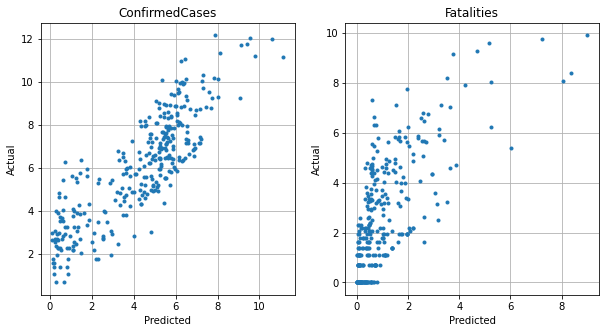



26 x_train (17841, 486)
26 x_val (313, 486)
26 x_full (27231, 486)
26 x_test (313, 486)

****************************************
horizon 26 y0 ConfirmedCases 2020-04-13
****************************************

                          gain
feature                       
google_covid          0.110857
testpop               0.082286
extra_y0_r7           0.072000
knn6_y0_w2            0.068571
rate1_r7              0.064000
Loc_China_Hubei       0.049143
knn6_y0_r7            0.046857
Loc_Korea__South      0.044571
extra_y1_r7           0.041143
Loc_Diamond_Princess  0.033143

lgb validation rmse 2.351138

lgb training with full data and predicting 2020-05-13

                      gain
feature                   
knn6_y0           0.084571
TotalCases        0.078857
google_covid      0.073143
rate1_r7          0.072000
knn6_y0_d1        0.070857
extra_y0_w2       0.053714
rate0_r7          0.051429
totalTestResults  0.049143
extra_y1_w2       0.043429
kd6_y0            0.037714

   

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                    gain
feature                 
knn6_y0_w2      0.101726
knn6_y0         0.059059
TotalRecovered  0.043666
TotalCases      0.043314
knn6_y1_w2      0.035486
rate1_r7        0.033219
rate0_r7        0.027068
knn6_y1         0.023812
knn6_y0_r7      0.022117
ref_day0_1      0.020462

rdg validation rmse 3.005249

rdg training with full data and predicting 2020-05-13


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                gain
feature             
knn6_y0     0.056647
rate1_r7    0.034176
rate0_r7    0.034022
y0_w2       0.031941
knn6_y0_r7  0.030873
rate0_w2    0.026979
ref_day0_0  0.025044
y1_r7       0.024770
y0_r7       0.024286
rate0       0.023861

****************************************
horizon 26 y1 Fatalities 2020-04-13
****************************************

                     gain
feature                  
Loc_China_Hubei  0.117143
extra_y1_r7      0.102857
y0_w2            0.070000
medianage        0.067143
extra_y0_r7      0.060000
testpop          0.052857
y0_d1            0.037143
ref_day0_0       0.035714
knn11_y0_r7      0.032857
rh               0.030000

lgb validation rmse 2.354474

lgb training with full data and predicting 2020-05-13

                      gain
feature                   
extra_y1_w2       0.164286
positive          0.080000
rate1_r7          0.068571
TotalCases        0.062857
y0_d5             0.054286
medianage         0.048571
totalTestResu

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                    gain
feature                 
TotalRecovered  0.072011
extra_y1_r7     0.061831
knn11_y1        0.051205
knn11_y1_w2     0.050708
knn11_y0_w2     0.046025
y0_w2           0.043522
TotalCases      0.042096
knn11_y0        0.030800
extra_y0_r7     0.030390
ref_day0_0      0.024303

rdg validation rmse 2.501705

rdg training with full data and predicting 2020-05-13


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
extra_y1_w2  0.062149
knn11_y0     0.056982
y0           0.049779
extra_y1     0.046360
rate0        0.044698
y0_w2        0.044314
rate0_w2     0.038144
knn11_y1_w2  0.028049
extra_y0_w2  0.027429
knn11_y0_w2  0.025854

         Validation RMSLE   lgb xgb ctb rdg 
ConfirmedCases 	 2.254603   0.33 0.33 0.33 0.00
Fatalities 	 2.349375   0.25 0.25 0.25 0.25
Mean 	 	 2.301989


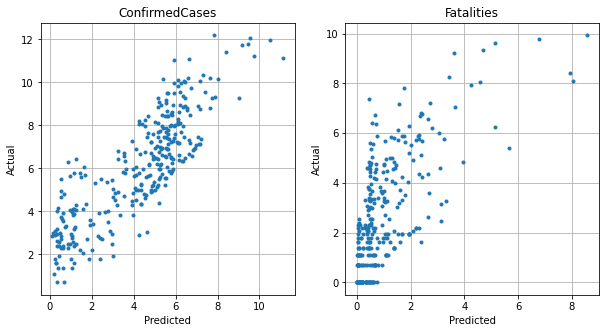



27 x_train (17841, 486)
27 x_val (313, 486)
27 x_full (27231, 486)
27 x_test (313, 486)

****************************************
horizon 27 y0 ConfirmedCases 2020-04-14
****************************************

                          gain
feature                       
google_covid          0.088000
testpop               0.078857
extra_y0_r7           0.075429
rate1_r7              0.068571
knn6_y0_w2            0.059429
Loc_China_Hubei       0.050286
knn6_y0_r7            0.050286
Loc_Korea__South      0.043429
Loc_Diamond_Princess  0.033143
extra_y1              0.032000

lgb validation rmse 2.381986

lgb training with full data and predicting 2020-05-14

                      gain
feature                   
knn6_y0           0.081143
rate1_r7          0.078857
google_covid      0.075429
knn6_y0_d1        0.062857
TotalCases        0.061714
extra_y0_w2       0.053714
extra_y1_w2       0.051429
totalTestResults  0.050286
rate0_r7          0.050286
kd6_y0            0.041143

   

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                    gain
feature                 
knn6_y0_w2      0.104093
knn6_y0         0.059435
TotalRecovered  0.040286
TotalCases      0.040158
rate1_r7        0.034726
knn6_y1_w2      0.031433
rate0_r7        0.028337
knn6_y0_r7      0.024097
ref_day0_1      0.021590
y0_w2           0.020084

rdg validation rmse 3.057987

rdg training with full data and predicting 2020-05-14


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                gain
feature             
knn6_y0     0.055216
y0_w2       0.035251
rate1_r7    0.034972
rate0_r7    0.034836
knn6_y0_r7  0.030828
rate0_w2    0.030543
rate0       0.027035
y0          0.026216
y1_r7       0.025202
ref_day0_0  0.025149

****************************************
horizon 27 y1 Fatalities 2020-04-14
****************************************

                     gain
feature                  
Loc_China_Hubei  0.117143
extra_y1_r7      0.088571
y0_w2            0.068571
medianage        0.065714
testpop          0.065714
extra_y0_r7      0.052857
ref_day0_0       0.047143
rh               0.040000
y0_d1            0.030000
knn11_y0_w2      0.028571

lgb validation rmse 2.420810

lgb training with full data and predicting 2020-05-14

                      gain
feature                   
extra_y1_w2       0.151429
rate1_r7          0.082857
positive          0.065714
medianage         0.062857
TotalCases        0.060000
y0_d5             0.045714
totalTestResu

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                    gain
feature                 
TotalRecovered  0.066715
extra_y1_r7     0.060332
knn11_y0_w2     0.050316
knn11_y1_w2     0.049476
knn11_y1        0.047329
y0_w2           0.045907
TotalCases      0.036351
knn11_y0        0.033895
extra_y0_r7     0.028828
ref_day0_1      0.023811

rdg validation rmse 2.597624

rdg training with full data and predicting 2020-05-14


/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)



                 gain
feature              
extra_y1_w2  0.059621
knn11_y0     0.058620
y0           0.051271
rate0        0.046998
y0_w2        0.046446
extra_y1     0.043080
rate0_w2     0.040598
knn11_y1_w2  0.029135
knn11_y0_w2  0.027352
extra_y0_w2  0.025312

         Validation RMSLE   lgb xgb ctb rdg 
ConfirmedCases 	 2.288365   0.33 0.33 0.33 0.00
Fatalities 	 2.430053   0.25 0.25 0.25 0.25
Mean 	 	 2.359209


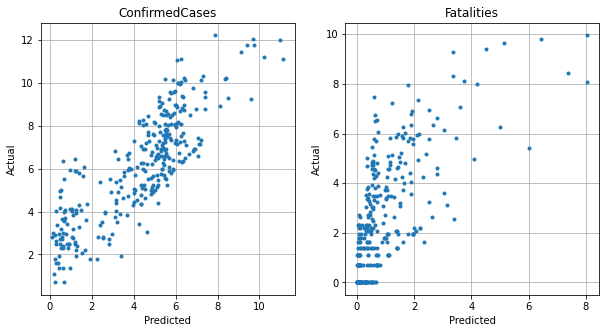



28 x_train (17841, 486)
28 x_val (313, 486)
28 x_full (27231, 486)
28 x_test (313, 486)

****************************************
horizon 28 y0 ConfirmedCases 2020-04-15
****************************************

                          gain
feature                       
testpop               0.081143
google_covid          0.073143
extra_y0_r7           0.073143
rate1_r7              0.068571
knn6_y0_w2            0.061714
Loc_China_Hubei       0.050286
Loc_Korea__South      0.048000
knn6_y0_r7            0.040000
Loc_Diamond_Princess  0.038857
Loc_China_Anhui       0.034286

lgb validation rmse 2.424313

lgb training with full data and predicting 2020-05-15

                      gain
feature                   
google_covid      0.082286
rate1_r7          0.067429
knn6_y0           0.066286
TotalCases        0.064000
knn6_y0_d1        0.058286
extra_y0_w2       0.058286
rate0_r7          0.050286
totalTestResults  0.045714
extra_y1_w2       0.045714
kd6_y0            0.043429

   

CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=93]=nan : cat_features must be integer or string, real number values and NaN values should be converted to string.

In [96]:
# single horizon validation using one day at a time for 28 days
nb = len(booster)
nls = np.zeros((nhorizon-skip,ny,nb+tf2))
rallv = np.zeros((nhorizon-skip,ny,nb))
iallv = np.zeros((nhorizon-skip,ny,nb)).astype(int)
yallv = []
pallv = []
imps = []
 
# loop over horizons
for horizon in range(1+skip,nhorizon+1):
# for horizon in range(4,5):
    
    print()
#     print('*'*20)
#     print(f'horizon {horizon}')
#     print('*'*20)
    
    gc.collect()
    
    hs = str(horizon)
    if horizon < 10: hs = '0' + hs
    
    # build lists of features
    lags = []
    # must lag reference days to avoid validation leakage
    for i in range(ny):
        for j in range(3):
            # omit ref_day0_0 since it is no longer leaky
            # if (i > 0) | (j > 0): lags.append('ref_day'+str(i)+'_'+str(j))
            lags.append('ref_day'+str(i)+'_'+str(j))
            
    # lag all time-varying features
    for i in range(ny):
        yi = 'y'+str(i)
        lags.append(yi)
        lags.append('extra_'+yi)
        lags.append('rate'+str(i))
        for j in range(5):
            lags.append(yi+'_d'+str(1+j))
            lags.append(yi+'_l'+str(1+j))
        lags.append('extra_'+yi+dd)
        lags.append('rate'+str(i)+dd)
        lags.append(yi+rr)
        lags.append('extra_'+yi+rr)
        lags.append('rate'+str(i)+rr)
        lags.append(yi+ww)
        lags.append('extra_'+yi+ww)
        lags.append('rate'+str(i)+ww)
        for k in kp:
            lags.append(k+yi)
            lags.append(k+yi+dd)
            lags.append(k+yi+rr)
            lags.append(k+yi+ww)
        for k in kd:
            lags.append(k+yi)
            lags.append(k+yi+dd)
            lags.append(k+yi+rr)
            lags.append(k+yi+ww)
       
    lags.append('recov')
    
#     lags = lags + wmf + google + wf + ckeep

    lags = lags + google + ckeep + wf + wmf
    
#     cinfo = ['pop', 'tests', 'testpop', 'density', 'medianage',
#        'urbanpop', 'hospibed', 'smokers']
    cinfo0 = ['testpop']
    cinfo1 = ['testpop','medianage']
    
    f0 = dogs + lags + cinfo0 + ohef
    f1 = dogs + lags + cinfo1 + ohef
    
    # remove some features based on validation experiments
#     f0 = [f for f in f0 if not f.startswith('knn11') and not f.startswith('kd') \
#          and not f.startswith('rate') and not f.endswith(dd) and not f.endswith(rr)]

    f0 = [f for f in f0 if not f.startswith('knn11') and not f.startswith('kd11')]
    f1 = [f for f in f1 if not f.startswith('knn6') and not f.startswith('kd6')]
    
    # remove any duplicates
    # f0 = list(set(f0))
    # f1 = list(set(f1))
    
    features = []
    features.append(f0)
    features.append(f1)
    
    nf = []
    for i in range(ny):
        nf.append(len(features[i]))
        # print(nf[i], features[i][:10])
     
    if val_scheme == 'forward':
        # ddate is the last day of validation training
        # training data stays constant
        ddate = dmax - timedelta(days=nhorizon)
        qtrain = d['Date'] <= ddate.isoformat()
        # validation day moves forward
        vdate = ddate + timedelta(days=horizon)
        qval = d['Date'] == vdate.isoformat()
        # lag day is last day of training
        qvallag = d['Date'] == ddate.isoformat()
        # for saving predictions into main table
        qsave = qval
    else: 
        # ddate is the last day of validation training
        # training data moves backwards
        ddate = dmax - timedelta(days=horizon)
        qtrain = d['Date'] <= ddate.isoformat()
        # validate using the last day with data
        # validation day stays constant
        vdate = dmax
        qval = d['Date'] == vdate.isoformat()
        # lag day is last day of training
        qvallag = d['Date'] == ddate.isoformat()
        # for saving predictions into table, expected rise going backwards
        sdate = dmax - timedelta(days=horizon-1)
        qsave = d['Date'] == sdate.isoformat()

    
    x_train = d[qtrain].copy()
    # make y training data monotonic nondecreasing
    y_train = []
    yd_train = []    
    for i in range(ny):
        y_train.append(pd.Series(d.loc[qtrain,['Loc',yv[i]]].groupby('Loc')[yv[i]].cummax()).values)
        ylag = pd.Series(d.loc[qtrain,['Loc',yv[i]]].groupby('Loc')[yv[i]].cummax().shift(horizon).values)
        yd_train.append(y_train[i] - ylag)
        # yd_train[i] = yd_train[i].fillna(0)
        yd_train[i] = np.nan_to_num(yd_train[i])
        yd_train[i] = np.clip(yd_train[i], 0, None)
        
    x_val = d[qval].copy()
    
#     y_val = [d.loc[qval,'y0'].copy(), d.loc[qval,'y1'].copy()]
#     y_vallag = [d.loc[qvallag,'y0'].copy(), d.loc[qvallag,'y1'].copy()]
    y_val = [d.loc[qval,'y0'].values, d.loc[qval,'y1'].values]
    y_vallag = [d.loc[qvallag,'y0'].values, d.loc[qvallag,'y1'].values]
    yd_val = [y_val[0] - y_vallag[0], y_val[1] - y_vallag[1]]
    yallv.append(y_val)
    
    # lag features
    x_train.loc[:,lags] = x_train.groupby('Loc')[lags].transform(lambda x: x.shift(horizon))
    x_val.loc[:,lags] = d.loc[qvallag,lags].values

    print()
    print(horizon, 'x_train', x_train.shape)
    print(horizon, 'x_val', x_val.shape)
    
    if train_full:
        
        qfull = (d['Date'] <= tmax)
        
        tdate = dmax + timedelta(days=horizon)
        qtest = d['Date'] == tdate.isoformat()
        qtestlag = d['Date'] == dmax.isoformat()
    
        x_full = d[qfull].copy()
        
        # make y training data monotonic nondecreasing
        y_full = []
        yd_full = []
        for i in range(ny):
            y_full.append(pd.Series(d.loc[qfull,['Loc',yv[i]]].groupby('Loc')[yv[i]].cummax()).values)
            ylag = pd.Series(d.loc[qfull,['Loc',yv[i]]].groupby('Loc')[yv[i]].cummax().shift(horizon).values)
            yd_full.append(y_full[i] - ylag)
            # yd_full[i] = yd_full[i].fillna(0)
            yd_full[i] = np.nan_to_num(yd_full[i])
            yd_full[i] = np.clip(yd_full[i], 0, None)
        
        x_test = d[qtest].copy()
        y_fulllag = [d.loc[qtestlag,'y0'].values, d.loc[qtestlag,'y1'].values]
        
        # lag features
        x_full.loc[:,lags] = x_full.groupby('Loc')[lags].transform(lambda x: x.shift(horizon))
        x_test.loc[:,lags] = d.loc[qtestlag,lags].values

        print(horizon, 'x_full', x_full.shape)
        print(horizon, 'x_test', x_test.shape)

    train_set = []
    val_set = []
    ny = len(y_train)

#     for i in range(ny):
#         train_set.append(xgb.DMatrix(x_train[features[i]], y_train[i]))
#         val_set.append(xgb.DMatrix(x_val[features[i]], y_val[i]))

    gc.collect()

    # loop over multiple targets
    mod = []
    pred = []
    rez = []
    iters = []
    
    for i in range(ny):
#     for i in range(1):
        print()
        print('*'*40)
        print(f'horizon {horizon} {yv[i]} {ynames[i]} {vdate}')
        print('*'*40)
        
        # use catboost only for y1
        # nb = 2 if i==0 else 3
       
        # matrices to store predictions
        vpm = np.zeros((x_val.shape[0],nb))
        tpm = np.zeros((x_test.shape[0],nb))
        
        # x_train[features[i]] = x_train[features[i]].fillna(0)
        # x_val[features[i]] = x_val[features[i]].fillna(0)
        
        for b in range(nb):
            
            restore_features = False
                       
            if booster[b] == 'cas':
                
                x_train['Partition'] = 1
                x_val['Partition'] = 0
                x_cas_all = pd.concat([x_train, x_val], axis=0)
                # make copy of target since it is also used for lags
                x_cas_all['target'] = pd.concat([y_train[i], y_val[i]], axis=0).values
                s.upload(x_cas_all, casout="x_cas_val")

                target = 'target'
                inputs = features[i]
                inputs.append(target)

                s.loadactionset("autotune")
                res=s.autotune.tuneGradientBoostTree (
                    trainOptions = {
                        "table":{"name":'x_cas_val',"where":"Partition=1"},
                        "target":target,
                        "inputs":inputs,
                        "casOut":{"name":"model", "replace":True}
                    },
                    scoreOptions = {
                        "table":{"name":'x_cas_val', "where":"Partition=0"},
                        "model":{"name":'model'},
                        "casout":{"name":"x_valid_preds","replace":True},
                        "copyvars": ['Id','Loc','Date']
                    },
                    tunerOptions = {
                        "seed":54321,  
                        "objective":"RASE", 
                        "userDefinedPartition":True 
                    }
                )
                print()
                print(res.TunerSummary)
                print()
                print(res.BestConfiguration)        

                TunerSummary=pd.DataFrame(res['TunerSummary'])
                TunerSummary["Value"]=pd.to_numeric(TunerSummary["Value"])
                BestConf=pd.DataFrame(res['BestConfiguration'])
                BestConf["Value"]=pd.to_numeric(BestConf["Value"])
                vpt = s.CASTable("x_valid_preds").to_frame()
                #FG: resort the CAS predictions by Id
                vpt = vpt.sort_values(['Loc','Date']).reset_index(drop=True)
                vp = vpt['P_target'].values

                s.dropTable("x_cas_val")
                s.dropTable("x_valid_preds")
                
            else:
                # scikit interface automatically uses best model for predictions
                # params[(booster[b],yv[i])]['n_estimators'] = 5000
                
                kwargs = {'verbose':False}
                if booster[b]=='lgb':
                    params[(booster[b],yv[i])]['n_estimators'] = 125 if i==0 else 100
                    model = lgb.LGBMRegressor(**params[(booster[b],yv[i])]) 
                elif booster[b]=='xgb':
                    params[(booster[b],yv[i])]['n_estimators'] = 75 if i==0 else 50
                    params[(booster[b],yv[i])]['base_score'] = np.mean(y_train[i])
                    model = xgb.XGBRegressor(**params[(booster[b],yv[i])])
                elif booster[b]=='ctb':
                    params[(booster[b],yv[i])]['n_estimators'] = 400 if i==0 else 350
                    # change feature list for categorical features
                    features_save = features[i].copy()
                    features[i] = [f for f in features[i] if not f.startswith('Loc_')] + ['Loc']
                    params[(booster[b],yv[i])]['cat_features'] = ['Loc']
                    restore_features = True
                    model = ctb.CatBoostRegressor(**params[(booster[b],yv[i])])
                elif booster[b]=='rdg':
                    # alpha from cpmp
                    model = Ridge(alpha=3, fit_intercept=True)
                    kwargs = {}
                else:
                    raise ValueError(f'Unrecognized booster {booster[b]}')
                    
                xtrn = x_train[features[i]].copy()
                xval = x_val[features[i]].copy()
                if booster[b]=='rdg':
                    s = StandardScaler()
                    xtrn = s.fit_transform(xtrn)
                    xval = s.transform(xval)
                    xtrn = np.nan_to_num(xtrn)
                    xval = np.nan_to_num(xval)
                    xtrn = pd.DataFrame(xtrn, columns=features[i])
                    xval = pd.DataFrame(xval, columns=features[i])
                
                # fit cumulative target
                model.fit(xtrn, y_train[i],
#                                   eval_set=[(x_train[features[i]], yd_train[i]),
#                                             (x_val[features[i]], yd_val[i])],
#                                   eval_set=[(x_val[features[i]], yd_val[i])],
#                                   eval_set=[(x_val[features[i]], y_val[i])],
#                                   early_stopping_rounds=30,
                                    **kwargs
                         )

                vp = model.predict(xval)

                # fit diffs from last training y
                kwargs = {'verbose':False}
                if booster[b]=='lgb':
                    # params[(booster[b],yv[i])]['n_estimators'] = 125 if i==0 else 75
                    model = lgb.LGBMRegressor(**params[(booster[b],yv[i])]) 
                elif booster[b]=='xgb':
                    # params[(booster[b],yv[i])]['n_estimators'] = 75 if i==0 else 30
                    params[(booster[b],yv[i])]['base_score'] = np.mean(yd_train[i])
                    model = xgb.XGBRegressor(**params[(booster[b],yv[i])])
                elif booster[b]=='ctb':
                    # params[(booster[b],yv[i])]['n_estimators'] = 400 if i==0 else 200
                    # hack for categorical features, ctb must be last in booster list
                    # features[i] = [f for f in features[i] if not f.startswith('Loc_')] + ['Loc']
                    # params[(booster[b],yv[i])]['cat_features'] = ['Loc']
                    model = ctb.CatBoostRegressor(**params[(booster[b],yv[i])])
                elif booster[b]=='rdg':
                    # alpha from cpmp
                    model = Ridge(alpha=3, fit_intercept=True)
                    kwargs = {}
                else:
                    raise ValueError(f'Unrecognized booster {booster[b]}')

                model.fit(xtrn, yd_train[i],
#                                   eval_set=[(x_train[features[i]], yd_train[i]),
#                                             (x_val[features[i]], yd_val[i])],
#                                   eval_set=[(x_val[features[i]], yd_val[i])],
#                                   eval_set=[(x_val[features[i]], y_val[i])],
#                                   early_stopping_rounds=30,
                                  **kwargs
                         )

                vpd = model.predict(xval)
                vpd = np.clip(vpd,0,None)
                vpd = y_vallag[i] + vpd
                
                # blend two predictions based on horizon
                alpha = 0.1 + 0.8*(horizon-1)/29
                vp = alpha*vp + (1-alpha)*vpd

#                 iallv[horizon-skip-1,i,b] = model._best_iteration if booster[b]=='lgb' else \
#                                             model.best_iteration if booster[b]=='xgb' else \
#                                             model.best_iteration_

                gain = np.abs(model.coef_) if booster[b]=='rdg' else model.feature_importances_
        #         gain = model.get_score(importance_type='gain')
        #         split = model.get_score(importance_type='weight')   
            #     gain = model.feature_importance(importance_type='gain')
            #     split = model.feature_importance(importance_type='split').astype(float)  
            #     imp = pd.DataFrame({'feature':features,'gain':gain,'split':split})
                imp = pd.DataFrame({'feature':features[i],'gain':gain})
        #         imp = pd.DataFrame({'feature':features[i]})
        #         imp['gain'] = imp['feature'].map(gain)
        #         imp['split'] = imp['feature'].map(split)

                imp.set_index(['feature'],inplace=True)

                imp.gain /= np.sum(imp.gain)
        #         imp.split /= np.sum(imp.split)

                imp.sort_values(['gain'], ascending=False, inplace=True)

                print()
                print(imp.head(n=10))
                # print(imp.shape)

                imp.reset_index(inplace=True)
                imp['horizon'] = horizon
                imp['target'] = yv[i]
                imp['set'] = 'valid'
                imp['booster'] = booster[b]

                mod.append(model)
                imps.append(imp)
                
            # china rule, last observation carried forward, set to zero here
            qcv = (x_val['Country_Region'] == 'China') & \
                  (x_val['Province_State'] != 'Hong Kong') & \
                  (x_val['Province_State'] != 'Macau')
            vp[qcv] = 0.0

            # make sure horizon 1 prediction is not smaller than first lag
            # because we know series is monotonic
            # if horizon==1+skip:
            if True:
                a = np.zeros((len(vp),2))
                a[:,0] = vp
                # note yv is lagged here
                a[:,1] = x_val[yv[i]].values
                vp = np.nanmax(a,axis=1)
            
            val_score = np.sqrt(mean_squared_error(vp, y_val[i]))
            vpm[:,b] = vp
            
            print()
            print(f'{booster[b]} validation rmse {val_score:.6f}')
            rallv[horizon-skip-1,i,b] = val_score

            gc.collect()
    
#             break

            if train_full:
                
                print()
                print(f'{booster[b]} training with full data and predicting', tdate.isoformat())
                    
                # x_full[features[i]] = x_full[features[i]].fillna(0)
                # x_test[features[i]] = x_test[features[i]].fillna(0)
        
                if booster[b] == 'cas':
                    
                    x_full['target'] = y_full[i].values
                    s.upload(x_full, casout="x_full")
                    # use hyperparameters from validation fit
                    s.loadactionset("decisionTree")
                    result = s.gbtreetrain(
                        table={"name":'x_full'},
                        target=target,
                        inputs= inputs,
                        varimp=True,
                        ntree=BestConf.iat[0,2], 
                        m=BestConf.iat[1,2],
                        learningRate=BestConf.iat[2,2],
                        subSampleRate=BestConf.iat[3,2],
                        lasso=BestConf.iat[4,2],
                        ridge=BestConf.iat[5,2],
                        nbins=BestConf.iat[6,2],
                        maxLevel=BestConf.iat[7,2],
                        #quantileBin=True,
                        seed=326146718,
                        #savestate={"name":"aStore","replace":True}
                        casOut={"name":'fullmodel', "replace":True}
                        ) 

                    s.upload(x_test, casout="x_test_cas")

                    s.decisionTree.gbtreeScore(
                        modelTable={"name":"fullmodel"},        
                        table={"name":"x_test_cas"},
                        casout={"name":"x_test_preds","replace":True},
                        copyvars= ['Loc','Date']
                        ) 
                    # save test predictions back into main table
                    forecast = s.CASTable("x_test_preds").to_frame()
                    forecast = forecast.sort_values(['Loc','Date']).reset_index(drop=True)
                    tp = forecast['_GBT_PredMean_'].values
                    
                    s.dropTable("x_full")
                    s.dropTable("x_test_cas")
                     
                else:
                    
                    # use number of iterations from validation fit
                    kwargs = {'verbose':False}
                    # params[(booster[b],yv[i])]['n_estimators'] = iallv[horizon-skip-1,i,b]
                    if booster[b]=='lgb':
                        model = lgb.LGBMRegressor(**params[(booster[b],yv[i])])
                    elif booster[b]=='xgb':
                        params[(booster[b],yv[i])]['base_score'] = np.mean(y_full[i])
                        model = xgb.XGBRegressor(**params[(booster[b],yv[i])])
                    elif booster[b]=='ctb':
                        model = ctb.CatBoostRegressor(**params[(booster[b],yv[i])])
                    elif booster[b]=='rdg':
                        # alpha from cpmp
                        model = Ridge(alpha=3, fit_intercept=True)
                        kwargs = {}
                    else:
                        raise ValueError(f'Unrecognized booster {booster[b]}')
                    
                    xfull = x_full[features[i]].copy()
                    xtest = x_test[features[i]].copy()
                    if booster[b]=='rdg':
                        s = StandardScaler()
                        xfull = s.fit_transform(xfull)
                        xtest = s.transform(xtest)
                        xfull = np.nan_to_num(xfull)
                        xtest = np.nan_to_num(xtest)
                        xfull = pd.DataFrame(xfull, columns=features[i])
                        xtest = pd.DataFrame(xtest, columns=features[i])
                        
                    model.fit(xfull, y_full[i], **kwargs)
                    
                    # params[(booster[b],yv[i])]['n_estimators'] = 5000

                    tp = model.predict(xtest)
                
                    # use number of iterations from validation fit
                    # params[(booster[b],yv[i])]['n_estimators'] = iallv[horizon-skip-1,i,b]
                    kwargs = {'verbose':False}
                    if booster[b]=='lgb':
                        model = lgb.LGBMRegressor(**params[(booster[b],yv[i])])
                    elif booster[b]=='xgb':
                        params[(booster[b],yv[i])]['base_score'] = np.mean(yd_full[i])
                        model = xgb.XGBRegressor(**params[(booster[b],yv[i])])
                    elif booster[b]=='ctb':
                        model = ctb.CatBoostRegressor(**params[(booster[b],yv[i])])
                    elif booster[b]=='rdg':
                        # alpha from cpmp
                        model = Ridge(alpha=3, fit_intercept=True)
                        kwargs = {}
                    else:
                        raise ValueError(f'Unrecognized booster {booster[b]}')
                    
                    # model.fit(x_full[features[i]], y_full[i], verbose=False)
                    model.fit(xfull, yd_full[i], **kwargs)
                    
                    # params[(booster[b],yv[i])]['n_estimators'] = 5000

                    tpd = model.predict(xtest)
                    tpd = np.clip(tpd,0,None)
                    tpd = y_fulllag[i] + tpd
                    
                    tp = alpha*tp + (1-alpha)*tpd
                
                    gain = np.abs(model.coef_) if booster[b]=='rdg' else model.feature_importances_
            #         gain = model.get_score(importance_type='gain')
            #         split = model.get_score(importance_type='weight')   
                #     gain = model.feature_importance(importance_type='gain')
                #     split = model.feature_importance(importance_type='split').astype(float)  
                #     imp = pd.DataFrame({'feature':features,'gain':gain,'split':split})
                    imp = pd.DataFrame({'feature':features[i],'gain':gain})
            #         imp = pd.DataFrame({'feature':features[i]})
            #         imp['gain'] = imp['feature'].map(gain)
            #         imp['split'] = imp['feature'].map(split)

                    imp.set_index(['feature'],inplace=True)

                    imp.gain /= np.sum(imp.gain)
            #         imp.split /= np.sum(imp.split)

                    imp.sort_values(['gain'], ascending=False, inplace=True)

                    print()
                    print(imp.head(n=10))
                    # print(imp.shape)

                    imp.reset_index(inplace=True)
                    imp['horizon'] = horizon
                    imp['target'] = yv[i]
                    imp['set'] = 'full'
                    imp['booster'] = booster[b]

                    imps.append(imp)

                # china rule, last observation carried forward, set to zero here
                qct = (x_test['Country_Region'] == 'China') & \
                      (x_test['Province_State'] != 'Hong Kong') & \
                      (x_test['Province_State'] != 'Macau')
                tp[qct] = 0.0

                # make sure first horizon prediction is not smaller than first lag
                # because we know series is monotonic
                # if horizon==1+skip:
                if True:
                    a = np.zeros((len(tp),2))
                    a[:,0] = tp
                    # note yv is lagged here
                    a[:,1] = x_test[yv[i]].values
                    tp = np.nanmax(a,axis=1)

                tpm[:,b] = tp
                
                gc.collect()
                
            # restore feature list
            if restore_features:
                features[i] = features_save
                restore_features = False
                
        # concat team predictions
        if len(tfeats[i]):
            vpm = np.concatenate([vpm,d.loc[qval,tfeats[i]].values], axis=1)
            tpm = np.concatenate([tpm,d.loc[qtest,tfeats[i]].values], axis=1)
                
        # nonnegative least squares to estimate ensemble weights
        # x, rnorm = nnls(vpm, y_val[i])
        
        # smooth weights by shrinking towards all equal
        # x = (x + np.ones(3)/3.)/2
        
        # simple averaging to avoid overfitting
        # drop ridge from y0
        if i==0:
            x = np.array([1., 1., 1., 0.])/3.
        else:
            nm = vpm.shape[1]
            x = np.ones(nm)/nm
        
#         # drop catboost from y0
#         if i == 0:  
#             x = np.array([0.5, 0.5, 0.0])
#         else: 
#             nm = vpm.shape[1]
#             x = np.ones(nm)/nm

        # smooth weights with rolling mean, ewma
        # alpha = 0.1
        # if horizon-skip > 1: x = alpha * x + (1 - alpha) * nls[horizon-skip-2,i]

        nls[horizon-skip-1,i] = x
        
        val_pred = np.matmul(vpm, x)
        test_pred = np.matmul(tpm, x)
        
        # china rule in case weights do not sum to 1
        # val_pred[qcv] = vpm[:,0][qcv]
        # test_pred[qcv] = tpm[:,0][qct]
        
        # save validation and test predictions back into main table
        d.loc[qsave,yv[i]+'_pred'] = val_pred
        d.loc[qtest,yv[i]+'_pred'] = test_pred

        # ensemble validation score
        # val_score = np.sqrt(rnorm/vpm.shape[0])
        val_score = np.sqrt(mean_squared_error(val_pred, y_val[i]))
        
        rez.append(val_score)
        pred.append(val_pred)

    pallv.append(pred)
    
    # construct strings of nnls weights for printing
    w0 = ''
    w1 = ''
    for b in range(nb+tf2):
        w0 = w0 + f' {nls[horizon-skip-1,0,b]:.2f}'
        w1 = w1 + f' {nls[horizon-skip-1,1,b]:.2f}'
        
    print()
    print('         Validation RMSLE  ', ' '.join(booster), ' '.join(tfeats[0]))
    print(f'{ynames[0]} \t {rez[0]:.6f}  ' + w0)
    print(f'{ynames[1]} \t {rez[1]:.6f}  ' + w1)
    print(f'Mean \t \t {np.mean(rez):.6f}')

#     # break down RMSLE by day
#     rp = np.zeros((2,7))
#     for i in range(ny):
#         for di in range(50,57):
#             j = di - 50
#             qf = x_val.dint == di
#             rp[i,j] = np.sqrt(mean_squared_error(pred[i][qf], y_val[i][qf]))
#             print(i,di,f'{rp[i,j]:.6f}')
#         print(i,f'{np.mean(rp[i,:]):.6f}')
#         plt.plot(rp[i])
#         plt.title(ynames[i] + ' RMSLE')
#         plt.show()
        
    # plot actual vs predicted
    plt.figure(figsize=(10, 5))
    for i in range(ny):
        plt.subplot(1,2,i+1)
        # plt.plot([0, 12], [0, 12], 'black')
        plt.plot(pred[i], y_val[i], '.')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(ynames[i])
        plt.grid()
    plt.show()
        
# save one big table of importances
impall = pd.concat(imps)

# remove number suffixes from lag names to aid in analysis
# impall['feature1'] = impall['feature'].replace(to_replace='lag..', value='lag', regex=True)

os.makedirs('imp', exist_ok=True)
fname = 'imp/' + mname + '_imp.csv'
impall.to_csv(fname, index=False)
print()
print(fname, impall.shape)

# save scores and weights
os.makedirs('rez', exist_ok=True)
fname = 'rez/' + mname+'_rallv.npy'
np.save(fname, rallv)
print(fname, rallv.shape)

fname = 'rez/' + mname+'_nnls.npy'
np.save(fname, nls)
print(fname, nls.shape)

In [97]:
x_train[features[i][42:52]].describe()

y1_d3        y1_l3        y1_d4        y1_l4        y1_d5  \
count  8138.000000  8138.000000  7825.000000  7825.000000  7512.000000   
mean      0.013284     0.054774     0.017903     0.052226     0.022456   
std       0.091550     0.386079     0.110994     0.377933     0.129667   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.609438     7.436617     1.617406     7.375882     1.945910   

             y1_l5  extra_y1_d1     rate1_d1        y1_r7  extra_y1_r7  
count  7512.000000       1824.0  8344.000000  7199.000000  1487.000000  
mean      0.049696          0.0     0.004703     0.060469     2.618070  
std       0.369492          0.0     0.049281     0.401288     1.938901  
min       0.000000          0.0     0.000000     0.000000     0.000000  
25%       0.000000          0.0     0.000000     0.000000     1.098612  
50%       0.000000          0.0     0.000000     0.000000     2.079442  
75%       0.000000          0.0     0.000000     0.000000     3.737670  
max       7.284821          0.0     1.098612     7.420393     7.603399

In [98]:
if 'cas' in booster: s.shutdown()

In [99]:
tdate.isoformat()

'2020-05-15'

In [100]:
rf = [f for f in features[0] if f.startswith('ref')]
d[rf].describe()

ref_day0_0    ref_day0_1    ref_day0_2    ref_day1_0    ref_day1_1  \
count  35682.000000  35682.000000  35682.000000  35682.000000  35682.000000   
mean      24.097556     20.565215     14.508408     13.658231     10.698447   
std       27.637860     25.875542     22.598045     21.282443     18.650591   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%       14.000000      8.000000      0.000000      0.000000      0.000000   
75%       43.000000     37.000000     26.000000     24.000000     17.000000   
max      113.000000    113.000000    113.000000    113.000000    113.000000   

         ref_day1_2  
count  35682.000000  
mean       6.102012  
std       13.853899  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max      113.000000

In [101]:
np.mean(iallv, axis=0)

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.]])

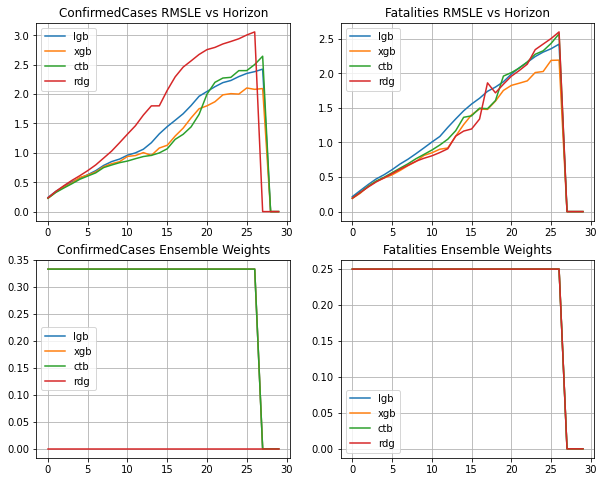

In [102]:
plt.figure(figsize=(10, 8))
for i in range(ny):
    plt.subplot(2,2,1+i)
    plt.plot(rallv[:,i])
    plt.title(ynames[i] + ' RMSLE vs Horizon')
    plt.grid()
    plt.legend(booster)
    
    plt.subplot(2,2,3+i)
    plt.plot(nls[:,i])
    plt.title(ynames[i] + ' Ensemble Weights')
    plt.grid()
    plt.legend(booster+tfeats[i])
plt.show()

In [103]:
# compute validation rmsle

# original targets
d['y0r'] = np.log1p(d.ConfirmedCases)
d['y1r'] = np.log1p(d.Fatalities)

m = 0
locs = d.loc[:,['Loc']].drop_duplicates().reset_index(drop=True)
# locs = x_val.copy().reset_index(drop=True)
# print(locs.shape)
y_truea = []
y_preda = []

print(f'# {mname}')
for i in range(ny):
    y_true = []
    y_pred = []
    for j in range(nhorizon-skip):
        y_true.append(yallv[j][i])
        y_pred.append(pallv[j][i])
    y_true = np.stack(y_true)
    y_pred = np.stack(y_pred)
    # print(y_pred.shape)
    # make each series monotonic increasing
    for j in range(y_pred.shape[1]): 
        y_pred[:,j] = np.maximum.accumulate(y_pred[:,j])
    # copy updated predictions into main table
    for horizon in range(1+skip,nhorizon+1):
        vdate = ddate + timedelta(days=horizon)
        qval = d['Date'] == vdate.isoformat()
        d.loc[qval,yv[i]+'_pred'] = y_pred[horizon-1-skip]
    rmse = np.sqrt(mean_squared_error(y_pred, y_true))
    print(f'# {rmse:.6f}')
    m += rmse/2
    locs['rmse'+str(i)] = np.sqrt(np.mean((y_true-y_pred)**2, axis=0))
    y_truea.append(y_true)
    y_preda.append(y_pred)
print(f'# {m:.6f}')

# gbt5f


IndexError: list index out of range

In [104]:
# enforce monotonicity of forecasts in test set after last date in training
# loc = d['Loc'].unique()
locs1 = d['Loc'].drop_duplicates()
for loc in locs1:
    # q = (d.Loc==loc) & (d.ForecastId > 0)
    q = (d.Loc==loc) & (d.Date > tmax)
    # if skip, fill in last observed value
    if skip: qs0 = (d.Loc==loc) & (d.Date == dmax.isoformat())
    for yi in yv:
        yp = yi+'_pred'
        d.loc[q,yp] = np.maximum.accumulate(d.loc[q,yp])
        if skip:
            for j in range(skip):
                qs1 = (d.Loc==loc) & (d.Date == (dmax + timedelta(1+j)).isoformat())
                d.loc[qs1,yp] = d.loc[qs0,yi].values

In [105]:
# kaz post-processing functions
def decay_4_first_10_then_1_f(array):
    arr=[1.0 for k in range(len(array))]
    for j in range(len(array)):
        if j<10:
            arr[j]=1. + (max(1,array[j])-1.)/4.
        else :
            arr[j]=1.
    return arr

def decay_16_first_10_then_1_f(array):
    arr=[1.0 for k in range(len(array))]
    for j in range(len(array)):
        if j<10:
            arr[j]=1. + (max(1,array[j])-1.)/16.
        else :
            arr[j]=1.
    return arr	
            
def decay_2_f(array):
    arr=[1.0 for k in range(len(array))]    
    for j in range(len(array)):
            arr[j]=1. + (max(1,array[j])-1.)/2.
    return arr 

def decay_4_f(array):
    arr=[1.0 for k in range(len(array))]    
    for j in range(len(array)):
            arr[j]=1. + (max(1,array[j])-1.)/4.
    return arr 	

def acceleratorx2_f(array):
    arr=[1.0 for k in range(len(array))]    
    for j in range(len(array)):
            arr[j]=1. + (max(1,array[j])-1.)*2.
    return arr 

def decay_1_5_f(array):
    arr=[1.0 for k in range(len(array))]    
    for j in range(len(array)):
            arr[j]=1. + (max(1,array[j])-1.)/1.5
    return arr            
           
def stay_same_f(array):
    arr=[1.0 for k in range(len(array))]      
    for j in range(len(array)):
        arr[j]=1.
    return arr   

def decay_2_last_12_linear_inter_f(array):
    arr=[1.0 for k in range(len(array))]
    for j in range(len(array)):
        arr[j]=1. + (max(1,array[j])-1.)/2.
    if len(array) >= 12:
        arr12 = (max(1,arr[-12])-1.)/12. 
        for j in range(0, 12):
            arr[len(arr)-12 +j]= max(1, 1 + ( (arr12*12) - (j+1)*arr12 ))
    return arr

def decay_4_last_12_linear_inter_f(array):
    arr=[1.0 for k in range(len(array))]
    for j in range(len(array)):
        arr[j]=1. + (max(1,array[j])-1.)/4.
    if len(array) >= 12:
        arr12 = (max(1,arr[-12])-1.)/12. 
        for j in range(0, 12):
            arr[len(arr)-12 +j]= max(1, 1 + ( (arr12*12) - (j+1)*arr12 ))
    return arr

def linear_last_12_f(array):
    arr=[1.0 for k in range(len(array))]
    for j in range(len(array)):
        arr[j]=max(1,array[j])
    if len(array) >= 12:
        arr12 = (max(1,arr[-12])-1.)/12. 
        for j in range(0, 12):
            arr[len(arr)-12 +j]= max(1, 1 + ( (arr12*12) - (j+1)*arr12 ))
    return arr
   
decay_4_first_10_then_1 =[ "Heilongjiang_China","Liaoning_China","Shanghai_China"]#, "Hong Kong_China"

decay_4_first_10_then_1_fatality=[]

decay_16_first_10_then_1 =["Beijing_China","Fujian_China","Guangdong_China","Shandong_China","Sichuan_China","Zhejiang_China"]
decay_16_first_10_then_1_fatality=[]

decay_4=["nan_Bhutan","nan_Burundi","nan_Cabo Verde","Prince Edward Island_Canada",
"nan_Central African Republic","Inner Mongolia_China","nan_Maldives","Falkland Islands (Malvinas)_United Kingdom"]

decay_4_fatality=["nan_Congo (Kinshasa)"]

decay_2 =["nan_Congo (Kinshasa)","Faroe Islands_Denmark","nan_Eritrea","French Guiana_France","nan_Korea, South","nan_MS Zaandam"]
decay_2_fatality=[]

stay_same=["nan_Diamond Princess","nan_Timor-Leste"]
  
stay_same_fatality=["Beijing_China","Fujian_China","Guangdong_China","Shandong_China",
"Sichuan_China","Zhejiang_China", "Heilongjiang_China","Liaoning_China","Shanghai_China"]#

normal=[]
normal_fatality=["nan_Korea, South","New York_US"]

decay_4_last_12_linear_inter =[ "Greenland_Denmark","nan_Dominica","nan_Equatorial Guinea","nan_Eswatini","New Caledonia_France",
"Saint Barthelemy_France","St Martin_France","nan_Gambia","nan_Grenada","nan_Holy See","nan_Mauritania","nan_Namibia","nan_Nicaragua"
,"nan_Papua New Guinea","nan_Saint Lucia","nan_Saint Vincent and the Grenadines","nan_Seychelles","nan_Sierra Leone","nan_Somalia","nan_Suriname",
"Anguilla_United Kingdom","British Virgin Islands_United Kingdom","Montserrat_United Kingdom","Turks and Caicos Islands_United Kingdom",
"nan_Zimbabwe", "Hong Kong_China","Curacao_Netherlands",
"Saint Pierre and Miquelon_France","nan_South Sudan","nan_Western Sahara",
"nan_Malawi","Bonaire, Sint Eustatius and Saba_Netherlands","nan_Sao Tome and Principe"
]

decay_4_last_12_linear_inter_fatality=[]

decay_2_last_12_linear_inter =[ "nan_Chad",
"nan_Congo (Brazzaville)","nan_Fiji","French Polynesia_France","nan_Gabon",
"nan_Guyana","nan_Laos","nan_Nepal","Sint Maarten_Netherlands",
"nan_Saint Kitts and Nevis","nan_Sudan","nan_Syria","nan_Tanzania",
"Bermuda_United Kingdom","Cayman Islands_United Kingdom","nan_Zambia","Northwest Territories_Canada","Yukon_Canada"
,"nan_Mongolia","nan_Uganda"]
decay_2_last_12_linear_inter_fatality=[]

acceleratorx2=[]
acceleratorx2_fatality=[]


warm_st=['nan_Angola','nan_Antigua and Barbuda','Northern Territory_Australia','nan_Bahamas',
'nan_Bangladesh','nan_Belize','nan_Benin','nan_Botswana','nan_Burundi','nan_Cabo Verde','nan_Cameroon',
'nan_Central African Republic','nan_Chad','Hong Kong_China',"nan_Cote d'Ivoire",'nan_Cuba','Greenland_Denmark',
'nan_Dominica','nan_Equatorial Guinea','nan_Eritrea','nan_Eswatini','nan_Fiji','French Polyneta_France','New Caledonia_France',
'Saint Barthelemy_France','St Martin_France','nan_Gabon','nan_Gambia','nan_Grenada','nan_Guyana','nan_Haiti','nan_Holy See',
'nan_Honduras','nan_Ireland','nan_Korea, South','nan_Laos','nan_Liberia','nan_Libya','nan_Maldives','nan_Mali',
'nan_Mauritania','nan_Mauritius','nan_Mongolia','nan_Mozambique','nan_Namibia','nan_Nepal','Aruba_Netherlands',
'nan_Nicaragua','nan_Niger','nan_Papua New Guinea','nan_Saint Kitts and Nevis','nan_Saint Lucia',
'nan_Saint Vincent and the Grenadines','nan_Seychelles','nan_Sierra Leone','nan_Somalia',
'nan_Spain','nan_Sudan','nan_Suriname','nan_Syria','nan_Tanzania','nan_Togo','nan_Uganda','Anguilla_United Kingdom',
'Bermuda_United Kingdom','British Virgin Islands_United Kingdom','Channel Islands_United Kingdom',
'Gibraltar_United Kingdom','Isle of Man_United Kingdom','Montserrat_United Kingdom','nan_United Kingdom',
'Turks and Caicos Islands_United Kingdom','nan_Uzbekistan','nan_Zimbabwe',
'Saint Pierre and Miquelon_France','nan_South Sudan','nan_Western Sahara',
'nan_Malawi','Bonaire, Sint Eustatius and Saba_Netherlands','nan_Sao Tome and Principe',
'Falkland Islands (Malvinas)_United Kingdom'
]


decay_1_5 =["nan_Angola" ,"nan_Antigua and Barbuda","Montana_US","Nebraska_US","nan_Bangladesh","Illinois_US"
,"Northern Territory_Australia","nan_Bahamas","nan_Bahrain","nan_Barbados" ,"nan_Belize","nan_Benin",
 "nan_Botswana","nan_Brunei","Manitoba_Canada","New Brunswick_Canada","Saskatchewan_Canada",
 "nan_Cote d'Ivoire","nan_France","nan_Guinea-Bissau","nan_Haiti","nan_Italy","nan_Libya","nan_Malta","nan_Mauritius",
 "Aruba_Netherlands","nan_Niger","nan_Spain","nan_Togo","Guam_US","Iowa_US","Idaho_US","Connecticut_US","California_US","New York_US","Virgin Islands_US",
 "Channel Islands_United Kingdom","Gibraltar_United Kingdom","Isle of Man_United Kingdom","nan_United Kingdom",'nan_Burma']

decay_1_5_fatality=["nan_Cameroon","nan_Mali","nan_Cuba","Delaware_US","District of Columbia_US",
"Kansas_US","Louisiana_US","Michigan_US","New Mexico_US","Ohio_US","Oklahoma_US","Pennsylvania_US","Puerto Rico_US","Rhode Island_US",
"South Dakota_US" ,"Tennessee_US","Texas_US","Vermont_US","Virginia_US","West Virginia_US","nan_Uzbekistan"]

linear_last_12=["nan_Honduras","nan_Ireland","Colorado_US","nan_Liberia","nan_Mozambique"]
linear_last_12_fatality=[]

In [106]:
# kaz post-processsing overrides
# works on predictions from one location, using his key naming convention as above
# i = 0 for confirmed and 1 for fatalities
# current_prediction is the predicted value one day prior to the series
# inputs assumed to be on log(1+x) scale and the return array is also on that scale
def kpp(i, name, preds, current_prediction):

    current_prediction = np.expm1(current_prediction)
    if current_prediction==0: current_prediction = 0.1
        
    # transform to successive ratios, which is what kaz models
    preds = np.expm1(preds)
    preds = np.clip(preds,0.1,None)
    preds[1:] = preds[1:] / preds[:-1]
    preds[0] /= current_prediction
        
    this_preds = preds.tolist()
    
    reserve = this_preds[0]
    
    # fatality special
    fdone = True
    if i==1:
        if name in normal_fatality:
            this_preds=this_preds

        elif name in decay_4_first_10_then_1_fatality:
            this_preds=decay_4_first_10_then_1_f(this_preds) 

        elif name in decay_16_first_10_then_1_fatality:
            this_preds=decay_16_first_10_then_1_f(this_preds)

        elif name in decay_4_last_12_linear_inter_fatality:
            this_preds=decay_4_last_12_linear_inter_f(this_preds)         

        elif name in decay_4_fatality:
            this_preds=decay_4_f(this_preds)

        elif name in decay_2_fatality:
            this_preds=decay_2_f(this_preds)        

        elif name in decay_2_last_12_linear_inter_fatality:
            this_preds=decay_2_last_12_linear_inter_f(this_preds)

        elif name in decay_1_5_fatality:
            this_preds=decay_1_5_f(this_preds) 

        elif name in linear_last_12_fatality:
            this_preds=linear_last_12_f(this_preds) 

        elif name in acceleratorx2_fatality:
            this_preds=acceleratorx2_f(this_preds)

        elif name in stay_same_fatality:     
            this_preds=stay_same_f(this_preds) 
            
        else:
            fdone = False
            
    if (i==0) or not fdone:

        if name in normal:
            this_preds=this_preds

        elif name in decay_4_first_10_then_1:
            this_preds=decay_4_first_10_then_1_f(this_preds)

        elif name in decay_16_first_10_then_1:
            this_preds=decay_16_first_10_then_1_f(this_preds)

        elif name in decay_4_last_12_linear_inter:
            this_preds=decay_4_last_12_linear_inter_f(this_preds)       

        elif name in decay_4:
            this_preds=decay_4_f(this_preds)

        elif name in decay_2:
            this_preds=decay_2_f(this_preds)

        elif name in decay_2_last_12_linear_inter:
            this_preds=decay_2_last_12_linear_inter_f(this_preds)

        elif name in decay_1_5:
            this_preds=decay_1_5_f(this_preds)        

        elif name in linear_last_12:
            this_preds=linear_last_12_f(this_preds)

        elif name in acceleratorx2:
            this_preds=acceleratorx2_f(this_preds)         

        elif name in stay_same or  "China" in name:
            this_preds=stay_same_f(this_preds)      

    if name in warm_st:
        this_preds[0]=reserve
        
    n = len(this_preds)
    p = np.ones(n)
        
    for j in range(n):
        current_prediction *= max(1,this_preds[j])
        p[j] = current_prediction
        
    p = np.log1p(p)
        
    return p

In [107]:
ddate

datetime.date(2020, 3, 18)

In [108]:
# compute adjusted validation rmsle

# starting prediction from last day of validation training
qvt = (d.Date == ddate.isoformat())
# query to subset data to validation range
dvlow = ddate + timedelta(1+skip)
dvupp = ddate + timedelta(nhorizon)
qvd = (dvlow.isoformat() <= d.Date) & (d.Date <= dvupp.isoformat())

# starting prediction from last day of full training
qst = (d.Date == dmax.isoformat())
# query to subset data to test range
dslow = dmax + timedelta(1+skip)
dsupp = dmax + timedelta(nhorizon)
qsd = (dslow.isoformat() <= d.Date) & (d.Date <= dsupp.isoformat())

print('#',dvlow, dvupp, dslow, dsupp)

keys = d['key'].drop_duplicates()
m = 0.0

print(f'# post-process {mname}')
for i in range(ny):
    ya = yv[i]+'_preda'
    d[ya] = np.nan  
    
    # loop over each location, post-process, and save back into main table
    for k in keys:
        # validation
        qvp = (d.key==k) & qvd
        qvs = (d.key==k) & qvt
        pred = d.loc[qvp,yv[i]+'_pred'].values
        start = d.loc[qvs,yv[i]].values
        preda = kpp(i, k, pred, start)
        d.loc[qvp, ya] = preda
        
        # test
        qsp = (d.key==k) & qsd
        qss = (d.key==k) & qst
        pred = d.loc[qsp,yv[i]+'_pred'].values
        start = d.loc[qss,yv[i]].values
        preda = kpp(i, k, pred, start)
        d.loc[qsp, ya] = preda
        
        
    # rmse = np.sqrt(mean_squared_error(d.loc[qd,ya], d.loc[qd,yv[i]]))
    rmse = np.sqrt(mean_squared_error(d.loc[qvd,ya], d.loc[qvd,yv[i]+'r']))
    print(f'# {rmse:.6f}')
    m += rmse/2
    
print(f'# {m:.6f}')

# 2020-03-19 2020-04-17 2020-04-18 2020-05-17
# post-process gbt5f
# 1.138900
# 1.289753
# 1.214327


In [109]:
# sort to find worst predictions of y0
locs = locs.sort_values('rmse0', ascending=False)
locs[:10]

KeyError: 'rmse0'

In [110]:
# plot worst fits of y0
for i in range(5):
    li = locs.index[i]
    plt.plot(y_truea[0][:,li])
    plt.plot(y_preda[0][:,li])
    plt.title(locs.loc[li,'Loc'])
    plt.show()

IndexError: list index out of range

In [111]:
# plt.plot(d.loc[d.Loc=='Belgium','y0'][39:])

In [112]:
# sort to find worst predictions of y1
locs = locs.sort_values('rmse1', ascending=False)
locs[:10]

KeyError: 'rmse1'

In [113]:
# plot worst fits of y1
for i in range(5):
    li = locs.index[i]
    plt.plot(y_truea[1][:,li])
    plt.plot(y_preda[1][:,li])
    plt.title(locs.loc[li,'Loc'])
    plt.show()

IndexError: list index out of range

In [114]:
dmax

datetime.date(2020, 4, 17)

In [115]:
tmax

'2020-04-17'

In [116]:
fmin

'2020-04-02'

In [117]:
# compute public lb score
if not prev_test:
    # q = (d.Date >= fmin) & (d.Date > ddate.isoformat()) & (d.Date <= tmax)
    q = (d.Date >= '2020-04-02') & (d.Date <= tmax)
    # q = (d.Date >= tmax) & (d.Date <= tmax)
    print(f'# {fmin} {ddate.isoformat()} {tmax} {sum(q)//ns} {mname}')
    s0 = np.sqrt(mean_squared_error(d.loc[q,'y0r'],d.loc[q,'y0_pred']))
    s1 = np.sqrt(mean_squared_error(d.loc[q,'y1r'],d.loc[q,'y1_pred']))
    print(f'# CC \t {s0:.6f}')
    print(f'# Fa \t {s1:.6f}')
    print(f'# Mean \t {(s0+s1)/2:.6f}')
    
    s0 = np.sqrt(mean_squared_error(d.loc[q,'y0r'],d.loc[q,'y0_preda']))
    s1 = np.sqrt(mean_squared_error(d.loc[q,'y1r'],d.loc[q,'y1_preda']))
    print()
    print(f'# CC \t {s0:.6f}')
    print(f'# Fa \t {s1:.6f}')
    print(f'# Mean \t {(s0+s1)/2:.6f}')

# 2020-04-02 2020-03-18 2020-04-17 16 gbt5f


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [118]:
# d.loc[d.Date=='2020-04-08',['ForecastId','y0_pred','y1_pred']]

In [119]:
# sub = d.loc[d.ForecastId > 0, ['ForecastId','ConfirmedCases','Fatalities',
#                            'y0','y1','y0_preda','y1_preda','Date','dint']]
# sub.describe()

In [120]:
# nnls to estimate blending weights
if blend:
    print('blending with',blender)
    sub = d.loc[d.ForecastId > 0, ['ForecastId','ConfirmedCases','Fatalities',
                                   'y0','y1','y0_preda','y1_preda','Date','dint']]
    sub['dint'] = sub['dint'] - sub['dint'].min()
    # original data, nonmonotonic in some places
    sub['y0r'] = np.log1p(sub.ConfirmedCases)
    sub['y1r'] = np.log1p(sub.Fatalities)
    sub['ConfirmedCases'] = sub.ConfirmedCases.astype(float)
    sub['Fatalities'] = sub.Fatalities.astype(float)

    print(sub.shape)
    print(sub['dint'].describe())
    hmax = np.max(sub.dint.values) + 1
    print(hmax)
    
    # add nq
    bs = pd.read_csv(path+blender[0]+'.csv')
    print(bs.shape)
    bs['nq0'] = np.log1p(bs.ConfirmedCases)
    bs['nq1'] = np.log1p(bs.Fatalities)
    bs.drop(['ConfirmedCases','Fatalities'],axis=1,inplace=True)
    sub = sub.merge(bs, how='left', on='ForecastId')
    sub['nq0'] = sub['nq0'].fillna(sub['y0'])
    sub['nq1'] = sub['nq1'].fillna(sub['y1'])

    # add kaz
    bs = pd.read_csv(path+blender[1]+'.csv')
    print(bs.shape)
    bs['kaz0'] = np.log1p(bs.ConfirmedCases)
    bs['kaz1'] = np.log1p(bs.Fatalities)
    bs.drop(['ConfirmedCases','Fatalities'],axis=1,inplace=True)
    sub = sub.merge(bs, how='left', on='ForecastId')
    
    for i in range(ny): sub[mname+str(i)] = sub[yv[i]+'_preda']
        
    # qv = (sub.Date >= '2020-04-09') & (sub.Date <= tmax)
    qv = (sub.Date > tmax)
    a = sub[qv].copy()

#     # intercept estimate is 0
#     # a['intercept0'] = 1.0
#     # a['intercept1'] = 1.0
#     # m = ['intercept','b0g','v0e','o0e',mname]
#     # m = ['kaz',mname]
#     m = ['nq','kaz',mname]
#     print(m)
#     n = a.shape[0]
#     wt= np.zeros((2,len(m)))
#     s = 0
#     for i in range(ny):
#         mi = [c+str(i) for c in m]
#         wt[i], rnorm = nnls(a[mi].values, a[yv[i]+'r'].values)
#         r = rnorm/np.sqrt(n)
#         print(i, wt[i], f'{sum(wt[i]):.6f}', f'{r:.6f}')
#         s += 0.5*r
#     print(f'{s:.6f}')
#     print()
    print(a[['nq0','kaz0',mname+'0','nq1','kaz1',mname+'1']].corr())

blending with ['nq0j_updated', 'kaz0z']
(13459, 11)
count    13459.000000
mean        21.000000
std         12.410135
min          0.000000
25%         10.000000
50%         21.000000
75%         32.000000
max         42.000000
Name: dint, dtype: float64
43
(9390, 3)
(13459, 3)
             nq0      kaz0    gbt5f0       nq1      kaz1    gbt5f1
nq0     1.000000  0.994356  0.993622  0.922536  0.927122  0.927022
kaz0    0.994356  1.000000  0.995279  0.913255  0.920929  0.920621
gbt5f0  0.993622  0.995279  1.000000  0.914566  0.921345  0.925099
nq1     0.922536  0.913255  0.914566  1.000000  0.995110  0.993356
kaz1    0.927122  0.920929  0.921345  0.995110  1.000000  0.993851
gbt5f1  0.927022  0.920621  0.925099  0.993356  0.993851  1.000000


In [121]:
#              nq0      kaz0    gbt5c0       nq1      kaz1    gbt5c1
# nq0     1.000000  0.994898  0.990380  0.921206  0.925135  0.928614
# kaz0    0.994898  1.000000  0.993709  0.912327  0.919076  0.922941
# gbt5c0  0.990380  0.993709  1.000000  0.910899  0.915789  0.926058
# nq1     0.921206  0.912327  0.910899  1.000000  0.995339  0.993934
# kaz1    0.925135  0.919076  0.915789  0.995339  1.000000  0.994931
# gbt5c1  0.928614  0.922941  0.926058  0.993934  0.994931  1.000000


In [122]:
# ['nq', 'kaz', 'gbt5a']
# 0 [0.459556 0.236734 0.300961] 0.997251 0.151962
# 1 [0.665729 0.12441  0.20578 ] 0.995918 0.157286
# 0.154624

In [123]:
# create blended submission, set weights by hand after looking at validation nnls
if blend:
    # blend
    sub['ConfirmedCases'] = np.expm1(0.997*(0.5 * sub['nq0'] + \
                                            0.2 * sub['kaz0'] + \
                                            0.3 * sub['y0_preda']))
    sub['Fatalities'] = np.expm1(0.996*(0.666666 * sub['nq1'] + \
                                        0.133333 * sub['kaz1'] + \
                                        0.2      * sub['y1_preda']))
            
else:
    # create submission without any blending with others
    sub = d.loc[d.ForecastId > 0, ['ForecastId','y0_pred','y1_pred']]
    print(sub.shape)

    sub['ConfirmedCases'] = np.expm1(sub['y0_preda'])
    sub['Fatalities'] = np.expm1(sub['y1_preda'])    

sub0 = sub.copy()
print(sub0.shape)
sub = sub[['ForecastId','ConfirmedCases','Fatalities']]

os.makedirs('sub',exist_ok=True)
fname = mname + '.csv'
sub.to_csv(fname, index=False)
print(fname, sub.shape)

(13459, 17)
gbt5f.csv (13459, 3)


In [124]:
sub.describe()

ForecastId  ConfirmedCases    Fatalities
count  13459.000000    13459.000000  13459.000000
mean    6730.000000     8015.260821    554.604123
std     3885.422971    28649.852784   2948.405189
min        1.000000        0.046915      0.005587
25%     3365.500000       90.306954      1.445767
50%     6730.000000      604.058041      8.881327
75%    10094.500000     3197.952824     79.638989
max    13459.000000   387166.756673  38876.917741

In [125]:
# final day adjustment as per northquay
pname = mname
pred = sub.copy()
# pred = pd.read_csv(mname + '.csv')

# pname = 'kaz0m'
# pred = pd.read_csv('../week3/sub/'+pname+'.csv')

pred_orig = pred.copy()

if prev_test:
    test = pd.read_csv('../'+pw+'/test.csv')
else:
    test = pd.read_csv(pathk+'test.csv')

test[cp] = test[cp].fillna('')

# test.Date = pd.to_datetime(test.Date)
# train.Date = pd.to_datetime(train.Date)

# TODAY = datetime.datetime(  *datetime.datetime.today().timetuple()[:3] )
# TODAY = date(2020, 4, 7)

# shift day back one to match wm adjustment

print(TODAY)

final_day = wm[wm.Date == TODAY].copy()
final_day['cases_final'] = np.expm1(final_day.TotalCases)
final_day['cases_chg'] = np.expm1(final_day.NewCases)
final_day['deaths_final'] = np.expm1(final_day.TotalDeaths)
final_day['deaths_chg'] = np.expm1(final_day.NewDeaths)


# test.rename(columns={'Country_Region': 'Country'}, inplace=True)
# test['Place'] = test.Country +  test.Province_State.fillna("")

# final_day = pd.read_excel(path + '../week3/nq/' + 'final_day.xlsx')
# final_day = final_day.iloc[1:, :5]
# final_day = final_day.fillna(0)
# final_day.columns = ['Country', 'cases_final', 'cases_chg', 
#                      'deaths_final', 'deaths_chg']

final_day = final_day[['Country_Region','Province_State','cases_final','cases_chg',
                      'deaths_final','deaths_chg']].fillna(0)
# final_day = final_day.drop('Date', axis=1).reset_index(drop=True)
final_day = final_day.sort_values('cases_final', ascending=False)

print()
print('final_day')
print(final_day.head(n=10), final_day.shape)

# final_day.Country.replace({'Taiwan': 'Taiwan*',
#                            'S. Korea': 'Korea, South',
#                            'Myanmar': 'Burma',
#                            'Vatican City': 'Holy See',
#                            'Ivory Coast':  "Cote d'Ivoire",
                        
#                           },
#                          inplace=True)


pred = pd.merge(pred, test, how='left', on='ForecastId')
print()
print('pred')
print(pred.head(n=10), pred.shape)

# pred = pd.merge(pred, test[test.Province_State.isnull()], how='left', on='ForecastId')

# compare = pd.merge(pred[pred.Date == TODAY], final_day, on= [ 'Country'],
#                            validate='1:1')

compare = pd.merge(pred[pred.Date == TODAY], final_day, on=cp, validate='1:1')

compare['c_li'] = np.round(np.log(compare.cases_final + 1) - np.log(compare.ConfirmedCases + 1), 2)
compare['f_li'] = np.round(np.log(compare.deaths_final + 1) - np.log(compare.Fatalities + 1), 2)

print()
print('compare')
print(compare.head(n=10), compare.shape)
print(compare.describe())

# compare[compare.c_li > 0.3][['Country', 'ConfirmedCases', 'Fatalities',
#                                         'cases_final', 'cases_chg',
#                                     'deaths_final', 'deaths_chg',
#                                             'c_li', 'f_li']]

# compare[compare.c_li > 0.15][['Country', 'ConfirmedCases', 'Fatalities',
#                                         'cases_final', 'cases_chg',
#                                     'deaths_final', 'deaths_chg',
#                                             'c_li', 'f_li']]

# compare[compare.f_li > 0.3][['Country', 'ConfirmedCases', 'Fatalities',
#                                         'cases_final', 'cases_chg',
#                                     'deaths_final', 'deaths_chg',
#                                             'c_li', 'f_li']]


# compare[compare.f_li > 0.15][['Country', 'ConfirmedCases', 'Fatalities',
#                                         'cases_final', 'cases_chg',
#                                     'deaths_final', 'deaths_chg',
#                                             'c_li', 'f_li']]

# compare[compare.c_li < -0.15][['Country', 'ConfirmedCases', 'Fatalities',
#                                         'cases_final', 'cases_chg',
#                                     'deaths_final', 'deaths_chg',
#                                             'c_li', 'f_li']]

# compare[compare.f_li < -0.2][['Country', 'ConfirmedCases', 'Fatalities',
#                                         'cases_final', 'cases_chg',
#                                     'deaths_final', 'deaths_chg',
#                                             'c_li', 'f_li']]

fixes = pd.merge(pred[pred.Date >= TODAY], 
                     compare[cp + ['c_li', 'f_li']], on=cp)


fixes['c_li'] = np.where( fixes.c_li < 0,
                             0,
                                 fixes.c_li)
fixes['f_li'] = np.where( fixes.f_li < 0,
                             0,
                                 fixes.f_li)

fixes['total_fixes'] = fixes.c_li**2 + fixes.f_li**2

print()
print('most fixes')
print(fixes.groupby(cp).last().sort_values(['total_fixes','Date'], ascending = False).head(n=10))

# adjustment
fixes['Fatalities'] = np.round(np.exp((np.log(fixes.Fatalities + 1) + fixes.f_li))-1, 3)
fixes['ConfirmedCases'] = np.round(np.exp((np.log(fixes.ConfirmedCases + 1) + fixes.c_li))-1, 3)


fix_ids = fixes.ForecastId.unique()
len(fix_ids)

cols = ['ForecastId', 'ConfirmedCases', 'Fatalities']


fixed = pd.concat((pred.loc[~pred.ForecastId.isin(fix_ids),cols],
    fixes[cols])).sort_values('ForecastId')


# fixed.head()
# fixed.tail()

# len(pred_orig)
# len(fixed)

fname = pname + '_updated.csv'
fixed.to_csv(fname, index=False)
print(fname, fixed.shape)
fixed.describe()

2020-04-15

final_day
       Country_Region Province_State  cases_final  cases_chg  deaths_final  \
11688              US         Total:     642201.0    28315.0       28484.0   
11706              US      USA Total     642201.0    28315.0       28484.0   
11286              US       New York     213779.0    10656.0       11586.0   
9689            Spain                    177644.0     3584.0       18708.0   
6788            Italy                    165155.0     2667.0       21645.0   
5484           France                    147863.0     4560.0       17167.0   
5987          Germany                    134753.0     2543.0        3804.0   
12152  United Kingdom                     98476.0     4603.0       12868.0   
6575             Iran                     76389.0     1512.0        4777.0   
11228              US     New Jersey      71030.0     2206.0        3156.0   

       deaths_chg  
11688      2437.0  
11706      2437.0  
11286       752.0  
9689        453.0  
6788        578.0  

ForecastId  ConfirmedCases    Fatalities
count  13459.000000    13459.000000  13459.000000
mean    6730.000000    11744.537694    907.569801
std     3885.422971    47120.835362   4870.251788
min        1.000000        0.046915      0.005587
25%     3365.500000      120.771145      1.495500
50%     6730.000000      670.085729      9.846522
75%    10094.500000     3869.443312    106.855222
max    13459.000000   861656.689000  71930.794000

In [126]:
compare[compare.Country_Region=='US'].describe()

ForecastId  ConfirmedCases   Fatalities    cases_final     cases_chg  \
count     54.000000       54.000000    54.000000      54.000000     54.000000   
mean   11344.500000     6230.980372   273.157484   11785.722222    523.888889   
std      676.481707    13923.460309   908.536413   30513.380072   1481.759506   
min    10205.000000       43.916550     1.917898      51.000000      0.000000   
25%    10774.750000      909.605347    20.917130    1242.000000     51.000000   
50%    11344.500000     1883.580068    64.363999    3285.500000    134.500000   
75%    11914.250000     4983.981533   227.223146    9762.750000    431.750000   
max    12484.000000    96282.887773  6616.031737  213779.000000  10656.000000   

       deaths_final  deaths_chg       c_li       f_li  
count     54.000000   54.000000  54.000000  54.000000  
mean     526.481481   45.037037   0.410926   0.480370  
std     1627.420586  115.479960   0.322936   0.326074  
min        1.000000    0.000000  -0.390000  -0.380000  
25%       32.250000    1.000000   0.220000   0.255000  
50%      122.000000    7.500000   0.425000   0.525000  
75%      363.250000   40.000000   0.640000   0.615000  
max    11586.000000  752.000000   1.070000   1.190000

In [127]:
# fixed[5:15]

In [128]:
sum(qv)

8451

In [129]:
# sub

In [130]:
# merge final predictions back into main table
sub1 = fixed.copy()
for i in range(ny): 
    mi = mname + str(i)
    if mi in d.columns: d.drop(mi, axis=1, inplace=True)
    sub1[mi] = np.log1p(sub1[ynames[i]])
    sub1.drop(ynames[i],axis=1,inplace=True)
d = d.merge(sub1, how='left', on='ForecastId')

In [131]:
fixed.describe()

ForecastId  ConfirmedCases    Fatalities
count  13459.000000    13459.000000  13459.000000
mean    6730.000000    11744.537694    907.569801
std     3885.422971    47120.835362   4870.251788
min        1.000000        0.046915      0.005587
25%     3365.500000      120.771145      1.495500
50%     6730.000000      670.085729      9.846522
75%    10094.500000     3869.443312    106.855222
max    13459.000000   861656.689000  71930.794000

In [132]:
ddate

datetime.date(2020, 3, 18)

In [133]:
# compute public lb score after averaging with others
if not prev_test:
    # q = (d.Date >= fmin) & (d.Date > ddate.isoformat()) & (d.Date <= tmax)
    q = (d.Date >= '2020-04-02') & (d.Date <= tmax)
    # q = (d.Date >= tmax) & (d.Date <= tmax)
    print(f'# {fmin} {ddate.isoformat()} {tmax} {sum(q)/ns} {mname}')
    s0 = np.sqrt(mean_squared_error(d.loc[q,'y0r'],d.loc[q,mname+'0']))
    s1 = np.sqrt(mean_squared_error(d.loc[q,'y1r'],d.loc[q,mname+'1']))
    print(f'# CC \t {s0:.6f}')
    print(f'# Fa \t {s1:.6f}')
    print(f'# Mean \t {(s0+s1)/2:.6f}')

# 2020-04-02 2020-03-18 2020-04-17 16.0 gbt5f
# CC 	 0.376920
# Fa 	 0.296128
# Mean 	 0.336524


In [134]:
# save oof predictions
ovars = ['Id','ForecastId','Country_Region','Province_State','Loc',
         'y0','y1','y0_pred','y1_pred',mname+'0',mname+'1']
oof = d.loc[:,ovars]
# oof = oof.rename(mapper={'y0_pred':mname+'0','y1_pred':mname+'1'}, axis=1)
os.makedirs('oof',exist_ok=True)
fname = 'oof/' + mname + '.csv'
oof.to_csv(fname, index=False)
print(fname, oof.shape)

oof/gbt5f.csv (35682, 11)


In [135]:
if save_data:
    os.makedirs('data',exist_ok=True)
    fname = 'data/' + mname + '_d.csv'
    d.to_csv(fname, index=False)
    print(fname, d.shape)
    
    fname = 'data/' + mname + '_x_train.csv'
    x_train.to_csv(fname, index=False)
    print(fname, d.shape)
    
    fname = 'data/' + mname + '_x_val.csv'
    x_val.to_csv(fname, index=False)
    print(fname, d.shape)
    
    fname = 'data/' + mname + '_x_full.csv'
    x_full.to_csv(fname, index=False)
    print(fname, d.shape)
    
    fname = 'data/' + mname + '_x_test.csv'
    x_test.to_csv(fname, index=False)
    print(fname, d.shape)
    
#     fname = 'data/' + mname + '_y_train.csv'
#     y_train[0].to_csv(fname, index=False)
#     print(fname, d.shape)
    
#     fname = 'data/' + mname + '_y_val.csv'
#     y_val[0].to_csv(fname, index=False)
#     print(fname, d.shape)
    
#     fname = 'data/' + mname + '_y_full.csv'
#     y_full[0].to_csv(fname, index=False)
#     print(fname, d.shape)

In [136]:
# set(features[i]) - set(lags)

In [137]:
# set(lags) - set(features[i])

In [138]:
len(features[i])

407

In [139]:
x_train.shape

(17841, 486)

In [140]:
np.log(56)

4.02535169073515

In [141]:
pd.set_option('display.max_rows', 150)

In [142]:
# q = (d.Date >= '2020-04-02') & (d.Loc=='Cabo Verde')
# q = (d.Date >= '2020-04-02') & (d.Loc=='Congo (Brazzaville)')
q = (d.Date >= '2020-04-02') & (d.Loc=='Somalia')
d.loc[q,['Date','ForecastId','y0','y1','y0r','y1r',
                        mname + str(0),mname+str(1)]]

Date  ForecastId        y0        y1       y0r       y1r  \
25037 2020-04-02        9418  1.791759  0.000000  1.791759  0.000000   
25038 2020-04-03        9419  2.079442  0.000000  2.079442  0.000000   
25039 2020-04-04        9420  2.079442  0.000000  2.079442  0.000000   
25040 2020-04-05        9421  2.079442  0.000000  2.079442  0.000000   
25041 2020-04-06        9422  2.079442  0.000000  2.079442  0.000000   
25042 2020-04-07        9423  2.197225  0.000000  2.197225  0.000000   
25043 2020-04-08        9424  2.564949  0.693147  2.564949  0.693147   
25044 2020-04-09        9425  2.564949  0.693147  2.564949  0.693147   
25045 2020-04-10        9426  3.091042  0.693147  3.091042  0.693147   
25046 2020-04-11        9427  3.091042  0.693147  3.091042  0.693147   
25047 2020-04-12        9428  3.258097  0.693147  3.258097  0.693147   
25048 2020-04-13        9429  4.110874  1.098612  4.110874  1.098612   
25049 2020-04-14        9430  4.110874  1.098612  4.110874  1.098612   
25050 2020-04-15        9431  4.394449  1.791759  4.394449  1.791759   
25051 2020-04-16        9432  4.394449  1.791759  4.394449  1.791759   
25052 2020-04-17        9433  4.762174  1.945910  4.762174  1.945910   
25053 2020-04-18        9434       NaN       NaN       NaN       NaN   
25054 2020-04-19        9435       NaN       NaN       NaN       NaN   
25055 2020-04-20        9436       NaN       NaN       NaN       NaN   
25056 2020-04-21        9437       NaN       NaN       NaN       NaN   
25057 2020-04-22        9438       NaN       NaN       NaN       NaN   
25058 2020-04-23        9439       NaN       NaN       NaN       NaN   
25059 2020-04-24        9440       NaN       NaN       NaN       NaN   
25060 2020-04-25        9441       NaN       NaN       NaN       NaN   
25061 2020-04-26        9442       NaN       NaN       NaN       NaN   
25062 2020-04-27        9443       NaN       NaN       NaN       NaN   
25063 2020-04-28        9444       NaN       NaN       NaN       NaN   
25064 2020-04-29        9445       NaN       NaN       NaN       NaN   
25065 2020-04-30        9446       NaN       NaN       NaN       NaN   
25066 2020-05-01        9447       NaN       NaN       NaN       NaN   
25067 2020-05-02        9448       NaN       NaN       NaN       NaN   
25068 2020-05-03        9449       NaN       NaN       NaN       NaN   
25069 2020-05-04        9450       NaN       NaN       NaN       NaN   
25070 2020-05-05        9451       NaN       NaN       NaN       NaN   
25071 2020-05-06        9452       NaN       NaN       NaN       NaN   
25072 2020-05-07        9453       NaN       NaN       NaN       NaN   
25073 2020-05-08        9454       NaN       NaN       NaN       NaN   
25074 2020-05-09        9455       NaN       NaN       NaN       NaN   
25075 2020-05-10        9456       NaN       NaN       NaN       NaN   
25076 2020-05-11        9457       NaN       NaN       NaN       NaN   
25077 2020-05-12        9458       NaN       NaN       NaN       NaN   
25078 2020-05-13        9459       NaN       NaN       NaN       NaN   
25079 2020-05-14        9460       NaN       NaN       NaN       NaN   

         gbt5f0    gbt5f1  
25037  1.659608  0.021377  
25038  1.860382  0.021447  
25039  1.860382  0.021447  
25040  1.860382  0.023154  
25041  1.860382  0.023154  
25042  1.942582  0.023154  
25043  2.199218  0.575453  
25044  2.199218  0.575453  
25045  2.566378  0.575453  
25046  2.566378  0.575453  
25047  2.682965  0.575453  
25048  3.278118  0.898527  
25049  3.278118  0.898527  
25050  4.395794  1.794256  
25051  4.478926  1.820509  
25052  4.545272  1.862063  
25053  5.687324  2.439822  
25054  5.749753  2.420546  
25055  5.815923  2.458220  
25056  5.864387  2.488401  
25057  5.910978  2.518341  
25058  5.940079  2.543254  
25059  5.975711  2.596597  
25060  6.012744  2.632608  
25061  6.047126  2.674769  
25062  6.073114  2.736508  
25063  6.097953  2.799717  
25064  6.115994  2.838259  
25065  6.134567  2.881779  
250

In [143]:
# most fixes
#                                     ForecastId  ConfirmedCases   Fatalities  \
# Country_Region      Province_State                                            
# Cabo Verde                                1591       83.069233     2.661215   
# Congo (Brazzaville)                       3827      188.486683    10.366824   
# Jamaica                                   6364      310.090653     9.060071   
# Slovakia                                  9374     2407.449830    17.087912   
# Netherlands         Aruba                 7869      207.263786     1.729323   
# Timor-Leste                              10019       15.586367     0.892582   
# Tanzania                                  9933      250.855338    11.648181   
# Somalia                                   9460      213.936255    15.164921   
# Gabon                                     5375      169.672938     2.876582   
# US                  Maryland             11137    24302.549228  1205.949083   

#                                           Date  c_li  f_li  total_fixes  
# Country_Region      Province_State                                       
# Cabo Verde                          2020-05-14  0.49  0.00       0.2401  
# Congo (Brazzaville)                 2020-05-14  0.28  0.00       0.0784  
# Jamaica                             2020-05-14  0.18  0.03       0.0333  
# Slovakia                            2020-05-14 -0.00  0.17       0.0289  
# Netherlands         Aruba           2020-05-14  0.00  0.14       0.0196  
# Timor-Leste                         2020-05-14  0.13  0.00       0.0169  
# Tanzania                            2020-05-14  0.12  0.02       0.0148  
# Somalia                             2020-05-14  0.02  0.10       0.0104  
# Gabon                               2020-05-14  0.09  0.00       0.0081  
# US                  Maryland        2020-05-14  0.04  0.08       0.0080  

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


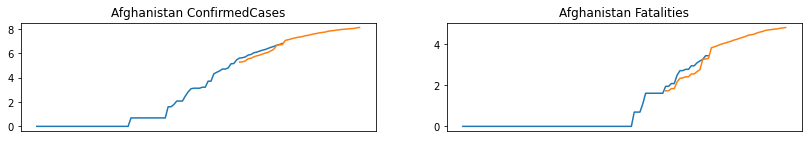

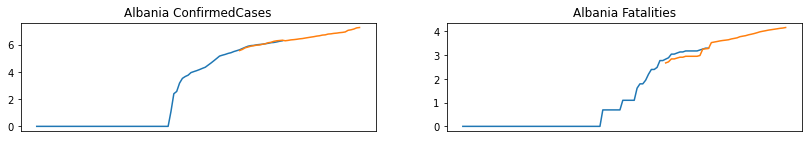

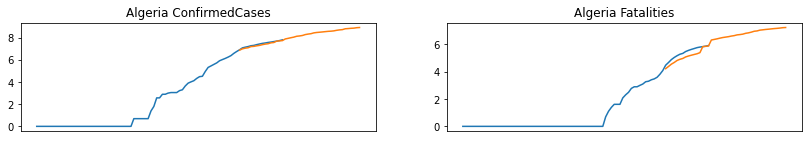

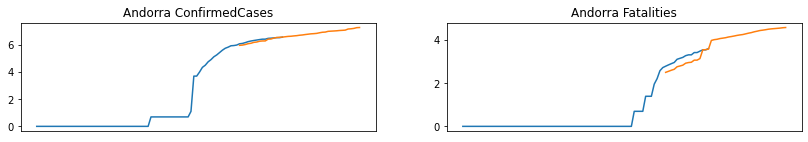

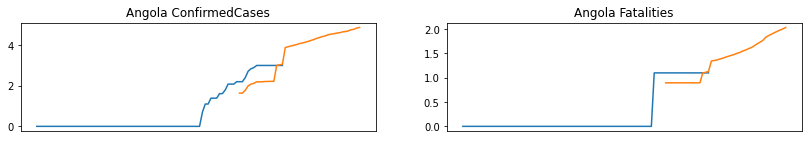

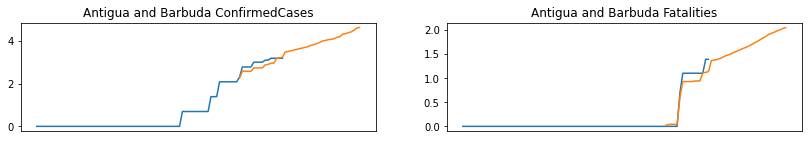

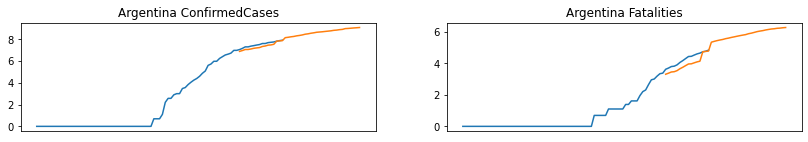

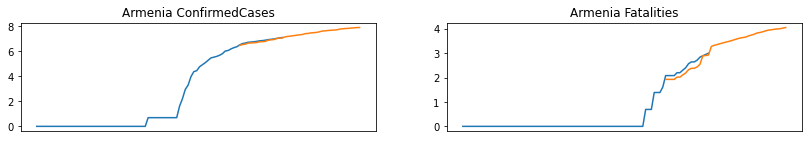

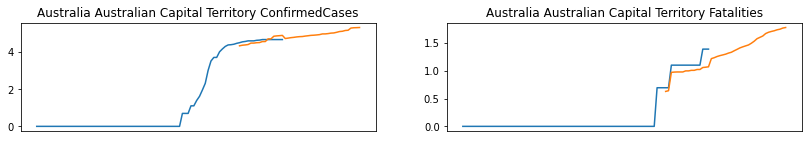

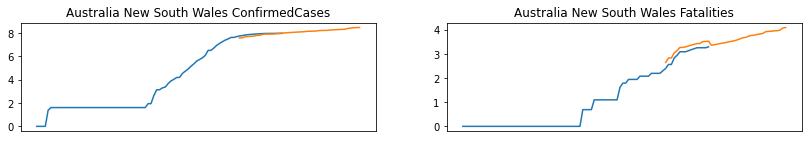

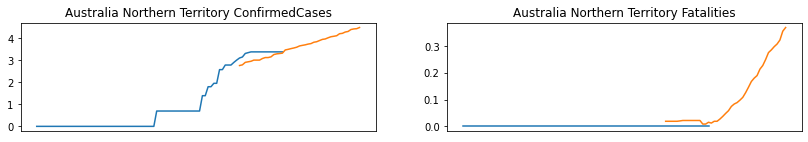

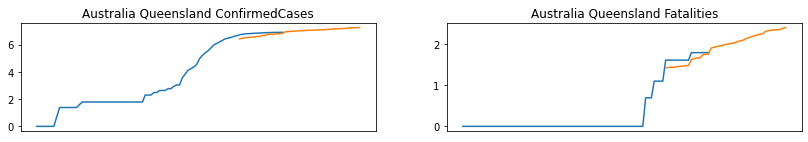

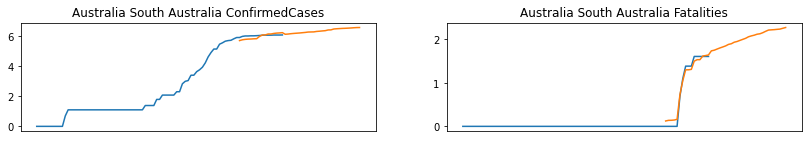

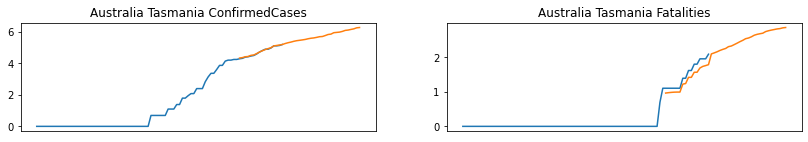

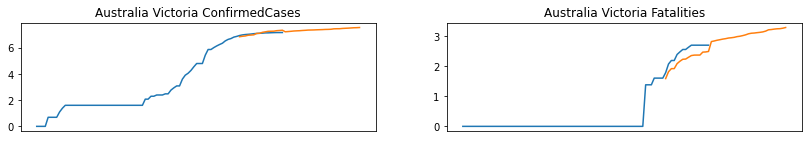

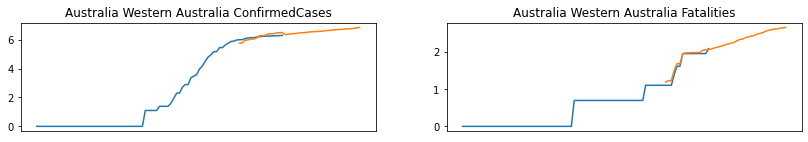

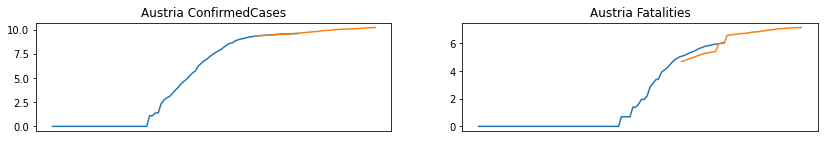

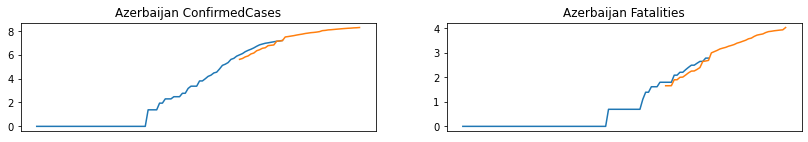

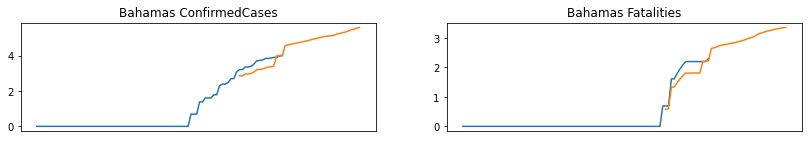

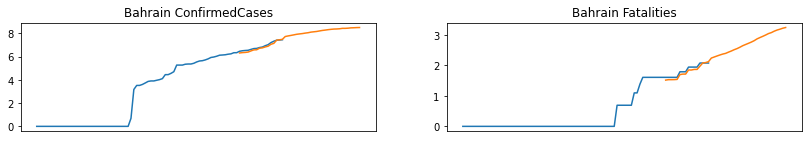

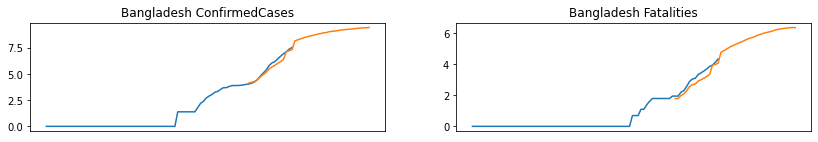

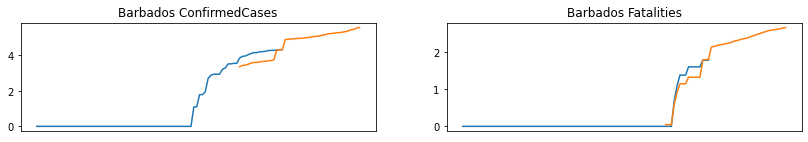

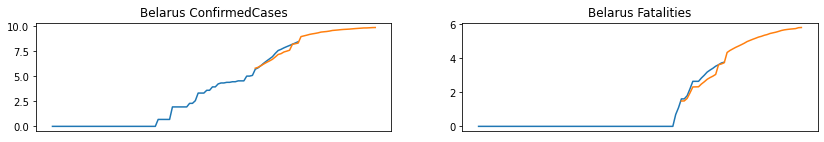

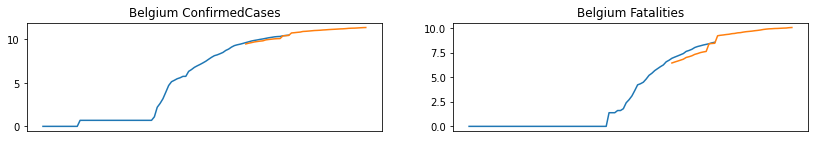

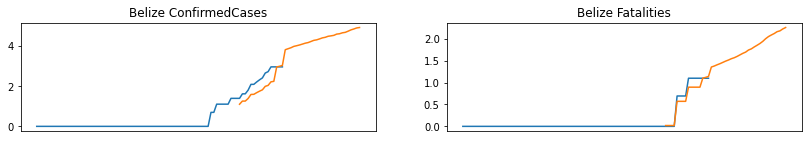

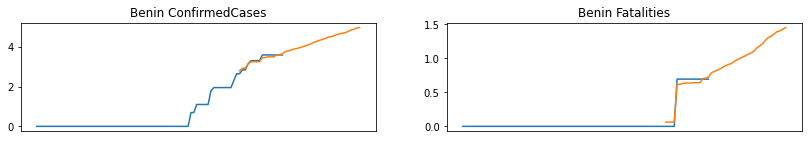

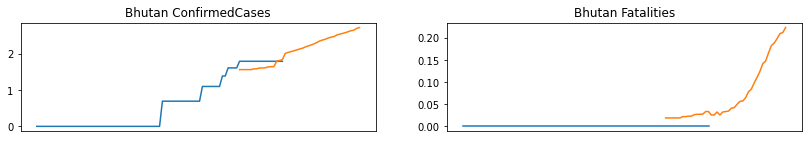

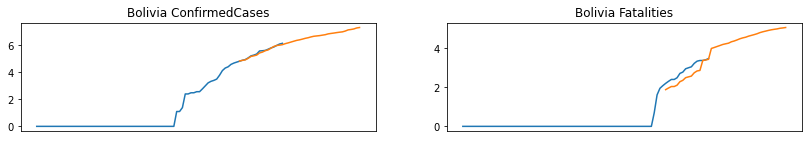

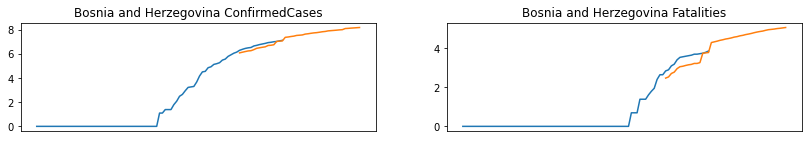

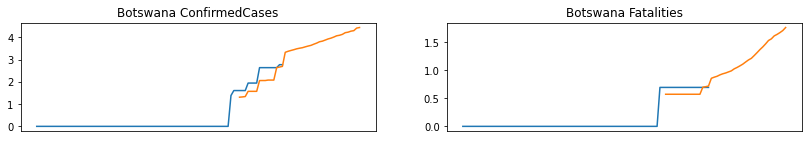

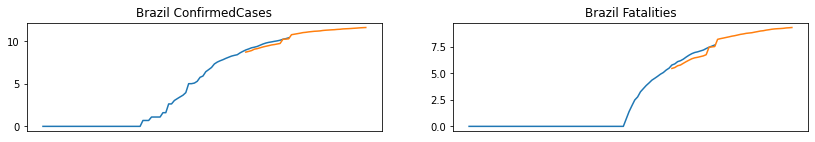

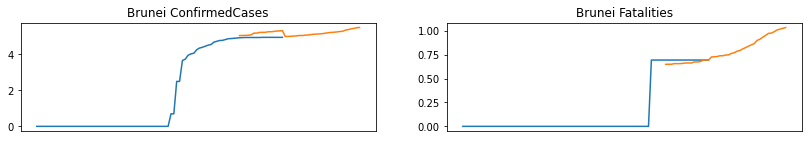

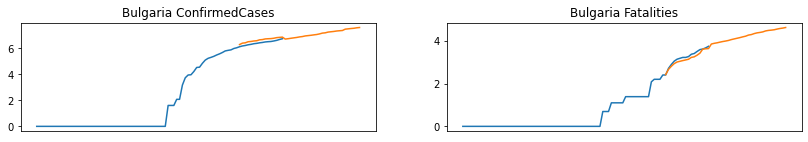

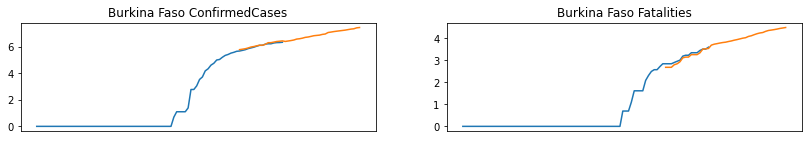

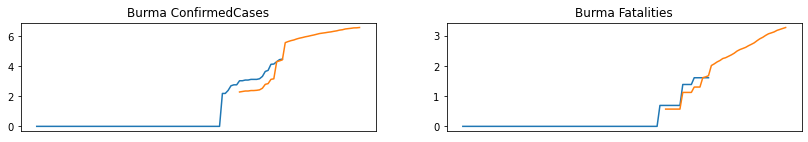

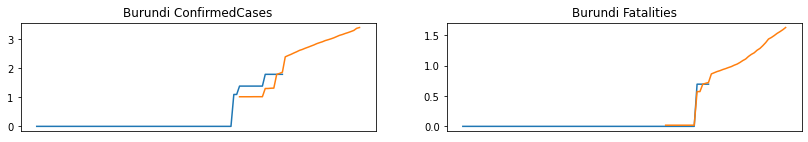

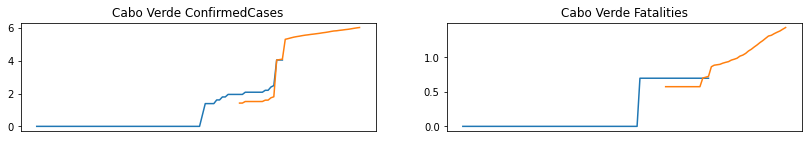

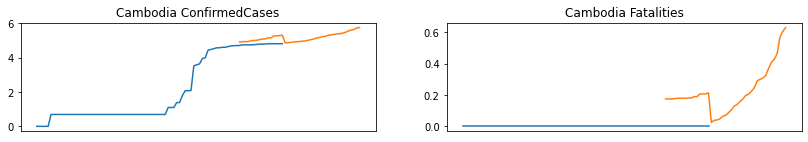

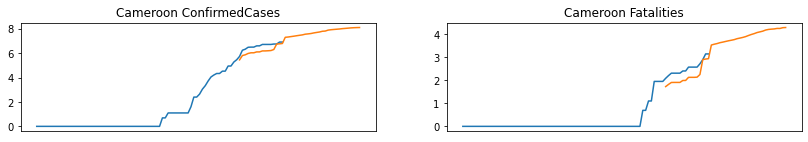

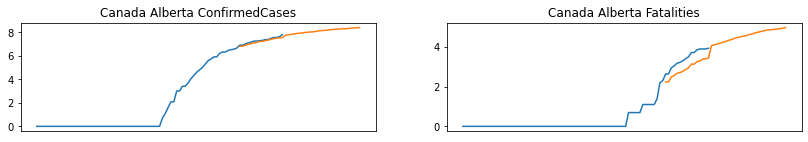

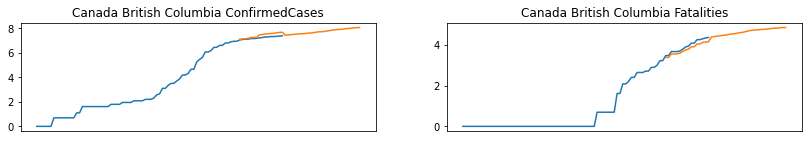

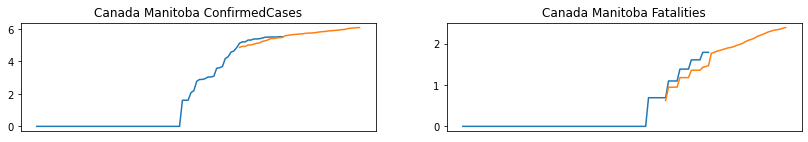

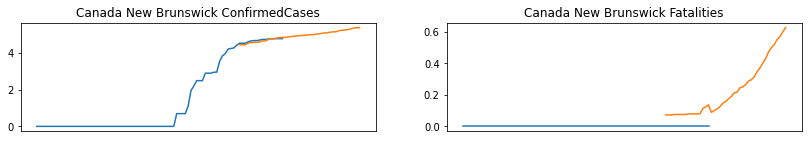

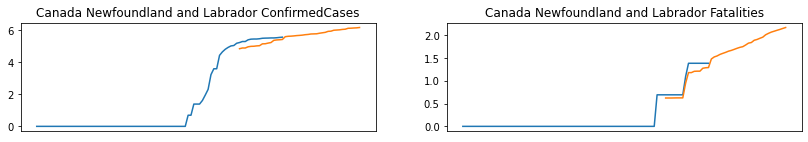

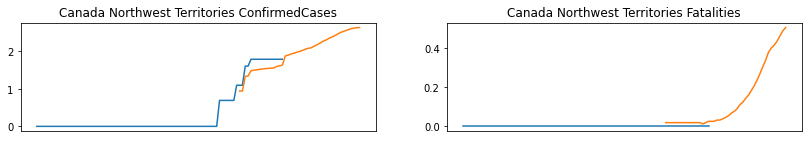

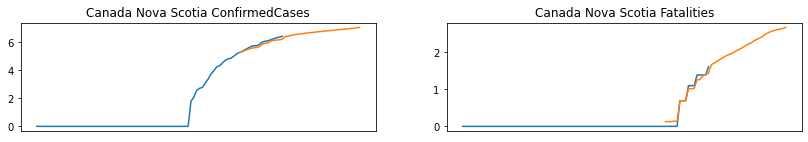

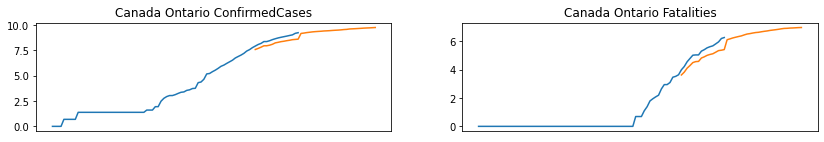

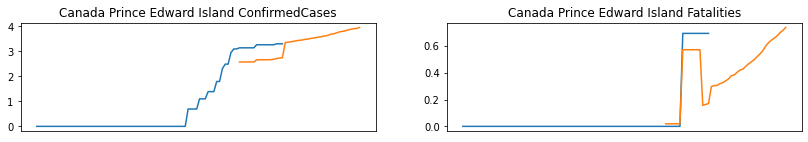

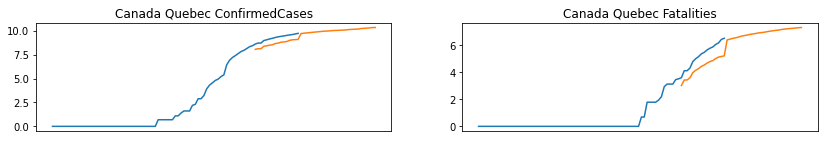

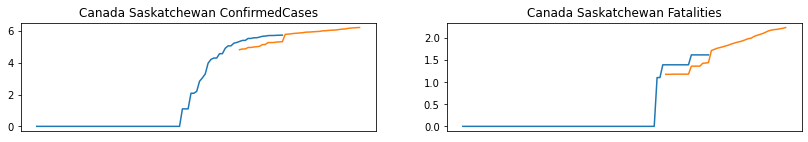

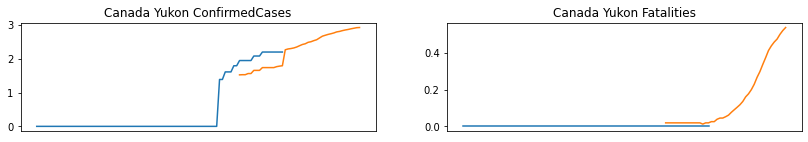

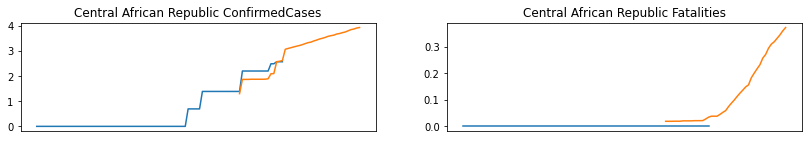

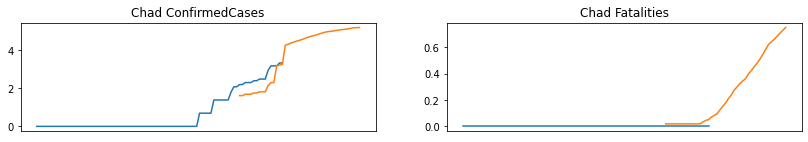

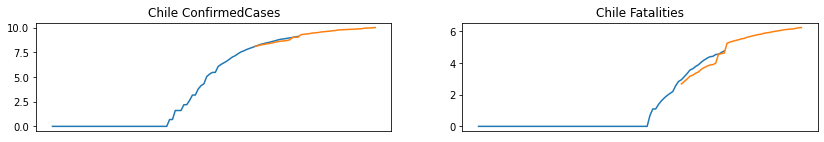

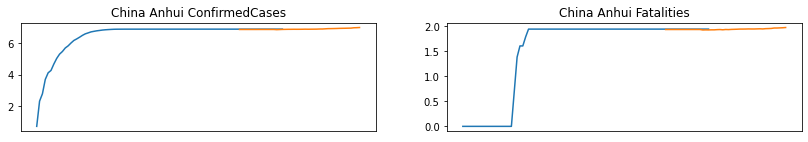

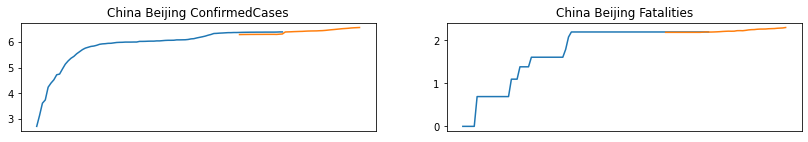

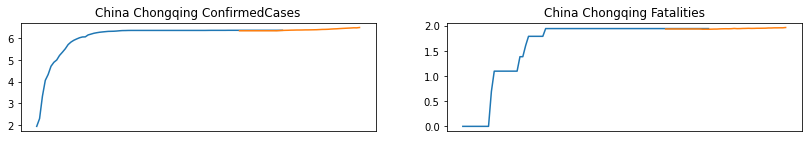

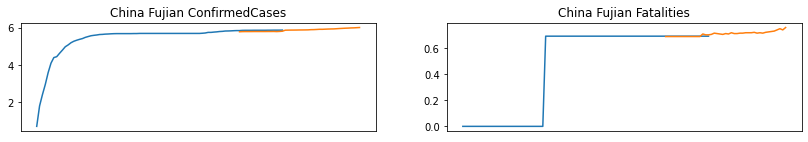

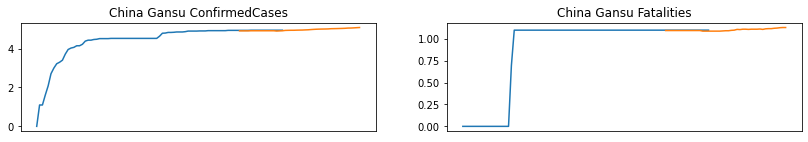

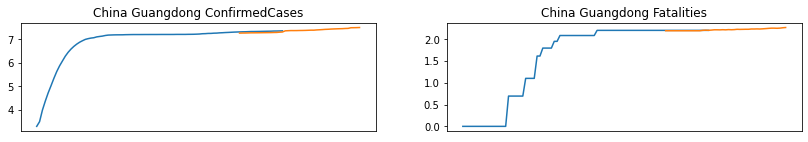

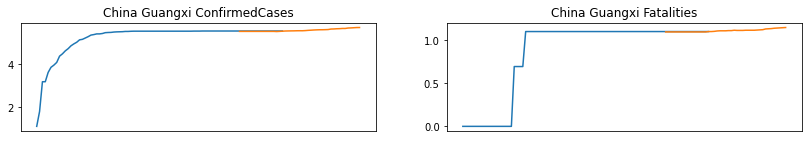

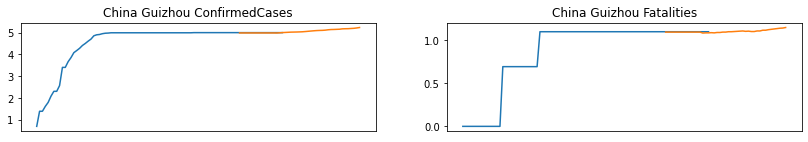

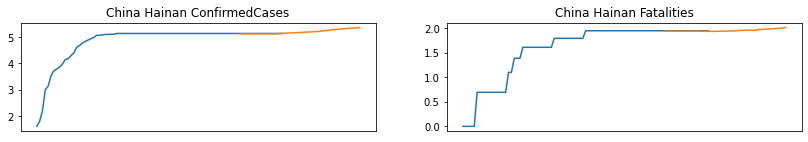

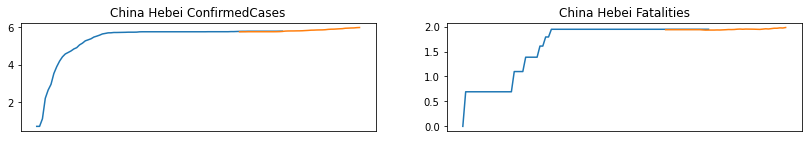

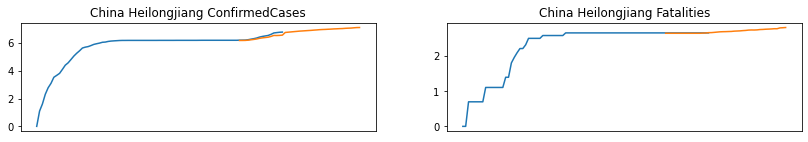

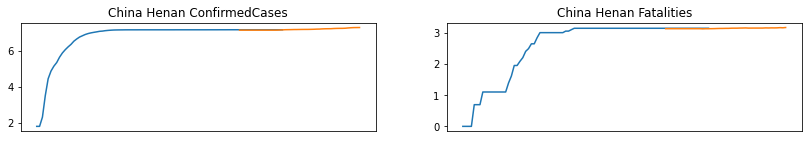

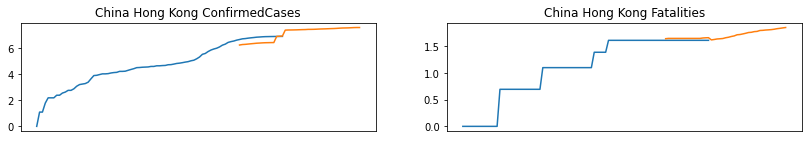

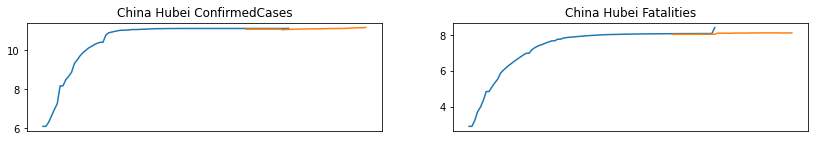

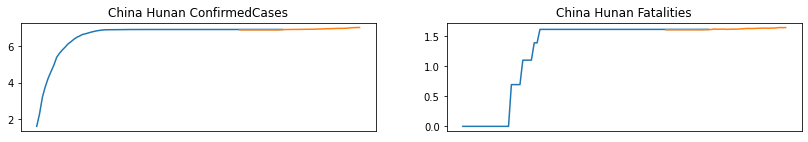

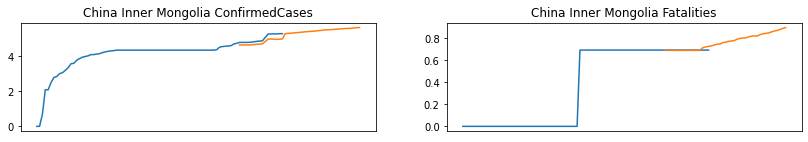

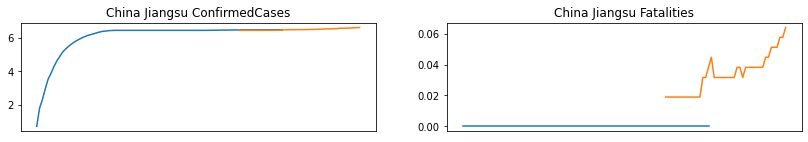

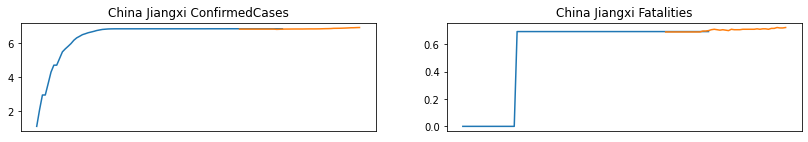

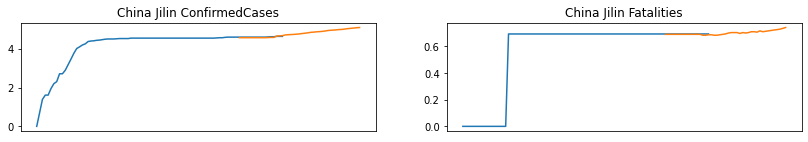

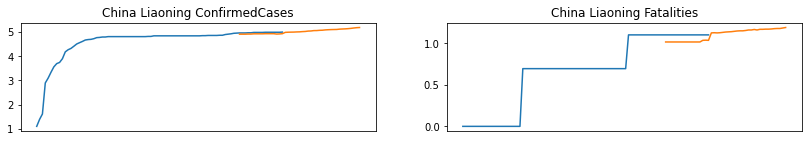

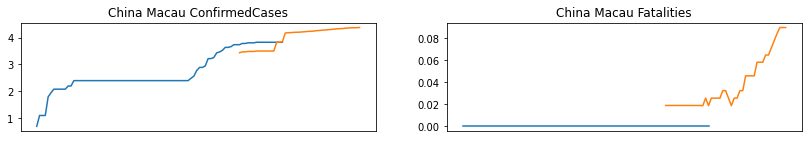

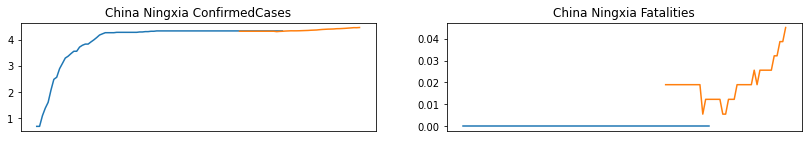

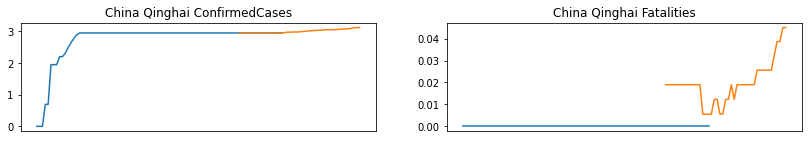

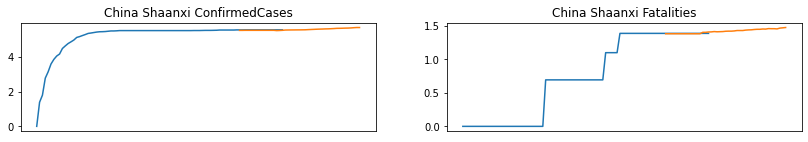

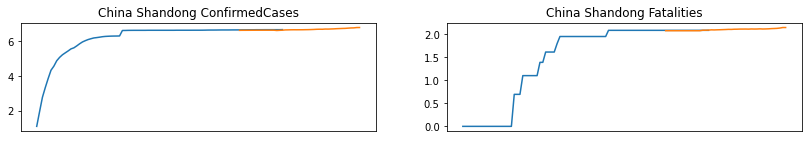

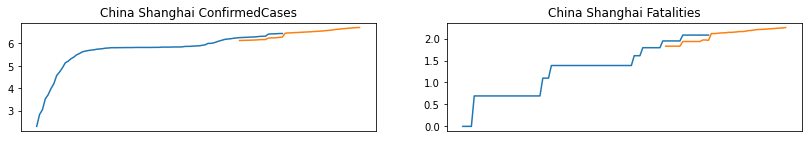

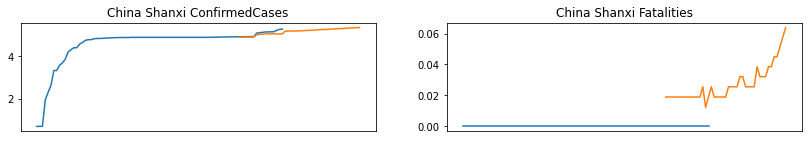

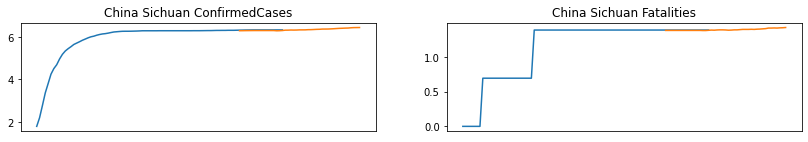

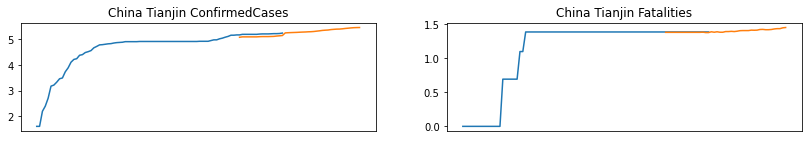

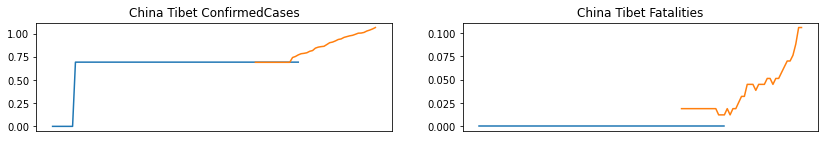

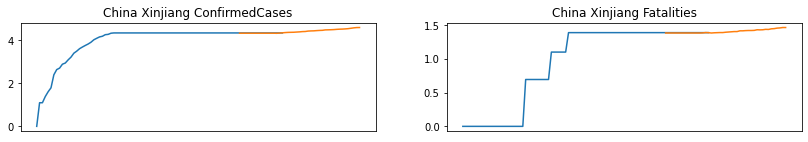

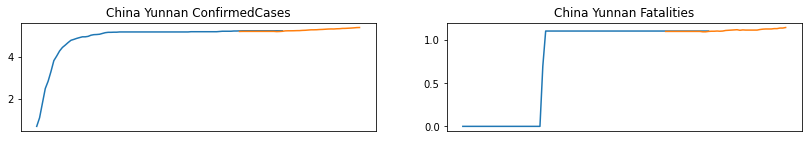

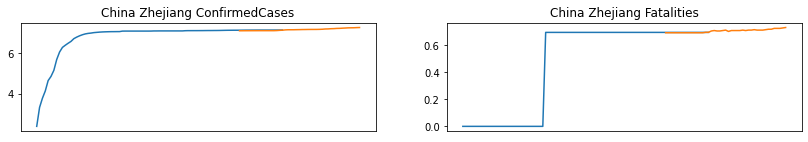

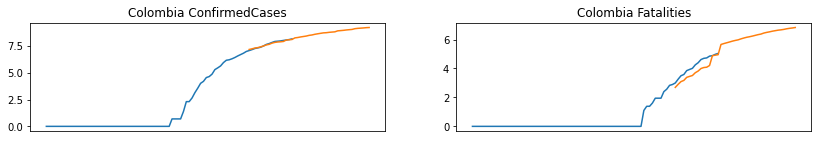

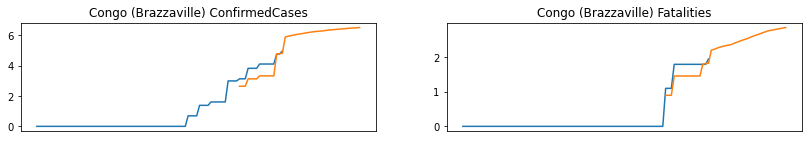

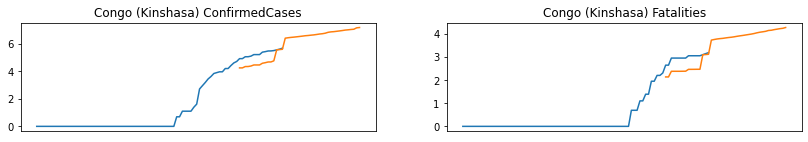

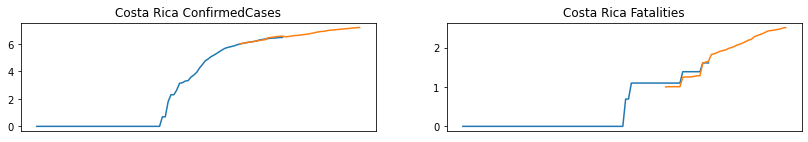

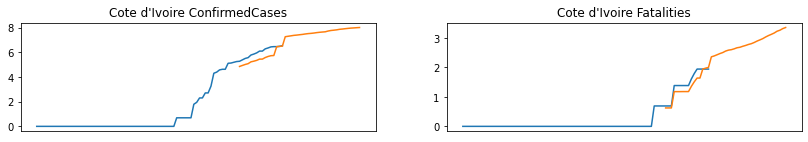

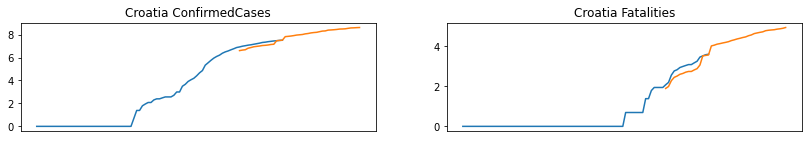

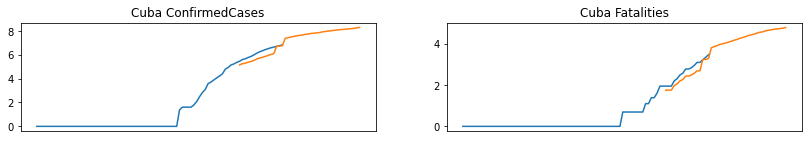

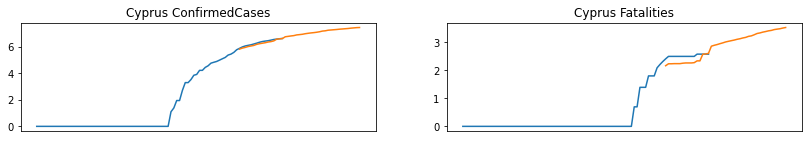

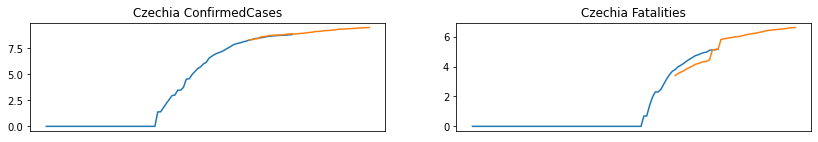

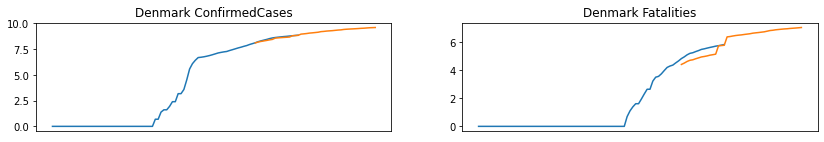

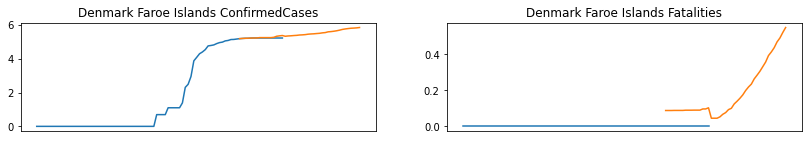

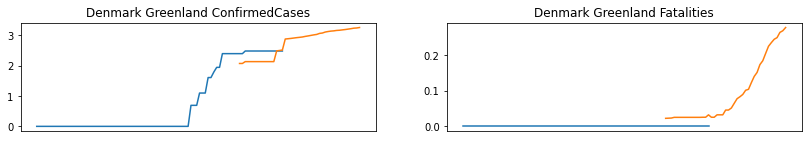

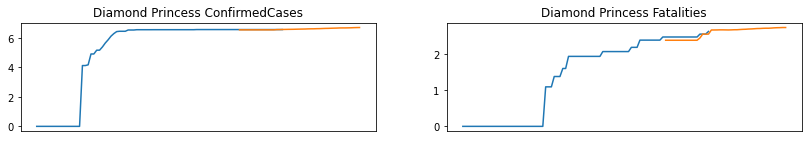

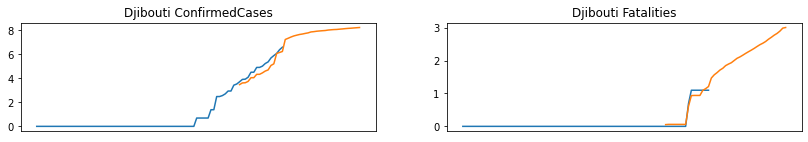

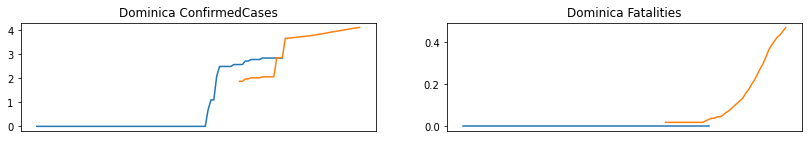

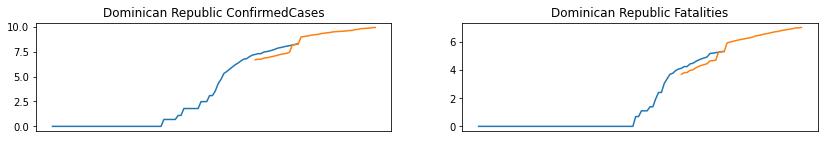

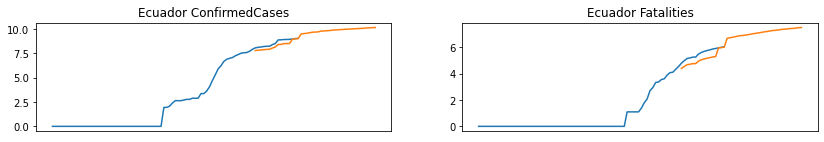

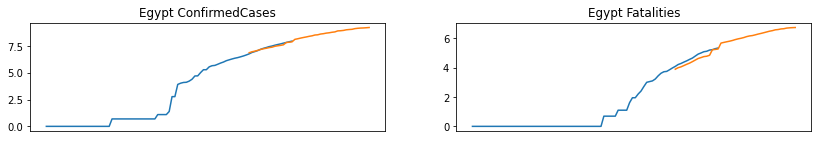

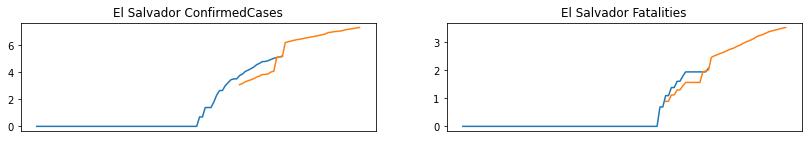

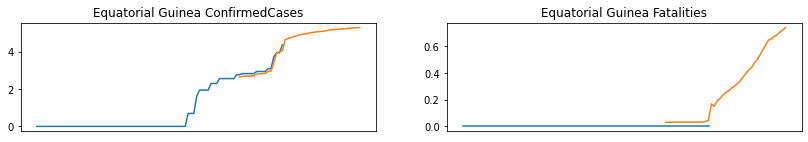

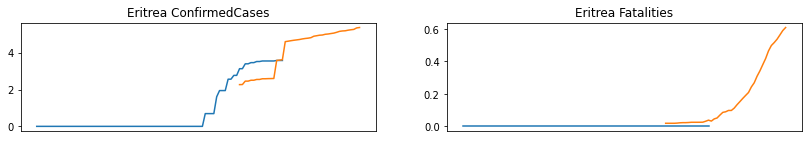

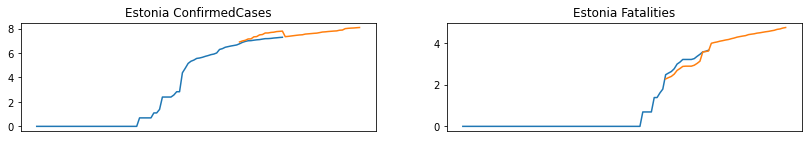

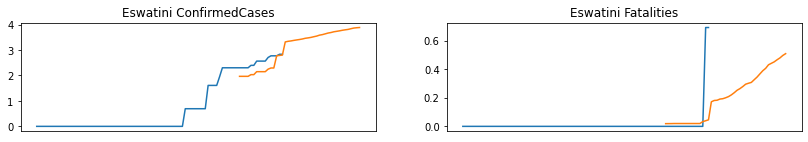

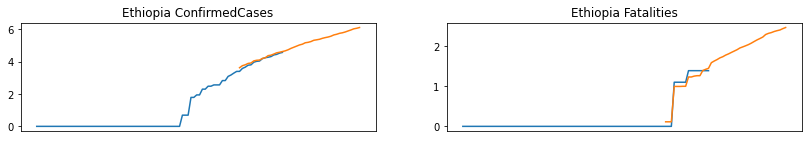

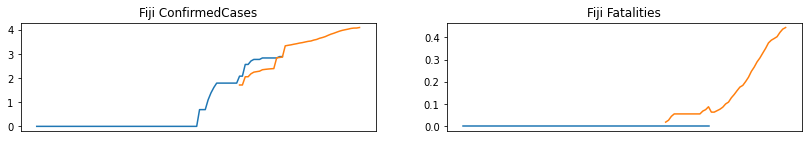

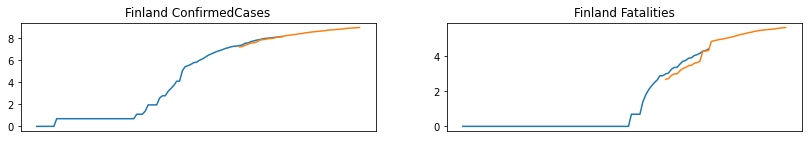

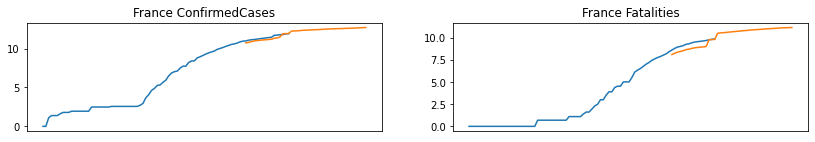

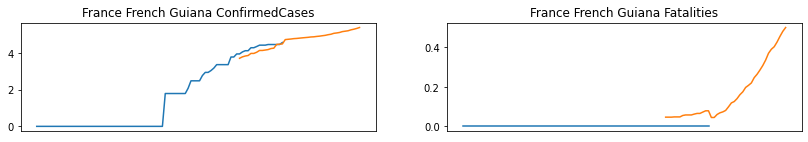

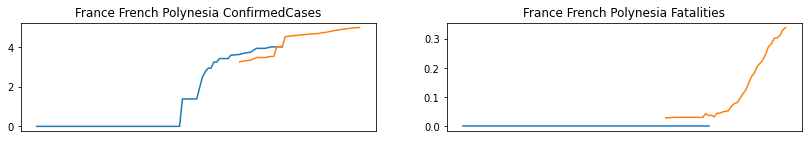

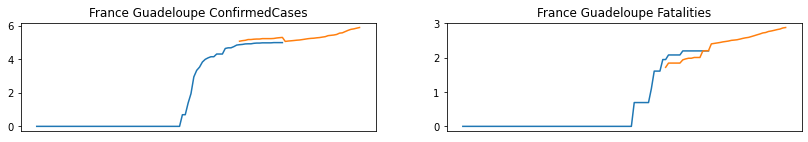

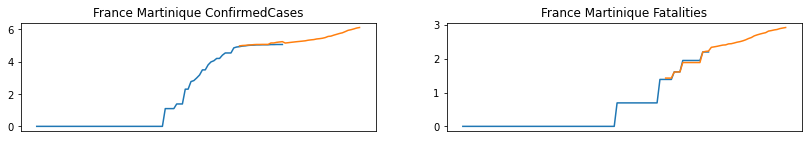

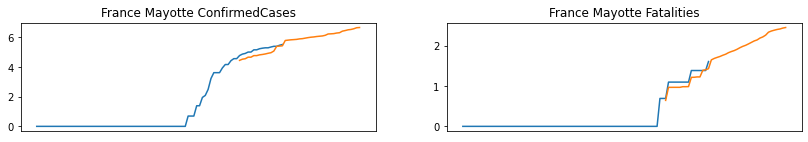

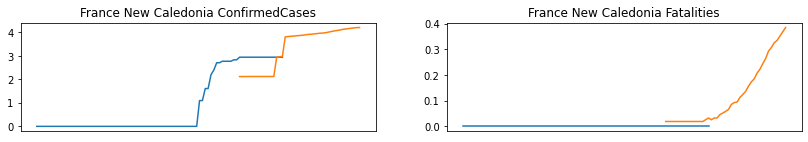

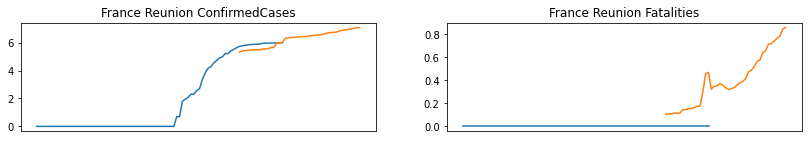

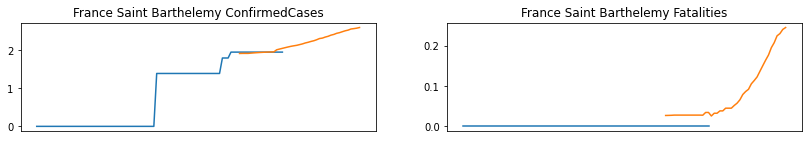

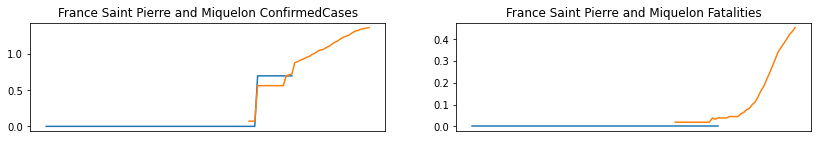

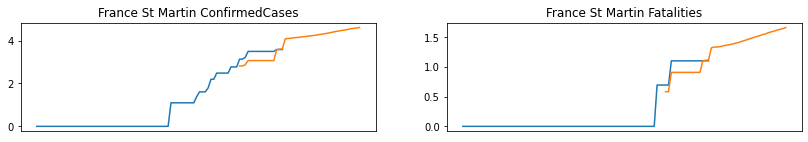

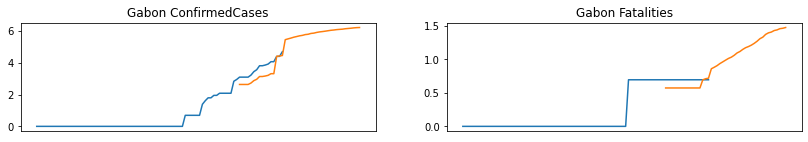

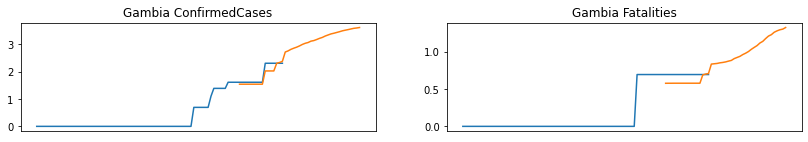

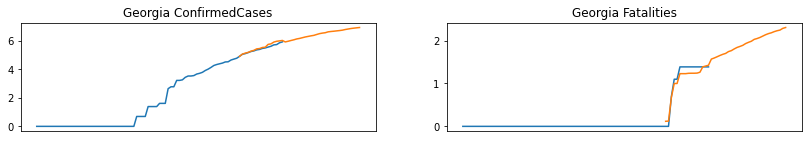

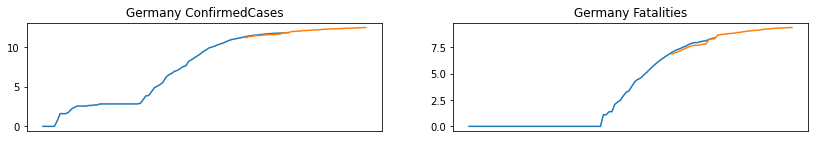

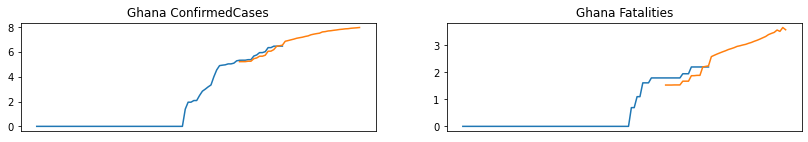

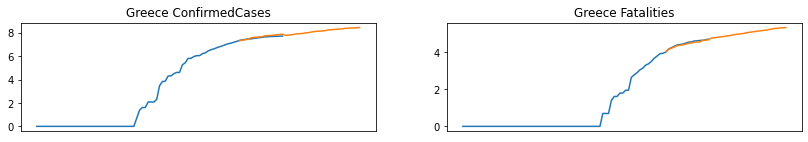

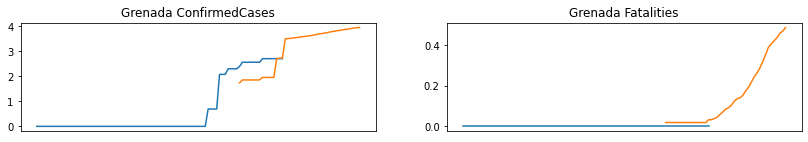

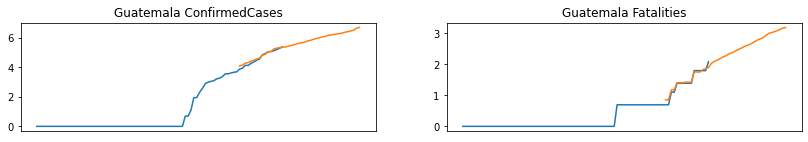

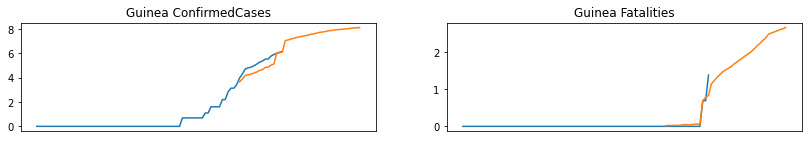

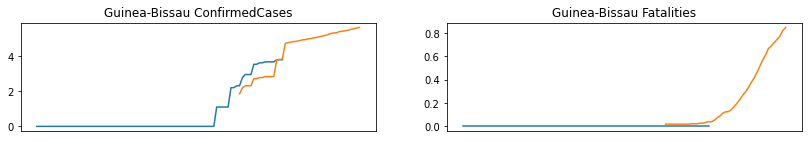

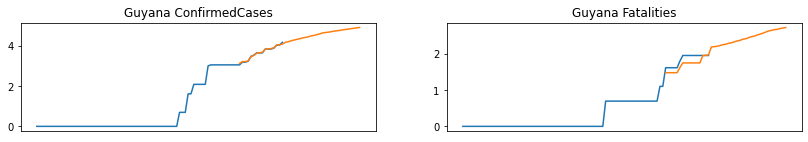

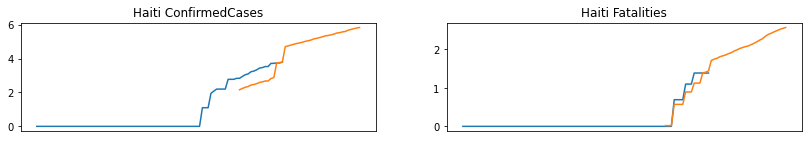

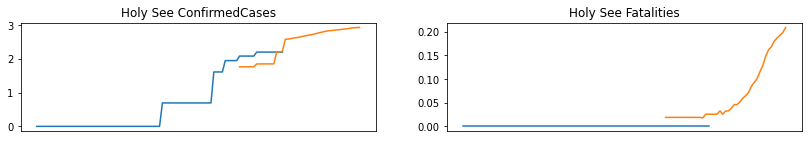

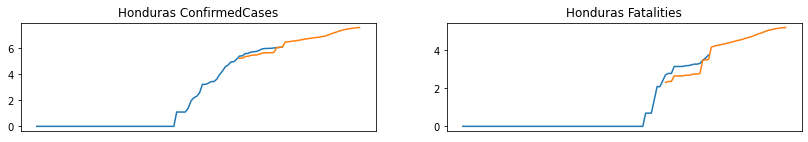

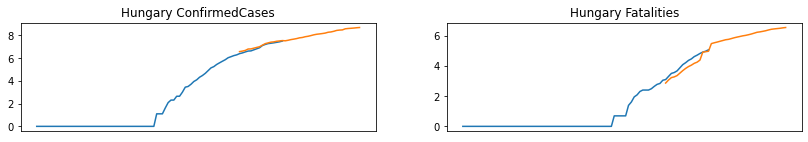

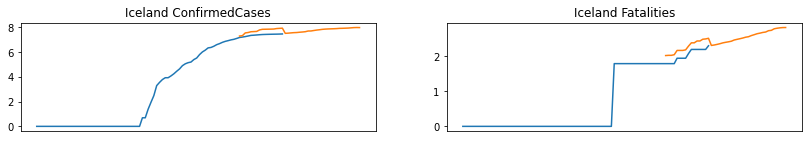

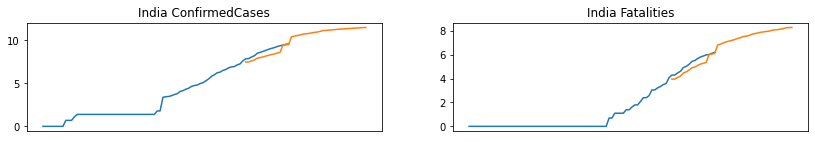

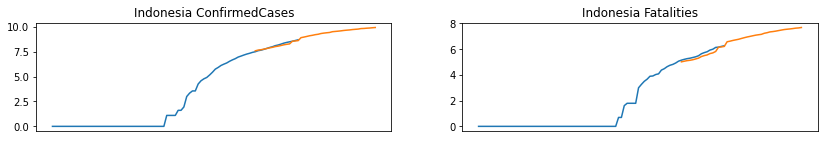

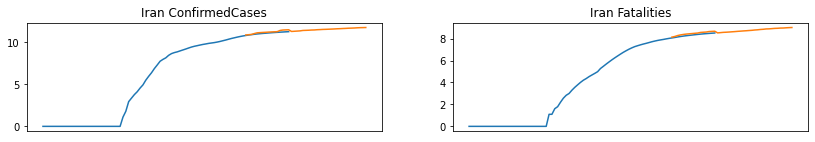

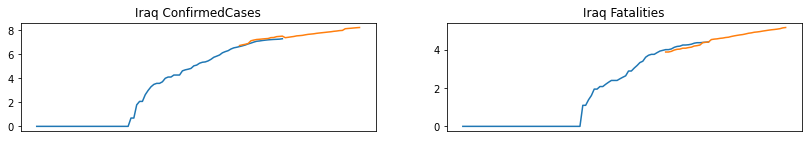

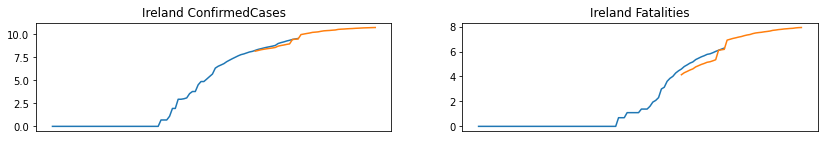

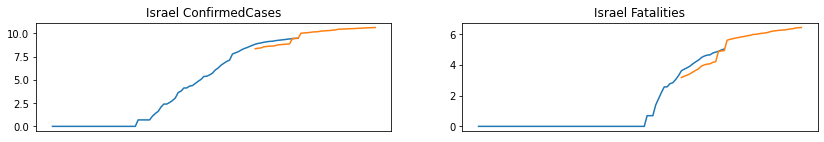

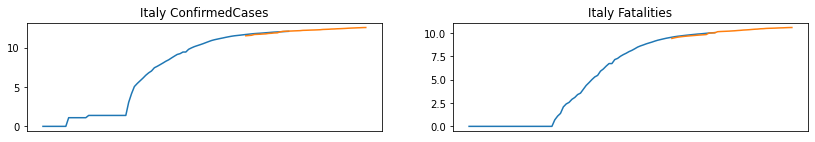

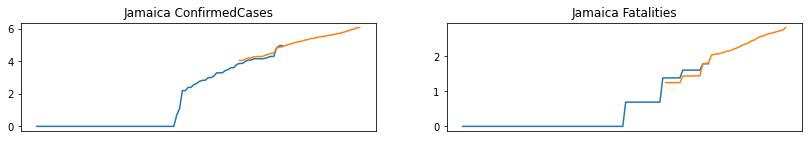

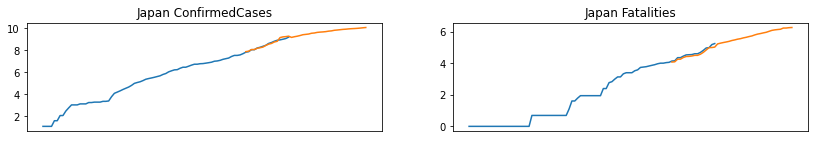

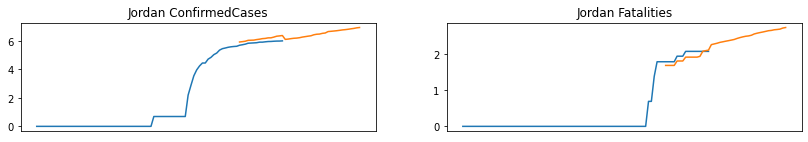

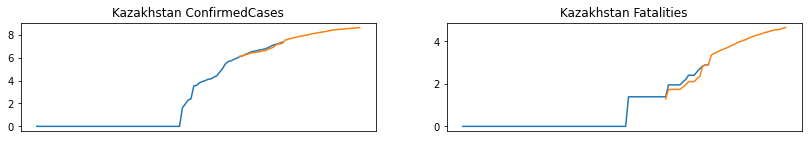

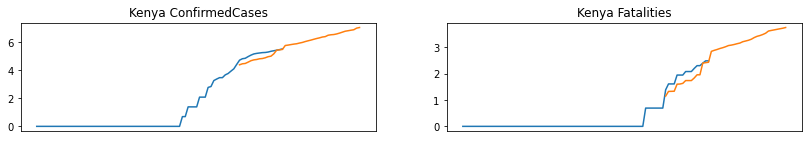

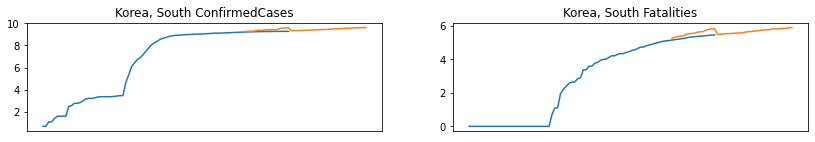

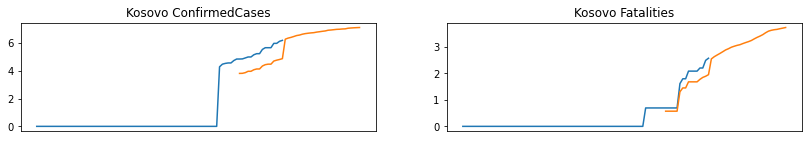

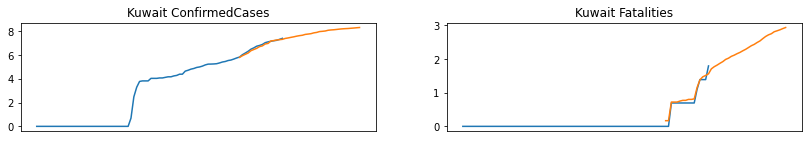

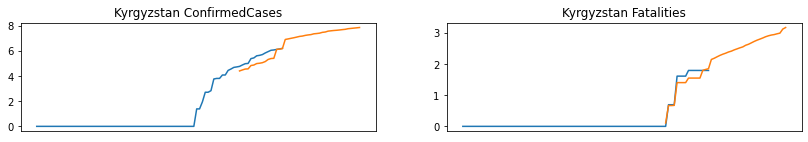

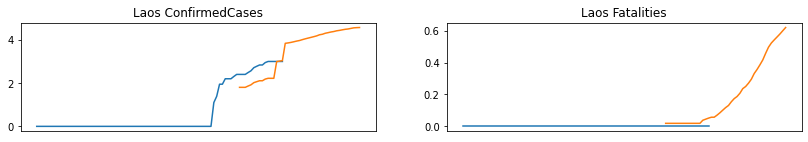

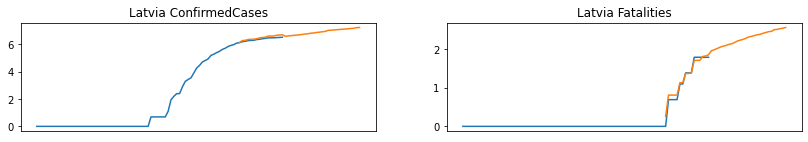

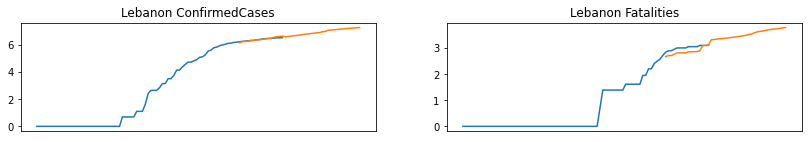

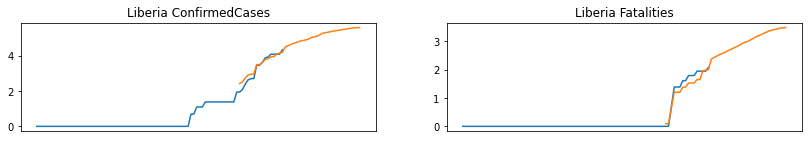

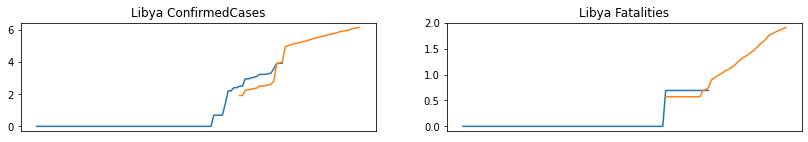

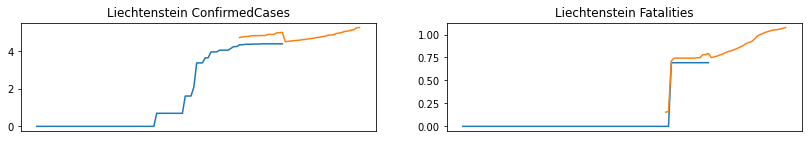

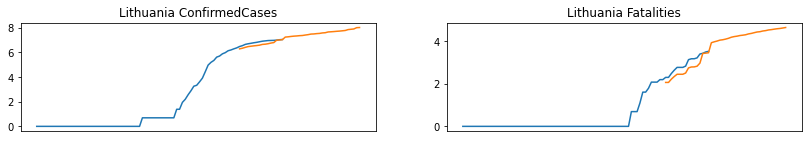

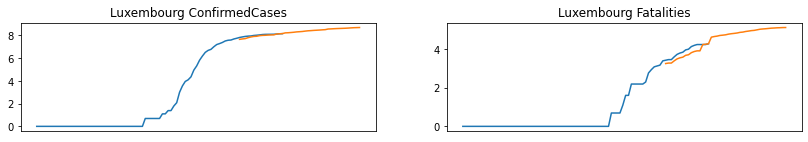

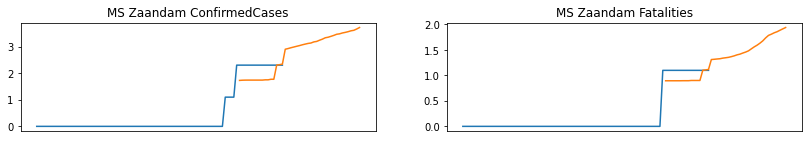

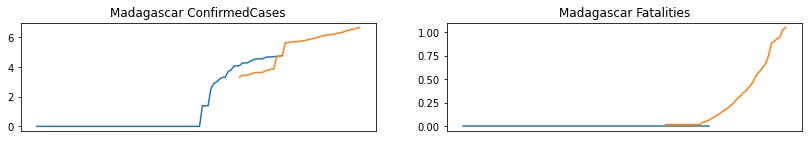

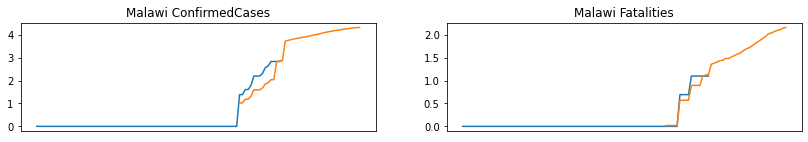

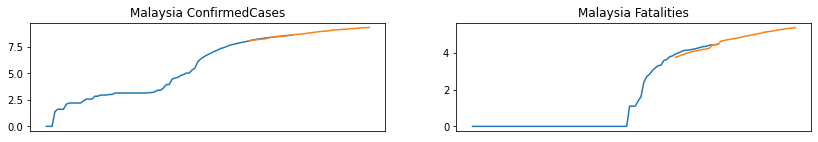

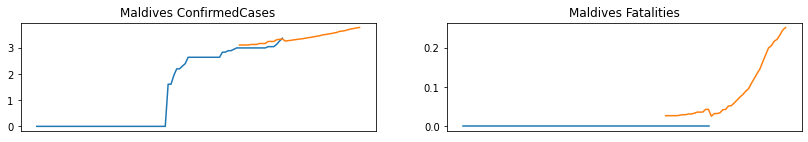

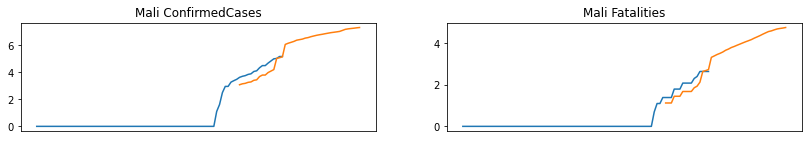

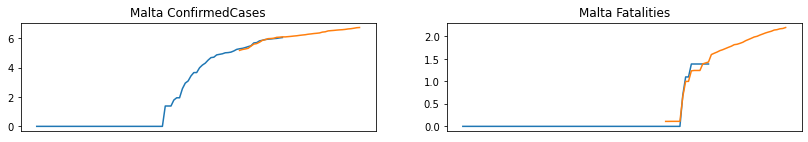

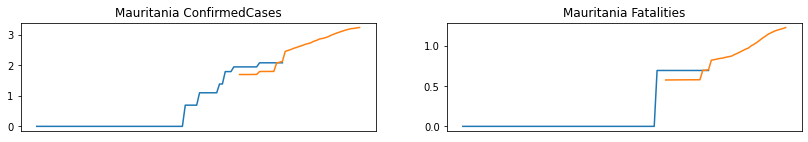

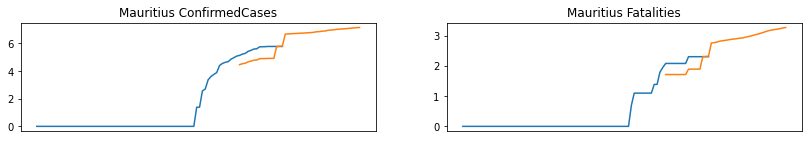

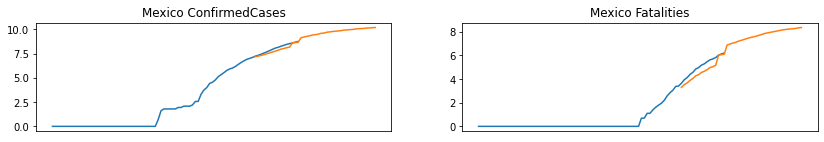

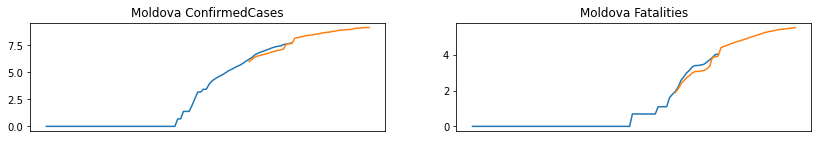

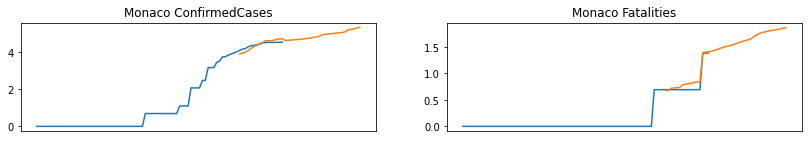

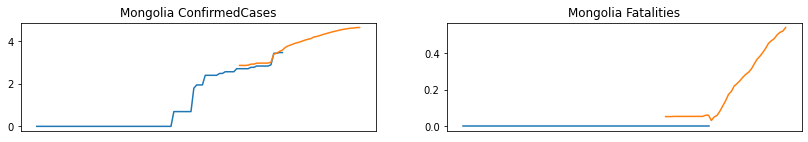

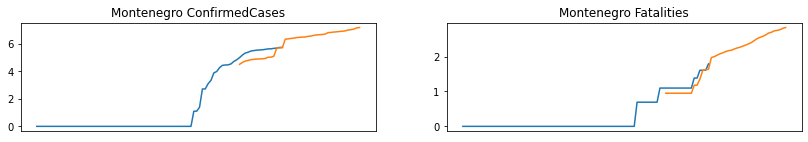

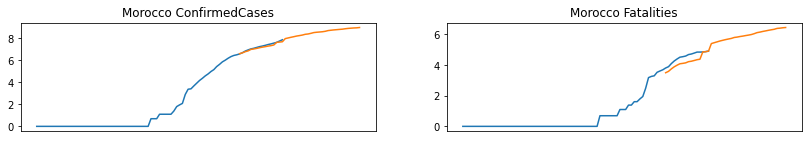

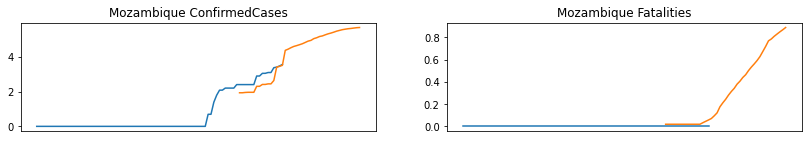

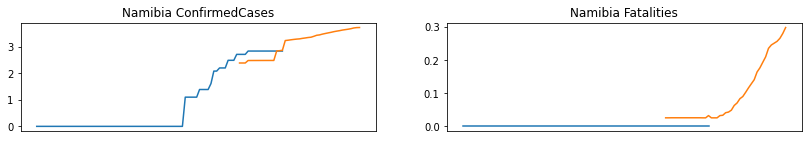

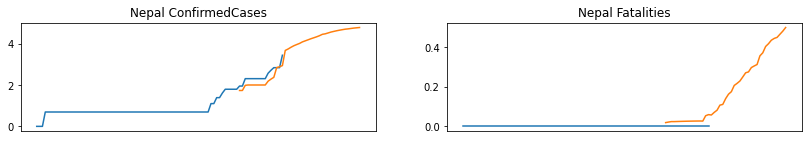

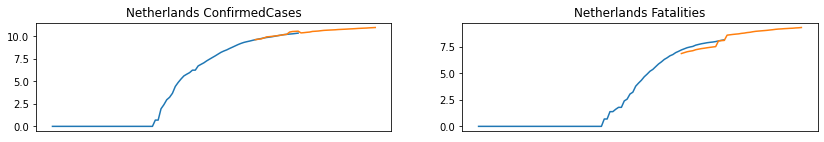

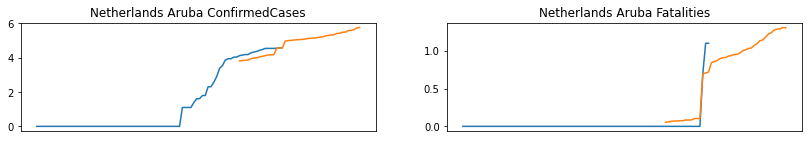

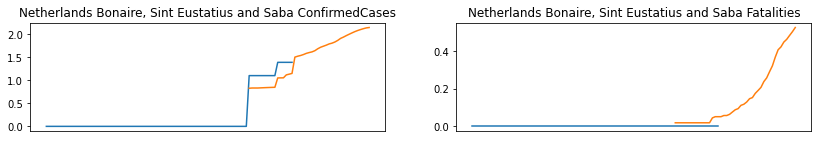

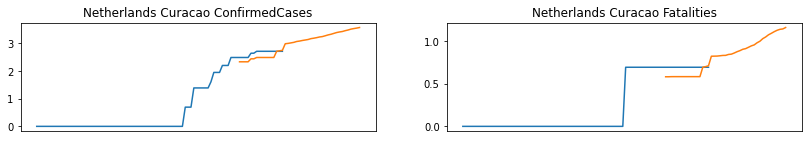

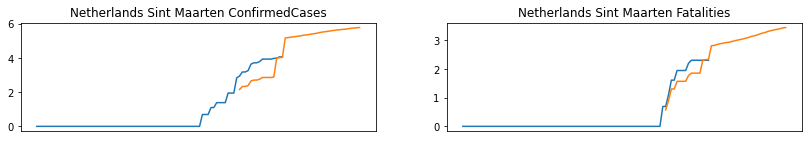

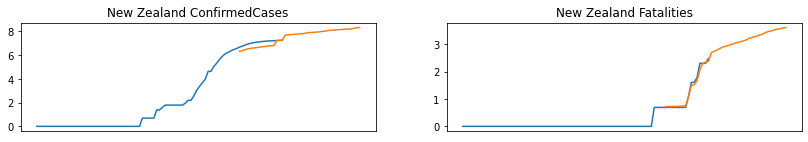

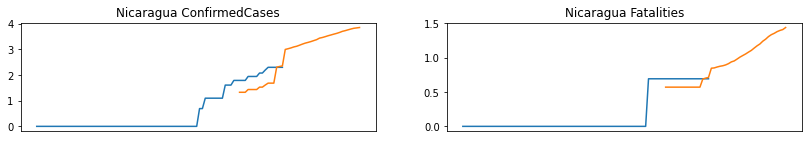

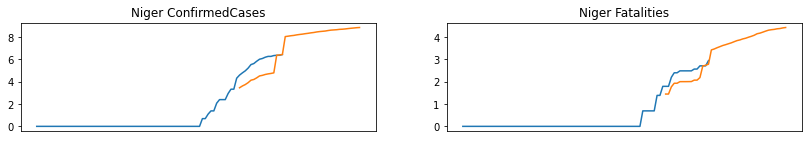

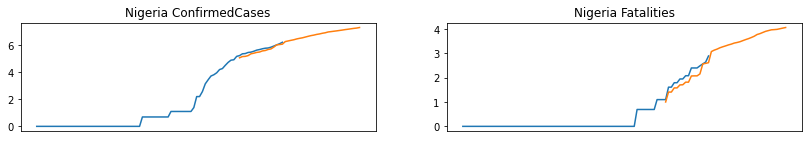

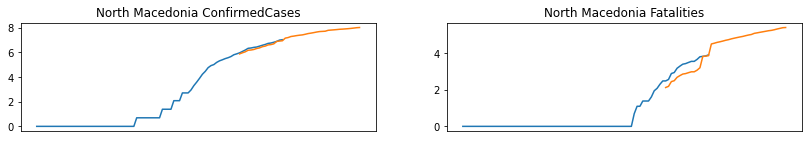

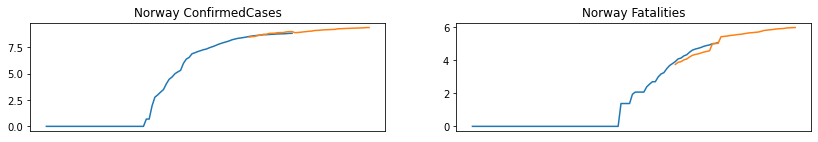

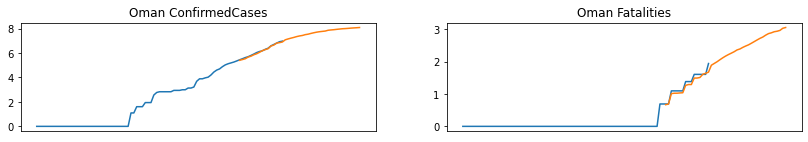

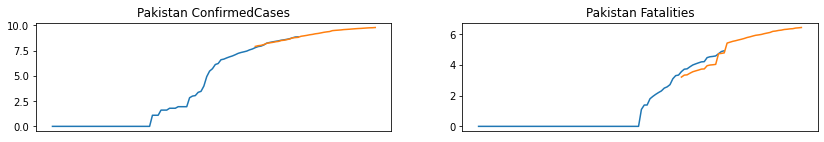

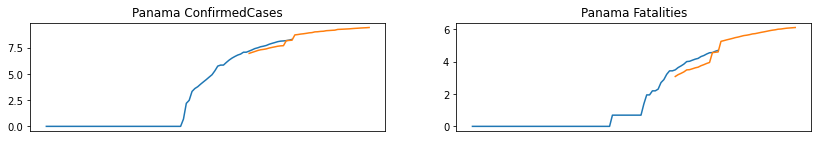

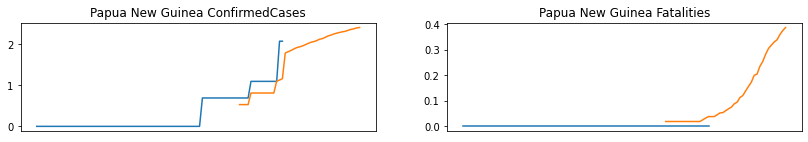

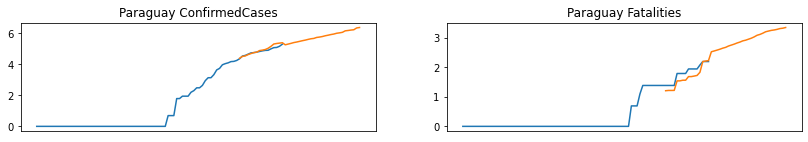

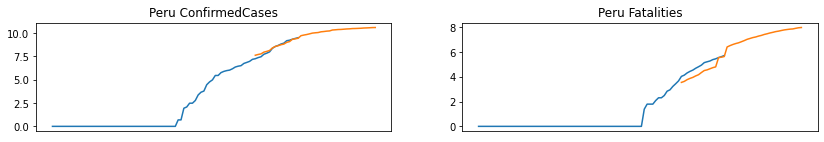

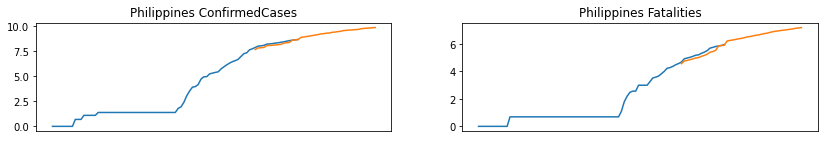

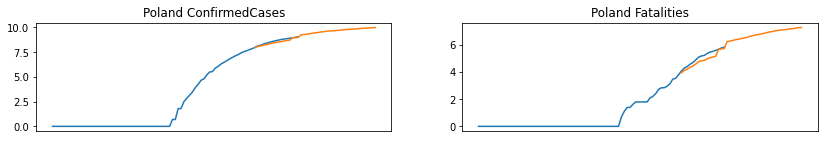

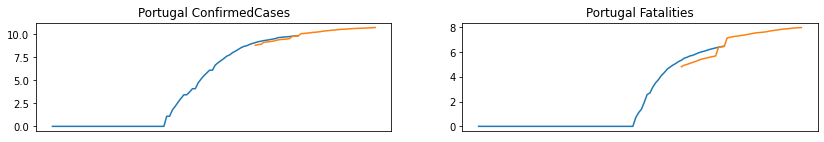

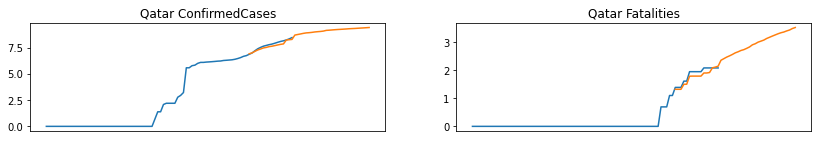

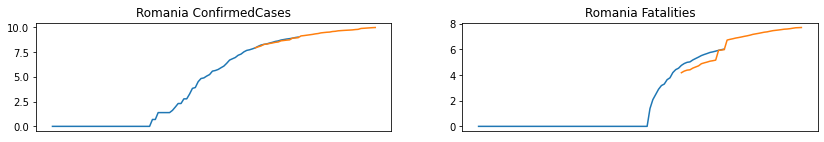

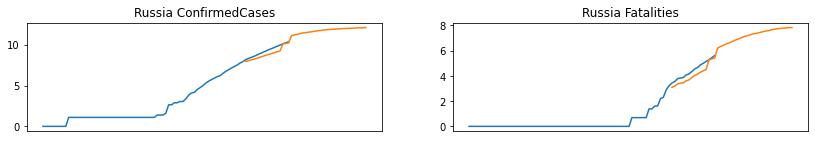

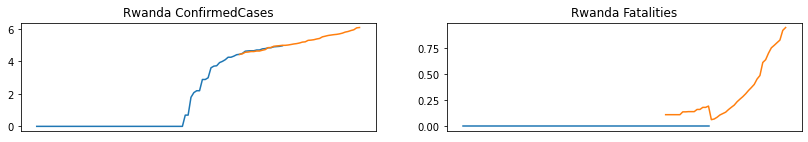

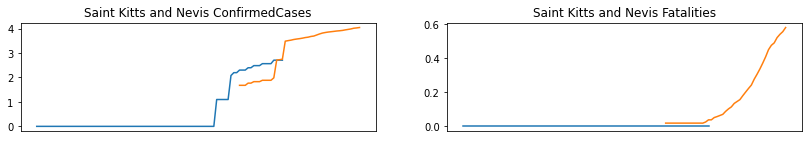

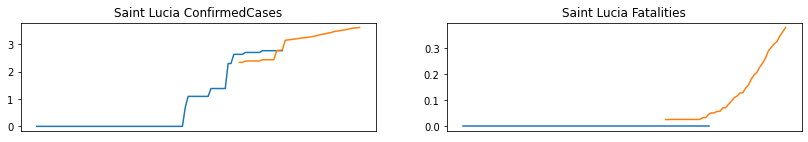

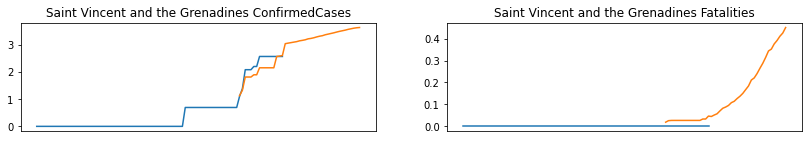

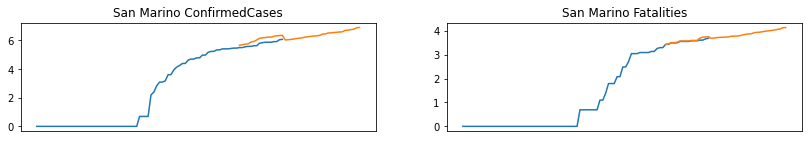

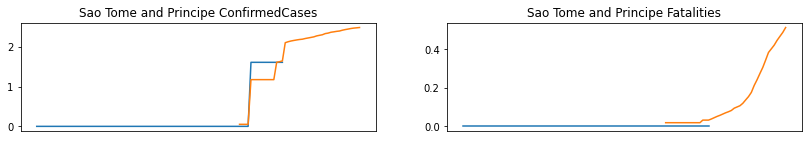

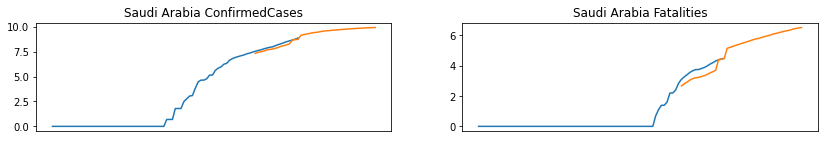

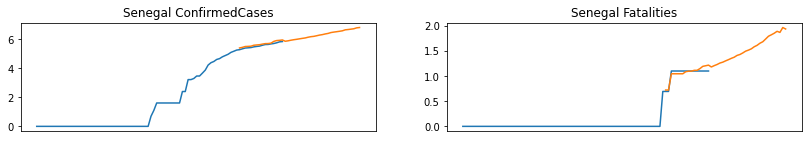

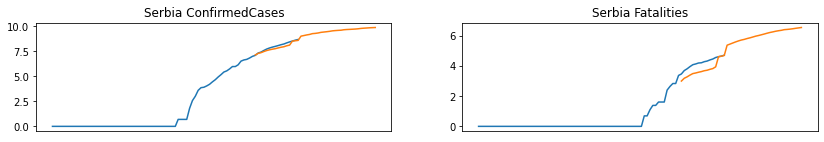

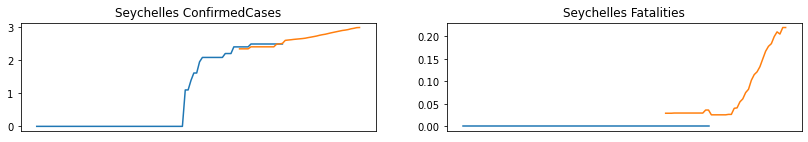

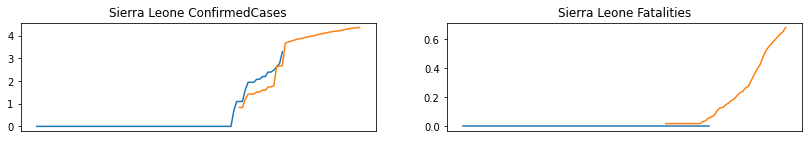

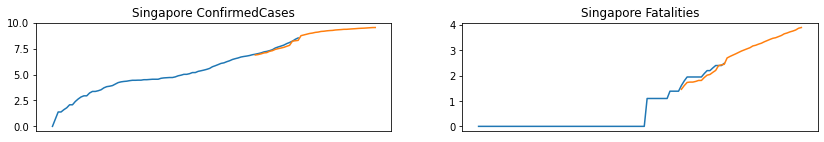

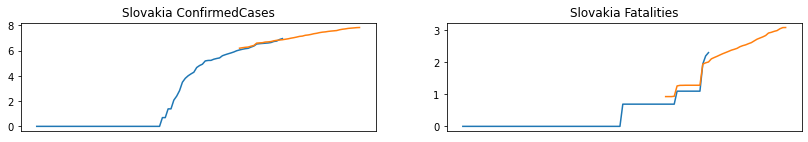

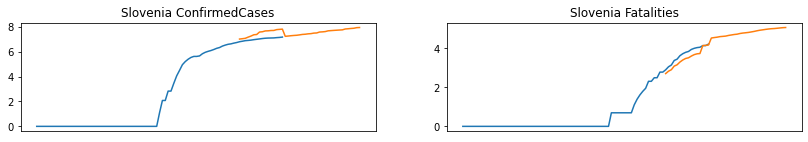

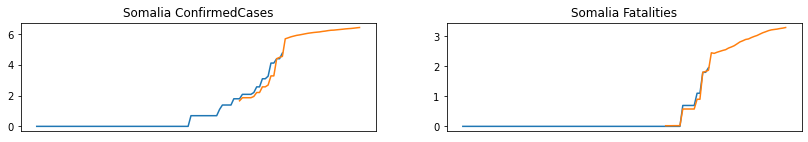

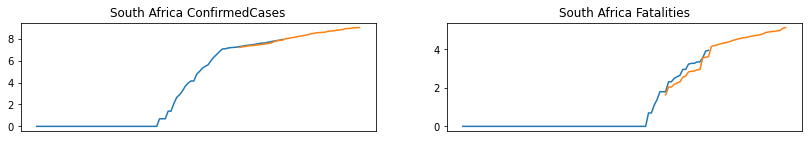

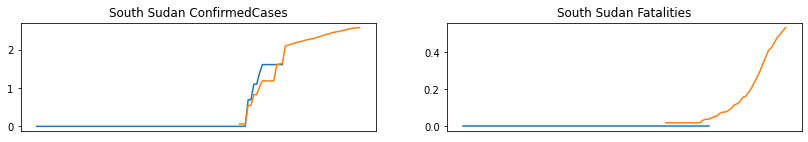

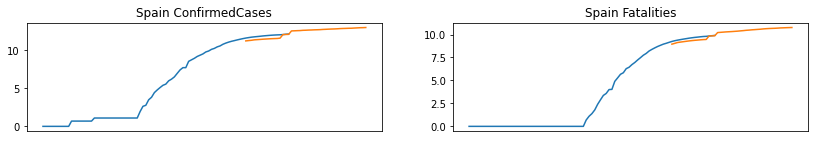

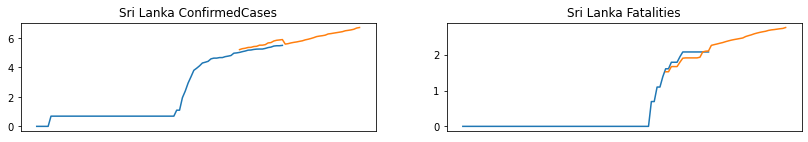

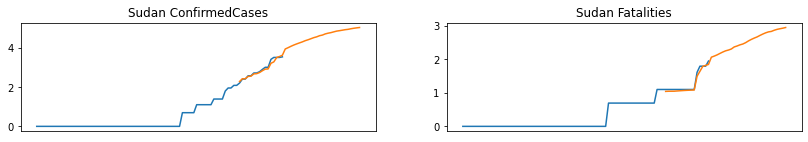

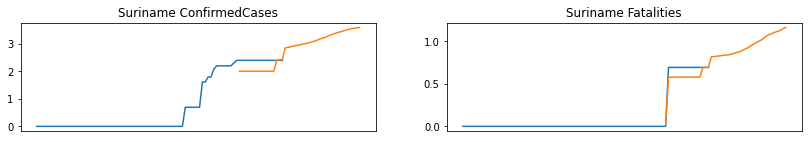

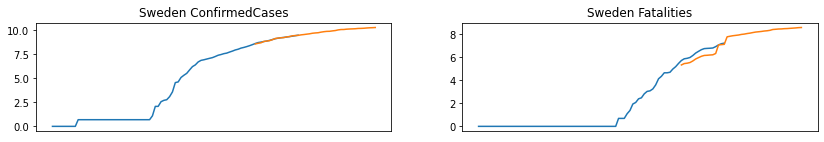

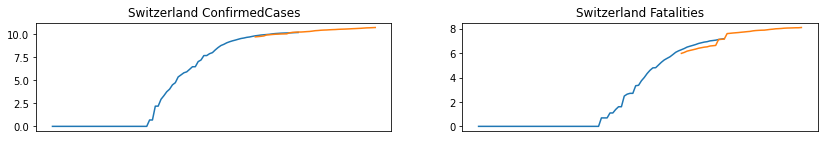

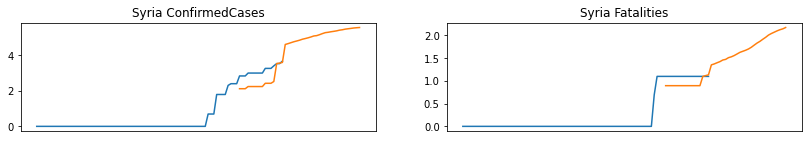

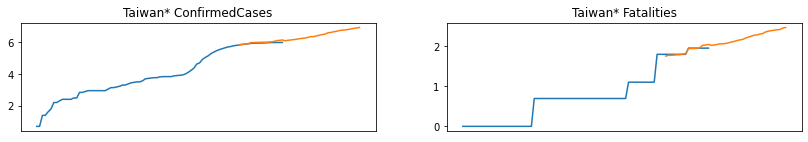

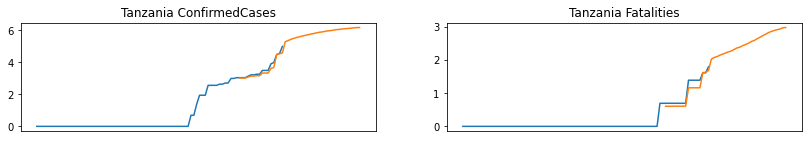

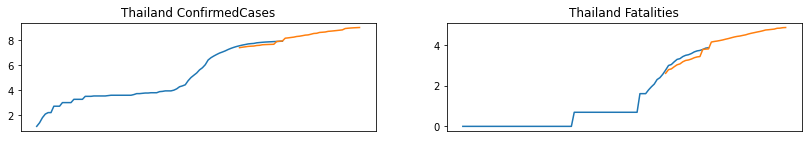

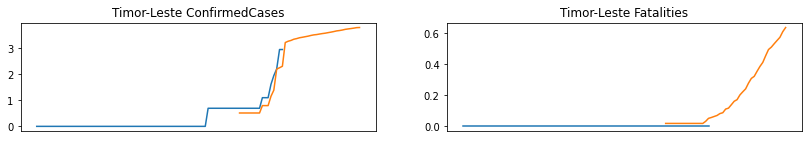

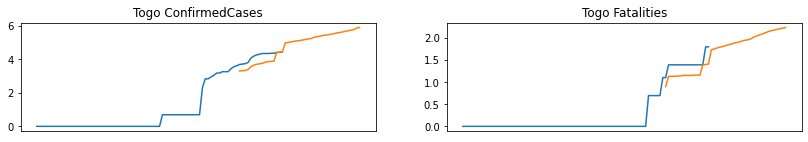

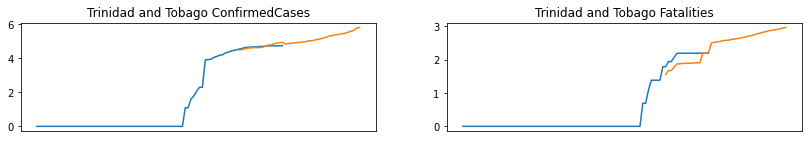

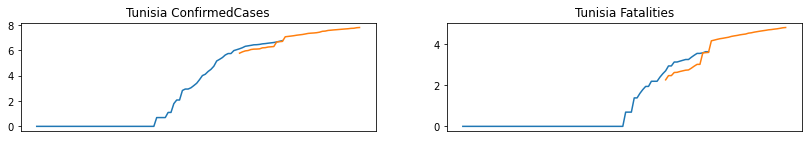

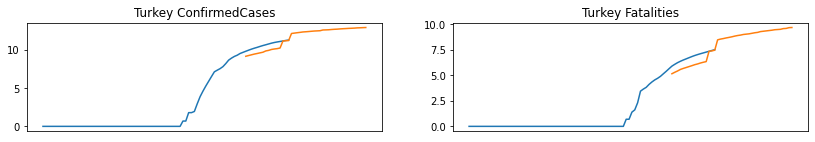

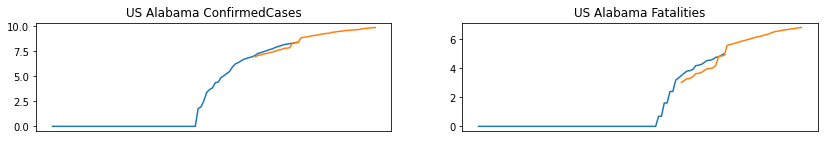

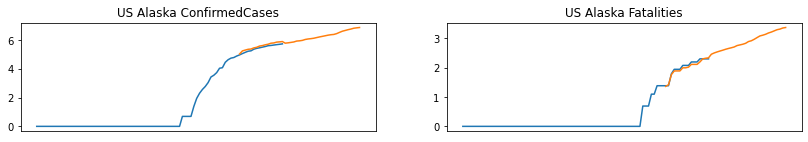

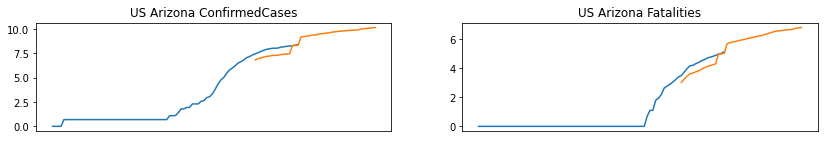

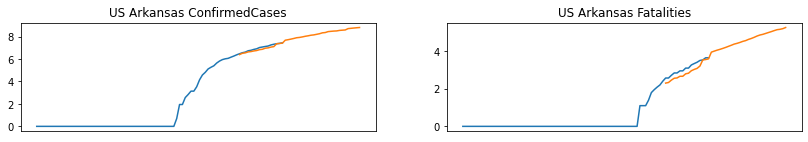

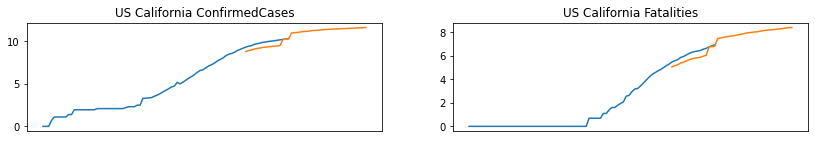

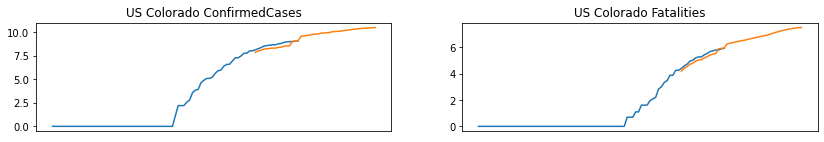

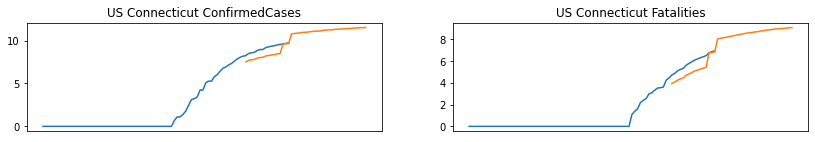

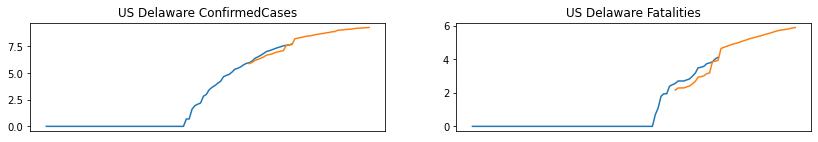

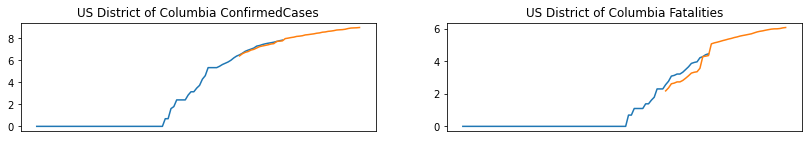

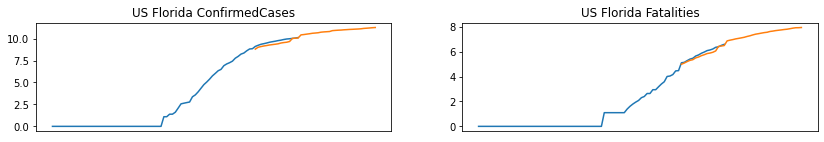

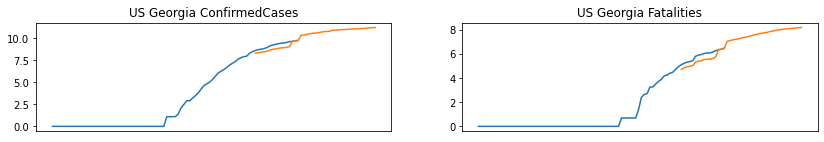

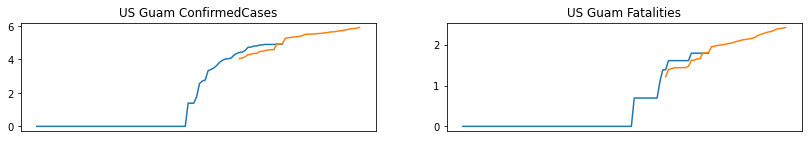

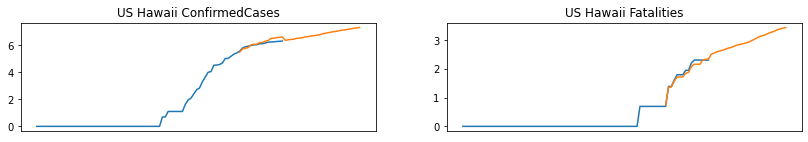

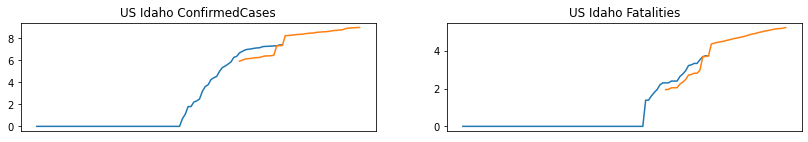

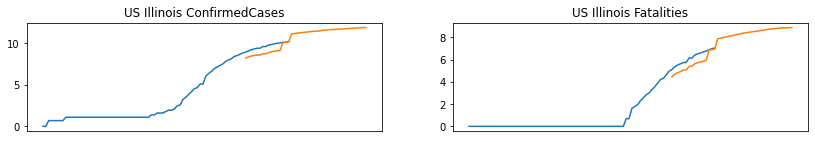

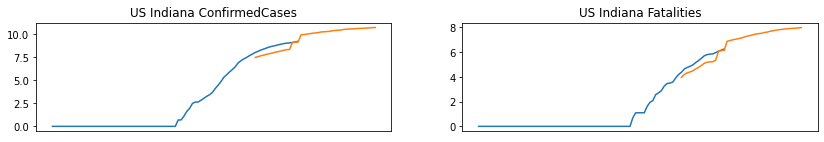

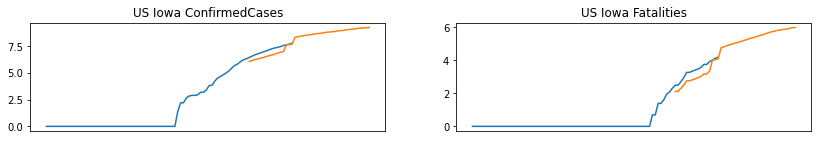

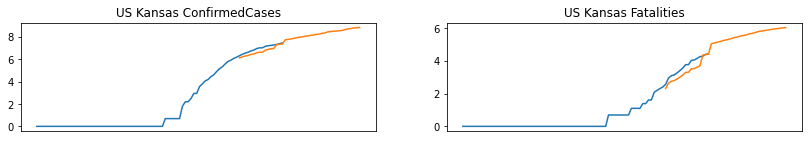

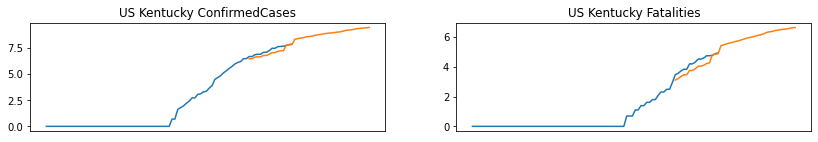

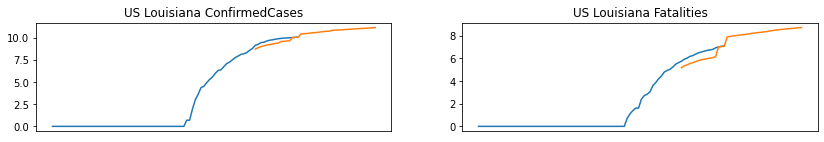

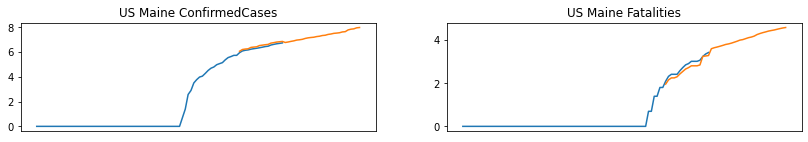

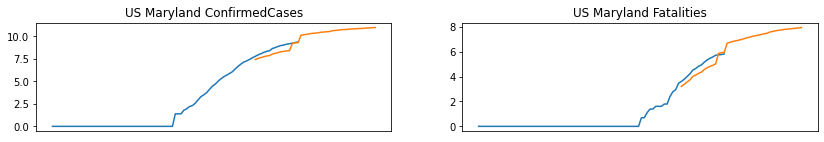

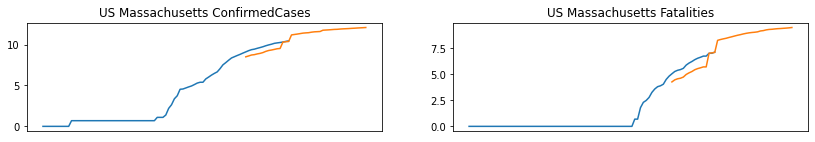

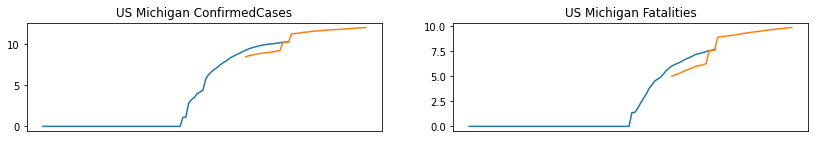

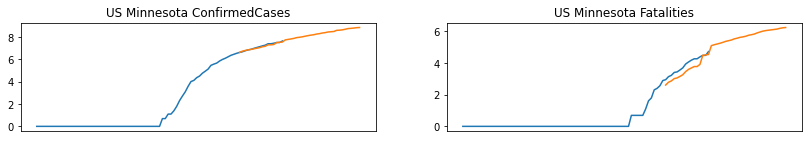

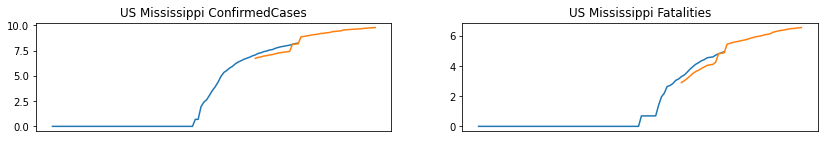

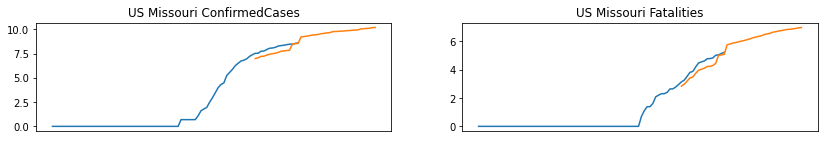

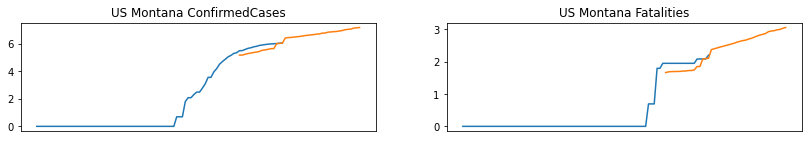

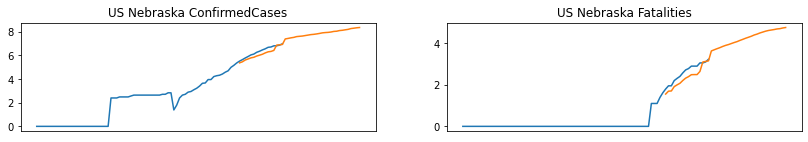

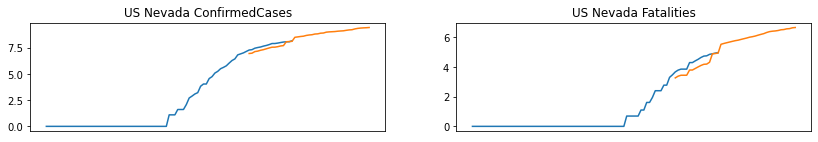

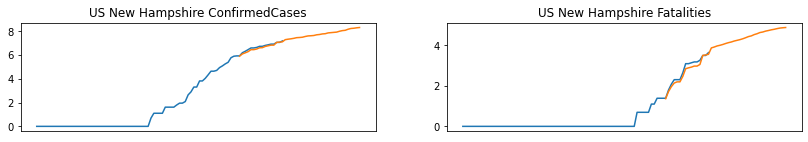

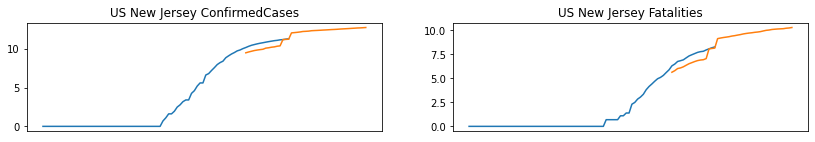

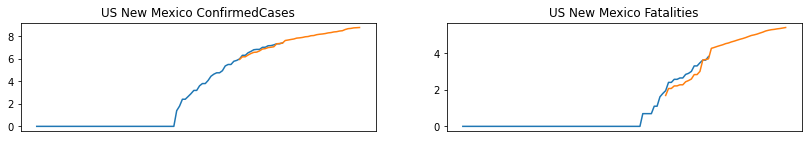

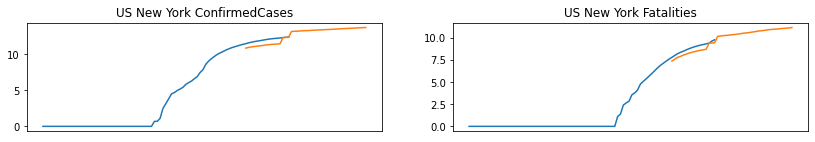

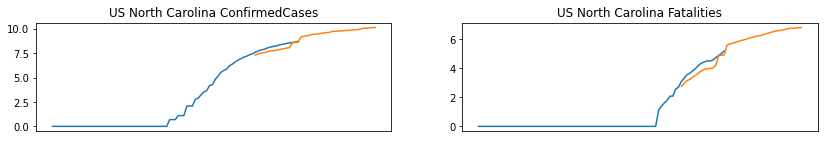

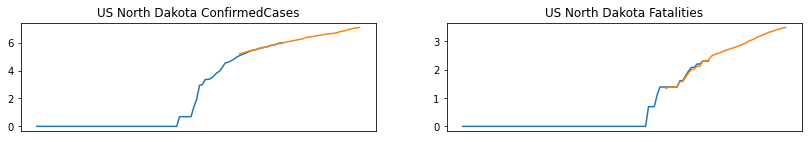

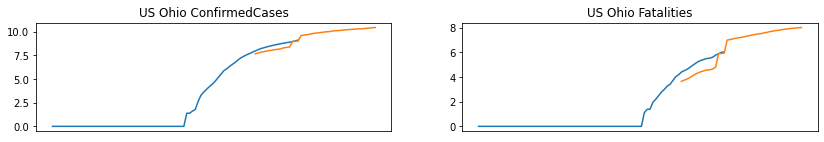

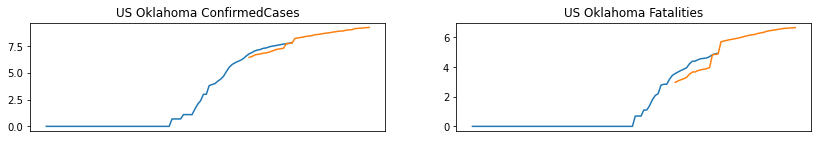

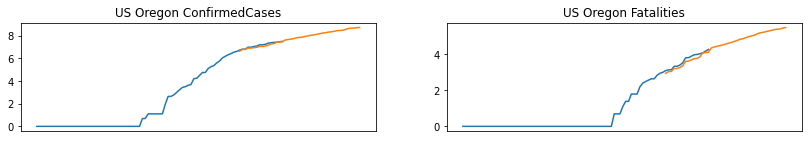

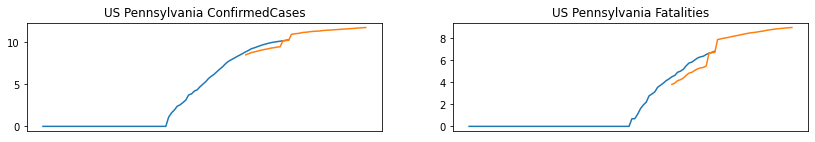

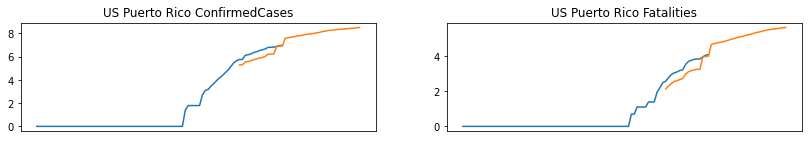

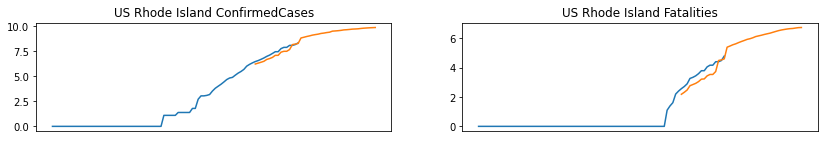

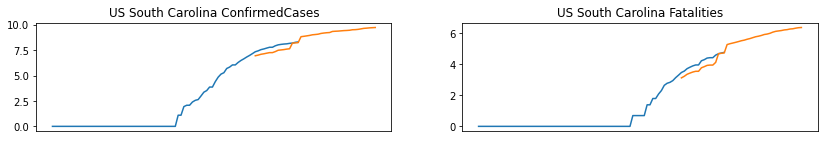

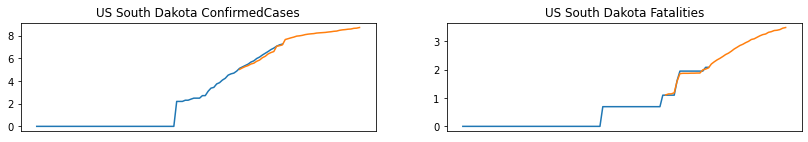

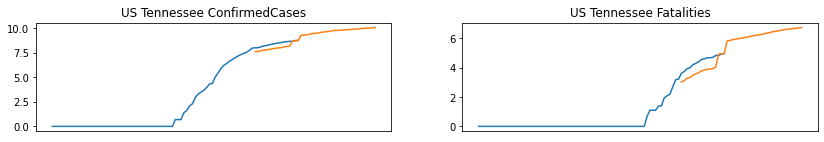

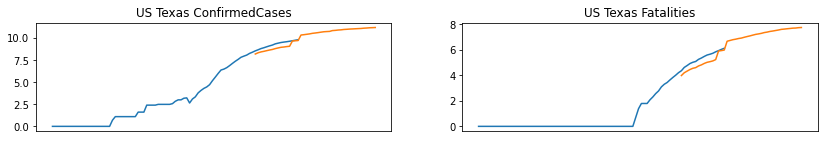

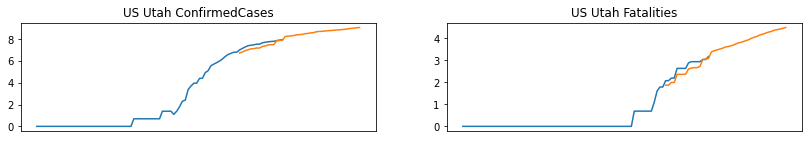

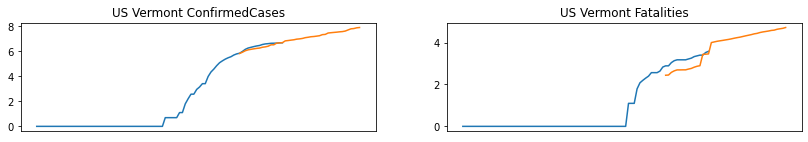

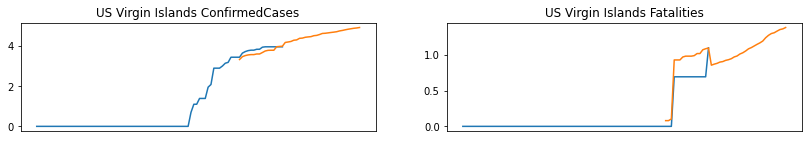

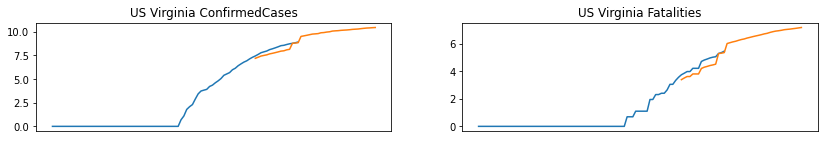

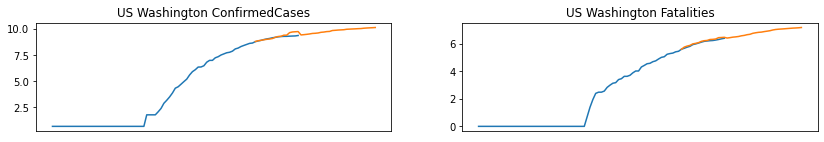

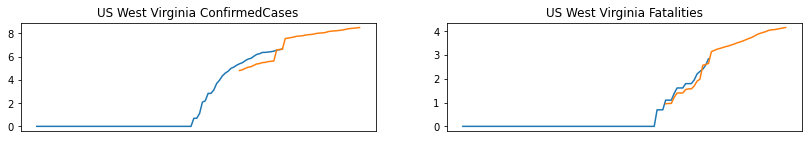

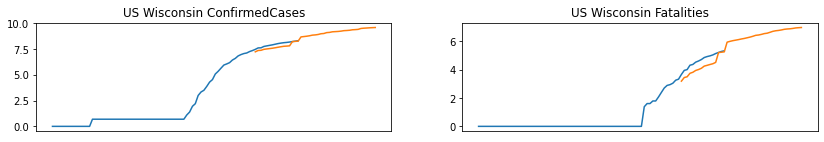

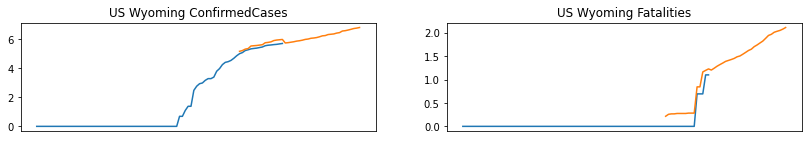

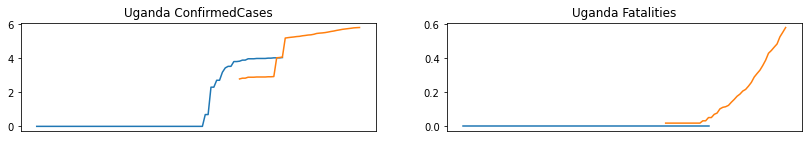

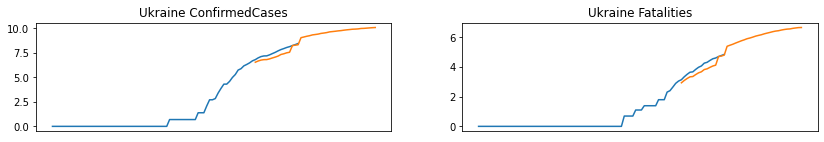

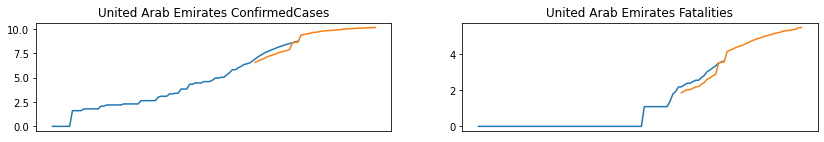

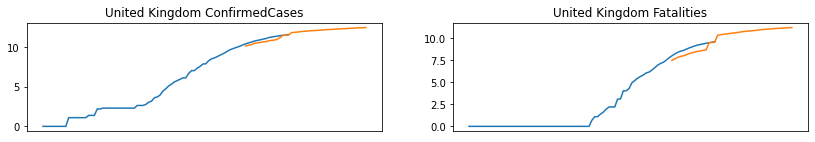

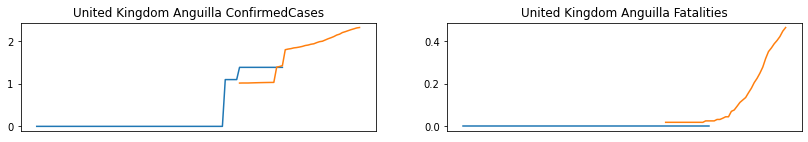

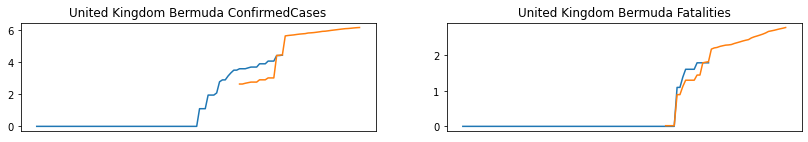

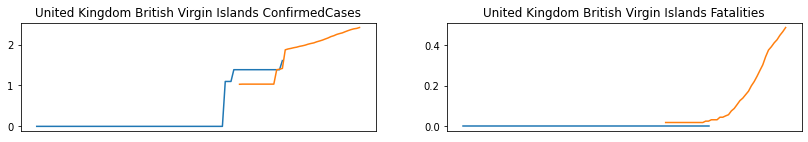

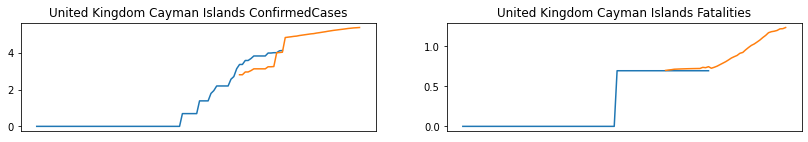

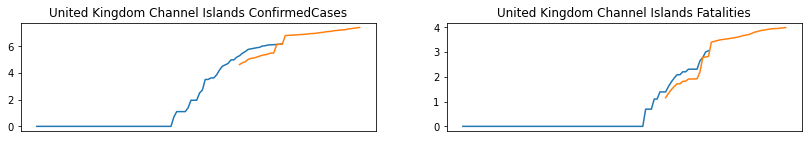

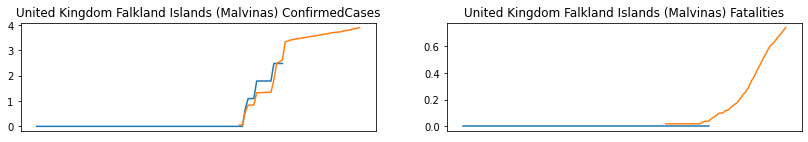

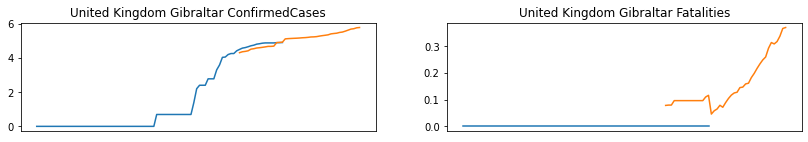

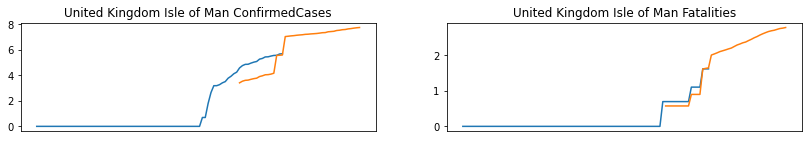

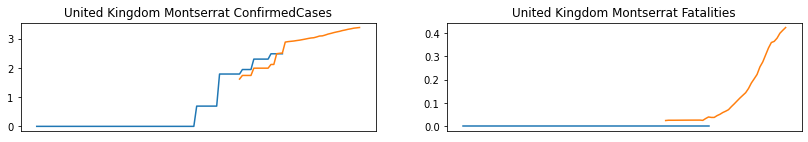

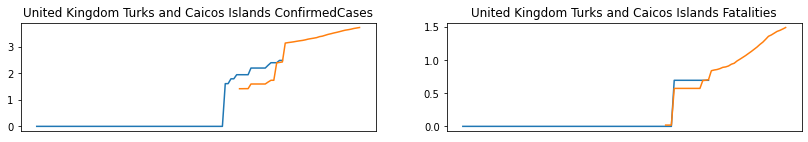

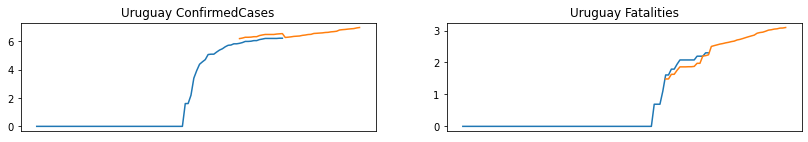

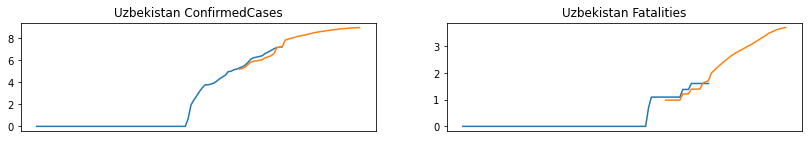

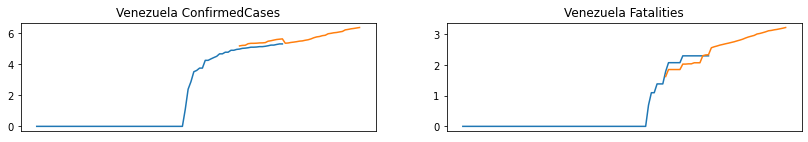

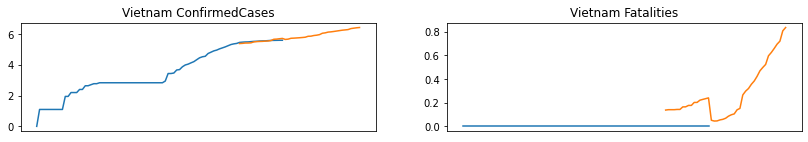

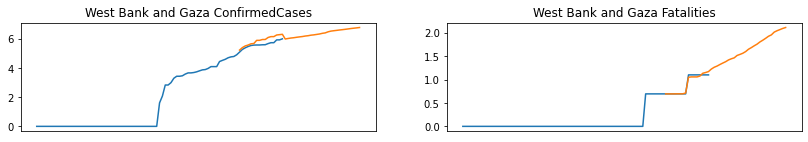

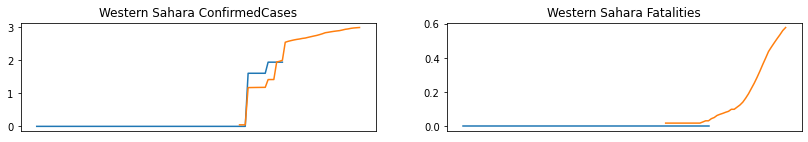

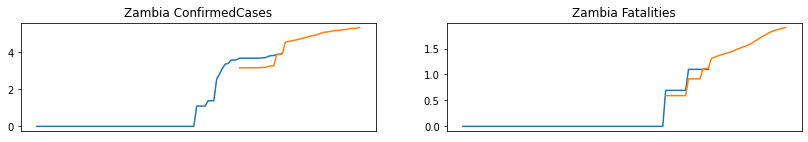

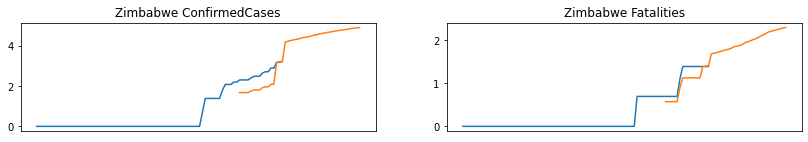

In [144]:
# plot actual and predicted curves over time for specific locations
# locs = ['China Tibet','China Xinjiang','China Hong Kong', 'China Macau',
#         'Spain','Italy','India',
#         'US Washington','US New York','US California',
#         'US North Carolina','US Ohio']
# xlab = ['03-12','03-18','03-25','04-01','04-08','04-15','04-22']
# plot all locations
locs = d['Loc'].drop_duplicates()
for loc in locs:
    plt.figure(figsize=(14,2))
    
    # fig, ax = plt.subplots()
    # fig.autofmt_xdate()
    
    for i in range(ny):
    
        plt.subplot(1,2,i+1)
        plt.plot(d.loc[d.Loc==loc,[yv[i],'Date']].set_index('Date'))
        plt.plot(d.loc[d.Loc==loc,[mname + str(i),'Date']].set_index('Date'))
        # plt.plot(d.loc[d.Loc==loc,[yv[i]+'_pred','Date']].set_index('Date'))
        # plt.plot(d.loc[d.Loc==loc,[yv[i]]])
        # plt.plot(d.loc[d.Loc==loc,[yv[i]+'_pred']])
        # plt.xticks(np.arange(len(xlab)), xlab, rotation=-45)
        # plt.xticks(np.arange(12), calendar.month_name[3:5], rotation=20)
        # plt.xticks(rotation=-45)
        plt.xticks([])
        plt.title(loc + ' ' + ynames[i])
       
    plt.show()

In [145]:
fixed.describe()

ForecastId  ConfirmedCases    Fatalities
count  13459.000000    13459.000000  13459.000000
mean    6730.000000    11744.537694    907.569801
std     3885.422971    47120.835362   4870.251788
min        1.000000        0.046915      0.005587
25%     3365.500000      120.771145      1.495500
50%     6730.000000      670.085729      9.846522
75%    10094.500000     3869.443312    106.855222
max    13459.000000   861656.689000  71930.794000